Install additional packages

In [1]:
!pip install pyarrow category_encoders klib

     |████████████████████████████████| 17.7 MB 3.1 MB/s eta 0:00:01     |███████████████████▌            | 10.8 MB 3.1 MB/s eta 0:00:03
     |████████████████████████████████| 80 kB 19.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
# Changes on custom modules will be automatically reloaded
%load_ext autoreload
%autoreload 2

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, I will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. I'll use unsupervised learning techniques (dimensionality reduction + clustering) to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, I'll apply what was learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [55]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt

from collections import defaultdict, Counter, OrderedDict

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
# custom models
import os, sys
sys.path.append('.')

import processing, utils, eda

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that final predictions will be assessed in the Kaggle competition.

## General Demographic Data - Data Cleanup and EDA

In [4]:
# get a reference to S3 bucket
bucket = utils.BucketUtils(bucket_name = 'arvatos-capstone', prefix = 'data')

Load data

In [6]:
# load in the data
azdias = bucket.read_csv('Udacity_AZDIAS_052018.csv.gz')
sample = azdias.sample(7, random_state=42)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Visualize some sample data

In [7]:
sample

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
848815  956771         1         1.0      12.0          NaN          NaN   
299816  536767        -1         1.0       0.0          NaN          NaN   
570748  393990        -1         9.0       0.0          NaN          NaN   
354371  596074        -1         9.0      16.0          NaN          NaN   
329018  586471        -1         NaN       NaN          NaN          NaN   
49016   502317         1         9.0      10.0          NaN          NaN   
454415  491540        -1         9.0       0.0          NaN          NaN   

        ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
848815          NaN          NaN                  12.0                  6.0   
299816          NaN          NaN                  21.0                  1.0   
570748          NaN          NaN                   NaN                  1.0   
354371          NaN          NaN                  15.0                  1.0   
329018          NaN          NaN                   NaN                  NaN   
49016           NaN          NaN                  10.0                  1.0   
454415          NaN          NaN                   NaN                  1.0   

        ...  VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
848815  ...  2.0       9.0        12.0     10.0             NaN   
299816  ...  1.0       2.0         3.0      3.0             3.0   
570748  ...  1.0       8.0         9.0      6.0             6.0   
354371  ...  NaN       2.0         3.0      4.0             2.0   
329018  ...  NaN       NaN         NaN      NaN             NaN   
49016   ...  4.0       9.0        10.0      7.0             6.0   
454415  ...  2.0       8.0        11.0     10.0             3.0   

        WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
848815             9.0       4.0        3         2                    3  
299816             8.0       3.0        1         2                    2  
570748             9.0       7.0        1         1                    1  
354371             9.0       3.0        1         1                    3  
329018             NaN       NaN        3         2                    3  
49016              8.0       3.0        1         1                    4  
454415             7.0       1.0        3         2                    3  

[7 rows x 366 columns]

General description of data

In [9]:
# general stats of dataset
df_description = azdias.describe()

# Data reshape
df_desc = df_description.transpose().reset_index().loc[1:]
df_desc.columns = ['Feature', 'Count', 'Mean', 'StdDev', 'Min', '25%', '50%', '75%', 'Max']
bucket.save_parquet(df_desc, 'Udacity_AZDIAS_described.parquet')

df_desc.head()

Feature     Count       Mean    StdDev  Min   25%   50%   75%   Max
1     AGER_TYP  891221.0  -0.358435  1.198724 -1.0  -1.0  -1.0  -1.0   3.0
2   AKT_DAT_KL  817722.0   4.421928  3.638805  1.0   1.0   3.0   9.0   9.0
3     ALTER_HH  817722.0  10.864126  7.639683  0.0   0.0  13.0  17.0  21.0
4  ALTER_KIND1   81058.0  11.745392  4.097660  2.0   8.0  12.0  15.0  18.0
5  ALTER_KIND2   29499.0  13.402658  3.243300  2.0  11.0  14.0  16.0  18.0

Let's check missing data (without even considering unknown values)

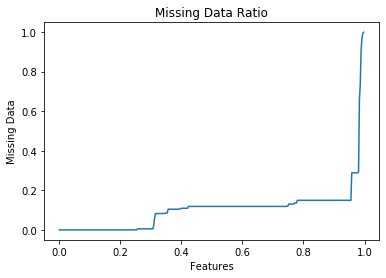

In [10]:
x = np.array(list(range(len(df_desc))))/len(df_desc)
y = np.array(sorted(1-df_desc.Count/df_desc.Count.max()))
ax = sns.lineplot(x, y)
ax.set_ylabel('Missing Data')
ax.set_xlabel('Features')
_ = ax.set_title('Missing Data Ratio')

### Data Attributes Transformation Table
For more information about the columns depicted in the files, two Excel spreadsheets were provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.
<br>
In order to help with data processing, a companion table was generated based on `DIAS Attributes - Values 2017.xlsx` data dictionary.<br>
The `AZDIAS_Attributes_dd.csv` provides new names (since original names were in German), feature type / processing instructions and valid ranges for every feature and shall be used for the pre-processing stage.

In [11]:
# read attributes companion table with new feature names and pre-processing rules
attributes_df = pd.read_csv('AZDIAS_Attributes_dd.csv')
attributes_df.head()

Feature                     Renaming  \
0       GEBAEUDETYP              B_BUILDING_TYPE   
1          BIP_FLAG         B_COMPANIES_BUILDING   
2       KONSUMNAEHE  B_DISTANCE_TO_POINT_OF_SALE   
3  MIN_GEBAEUDEJAHR                 B_FIRST_YEAR   
4      ANZ_HH_TITEL     B_NUM_ACADEMICS_BUILDING   

                                         Description ProcessingFn Arg1  Arg2  
0       type of building (residential or commercial)  categorical    1   8.0  
1  business-flag indicating companies in the buil...  categorical    0   1.0  
2    distance from a building to PoS (Point of Sale)      ordinal    0   5.0  
3  year the building was first mentioned in our d...         drop  NaN   NaN  
4        number of academic title holder in building      numeric    0   NaN

Match features from Data Dictionary against Dataset, looking for unmapped features

In [12]:
# identify features correctly and incorrectly mapped in data dictionary
unlisted_features = []
listed_features = []
for column in azdias.columns:
    # handle features correctly listed on data dictionary
    if column in attributes_df.Feature.values:
        listed_features.append(column)
    # handle features incorreclty listed on data dictionary (missing a _RZ suffix)
    elif column+'_RZ' in attributes_df.Feature.values:
        print('Name mismatch:  RZ %s' % column)
        # retrive intended configuration
        config = attributes_df.loc[attributes_df.Feature == column+'_RZ']
        new_name = config.Renaming.values[0]
        proc_fn = config.ProcessingFn.values[0]
        arg1 = config.Arg1.values[0]
        arg2 = config.Arg2.values[0]
        # update attributes table
        attributes_df.loc[attributes_df.index.max() + 1] = [column, new_name, '', proc_fn, arg1, arg2]

        listed_features.append(column)
    # handle features unlisted
    else:
        print('Feature not listed: %s' % column)
        unlisted_features.append(column)

Feature not listed: LNR
Feature not listed: AKT_DAT_KL
Feature not listed: ALTER_KIND1
Feature not listed: ALTER_KIND2
Feature not listed: ALTER_KIND3
Feature not listed: ALTER_KIND4
Feature not listed: ALTERSKATEGORIE_FEIN
Feature not listed: ANZ_KINDER
Feature not listed: ANZ_STATISTISCHE_HAUSHALTE
Feature not listed: ARBEIT
Feature not listed: CAMEO_INTL_2015
Feature not listed: CJT_KATALOGNUTZER
Feature not listed: CJT_TYP_1
Feature not listed: CJT_TYP_2
Feature not listed: CJT_TYP_3
Feature not listed: CJT_TYP_4
Feature not listed: CJT_TYP_5
Feature not listed: CJT_TYP_6
Name mismatch:  RZ D19_BANKEN_DIREKT
Name mismatch:  RZ D19_BANKEN_GROSS
Name mismatch:  RZ D19_BANKEN_LOKAL
Name mismatch:  RZ D19_BANKEN_REST
Name mismatch:  RZ D19_BEKLEIDUNG_GEH
Name mismatch:  RZ D19_BEKLEIDUNG_REST
Name mismatch:  RZ D19_BILDUNG
Name mismatch:  RZ D19_BIO_OEKO
Feature not listed: D19_BUCH_CD
Name mismatch:  RZ D19_DIGIT_SERV
Name mismatch:  RZ D19_DROGERIEARTIKEL
Name mismatch:  RZ D19_ENERG

In [13]:
attributes_df.tail()

Feature                       Renaming Description  \
342     D19_TIERARTIKEL              T_ACTIVITY_ANIMAL               
343    D19_VERSAND_REST   T_ACTIVITY_FURTHER_MAILORDER               
344  D19_VERSICHERUNGEN          T_ACTIVITY_INSURANCES               
345   D19_VOLLSORTIMENT  T_ACTIVITY_COMPLETE_MAILORDER               
346   D19_WEIN_FEINKOST   T_ACTIVITY_WINE_GOURMET_FOOD               

    ProcessingFn Arg1  Arg2  
342  categorical    1   7.0  
343  categorical    1   9.0  
344  categorical    1   9.0  
345  categorical    1   7.0  
346  categorical    1   7.0

Identify Features from Data Dictionary not present in the dataset

In [14]:
# features documented but not present in the dataset
unseen_attrs = set(attributes_df.Feature.values)-set(listed_features)
attributes_df[attributes_df.Feature.isin(unseen_attrs)].drop('Description', axis=1)

Feature                        Renaming ProcessingFn  \
1                     BIP_FLAG            B_COMPANIES_BUILDING  categorical   
6                    SOHO_FLAG                          B_SOHO  categorical   
9           CAMEO_DEUINTL_2015                     C_CAMEO_INT  categorical   
12            D19_KK_KUNDENTYP                  C_MOVEMENT_12M  categorical   
24           HAUSHALTSSTRUKTUR                    HH_STRUCTURE  categorical   
29          WACHSTUMSGEBIET_NB                NH_5YEARS_GROWTH  categorical   
61         KBA13_CCM_1400_2500      NH_CARS_CCM_1400_2499_PLZ8      ordinal   
212              GEOSCORE_KLS7                NH_SOLVENCY_RISK      ordinal   
255            D19_SONSTIGE_RZ            T_ACTIVITY_ALL_OTHER  categorical   
256         D19_TIERARTIKEL_RZ               T_ACTIVITY_ANIMAL  categorical   
259        D19_BANKEN_GROSS_RZ            T_ACTIVITY_BIG_BANKS  categorical   
260                D19_BUCH_RZ            T_ACTIVITY_BOOKS_CDS  categorical   
261       D19_KINDERARTIKEL_RZ             T_ACTIVITY_CHILDREN  categorical   
262       D19_SAMMELARTIKEL_RZ    T_ACTIVITY_COLLECTABLE_ITEMS  categorical   
263       D19_VOLLSORTIMENT_RZ   T_ACTIVITY_COMPLETE_MAILORDER  categorical   
264            D19_KOSMETIK_RZ             T_ACTIVITY_COSMETIC  categorical   
265  D19_NAHRUNGSERGAENZUNG_RZ  T_ACTIVITY_DIETARY_SUPPLEMENTS  categorical   
266          D19_DIGIT_SERV_RZ     T_ACTIVITY_DIGITAL_SERVICES  categorical   
267       D19_BANKEN_DIREKT_RZ         T_ACTIVITY_DIRECT_BANKS  categorical   
268            D19_HANDWERK_RZ                  T_ACTIVITY_DIY  categorical   
269     D19_DROGERIEARTIKEL_RZ           T_ACTIVITY_DRUGSTORES  categorical   
270            D19_BIO_OEKO_RZ          T_ACTIVITY_ECOLOGICALS  categorical   
271             D19_BILDUNG_RZ            T_ACTIVITY_EDUCATION  categorical   
272             D19_ENERGIE_RZ               t_ACTIVITY_ENERGY  categorical   
273        D19_LEBENSMITTEL_RZ                 T_ACTIVITY_FOOD  categorical   
274         D19_BANKEN_REST_RZ        T_ACTIVITY_FURTHER_BANKS  categorical   
275     D19_BEKLEIDUNG_REST_RZ     T_ACTIVITY_FURTHER_CLOTHING  categorical   
276        D19_VERSAND_REST_RZ    T_ACTIVITY_FURTHER_MAILORDER  categorical   
277          D19_TELKO_REST_RZ       T_ACTIVITY_FURTHER_MOBILE  categorical   
278              D19_GARTEN_RZ            T_ACTIVITY_GARDENING  categorical   
279            D19_RATGEBER_RZ           T_ACTIVITY_GUIDEBOOKS  categorical   
280           D19_HAUS_DEKO_RZ          T_ACTIVITY_HOUSE_DECOR  categorical   
281      D19_VERSICHERUNGEN_RZ           T_ACTIVITY_INSURANCES  categorical   
284            D19_FREIZEIT_RZ              T_ACTIVITY_LEISURE  categorical   
285        D19_BANKEN_LOKAL_RZ          T_ACTIVITY_LOCAL_BANKS  categorical   
286               D19_LOTTO_RZ                T_ACTIVITY_LOTTO  categorical   
287      D19_BEKLEIDUNG_GEH_RZ      T_ACTIVITY_LUXURY_CLOTHING  categorical   
290        D19_TELKO_MOBILE_RZ               T_ACTIVITY_MOBILE  categorical   
291              D19_SCHUHE_RZ                T_ACTIVITY_SHOES  categorical   
292             D19_TECHNIK_RZ           T_ACTIVITY_TECHNOLOGY  categorical   
297              D19_REISEN_RZ       T_ACTIVITY_TRAVEL_RELATED  categorical   
298       D19_WEIN_FEINKOST_RZ    T_ACTIVITY_WINE_GOURMET_FOOD  categorical   

    Arg1  Arg2  
1      0   1.0  
6      0   1.0  
9     11  55.0  
12     1   6.0  
24     1   9.0  
29     1   5.0  
61     0   5.0  
212    1   7.0  
255    1   7.0  
256    1   7.0  
259    1   7.0  
260    1   7.0  
261    1   7.0  
262    1   7.0  
263    1   7.0  
264    1   7.0  
265    1   7.0  
266    1   7.0  
267    1   7.0  
268    1   7.0  
269    1   7.0  
270    1   7.0  
271    1   7.0  
272    1   7.0  
273    1   7.0  
274    1   7.0  
275    1   7.0  
276    1   9.0  
277    1   7.0  
278    1   7.0  
279    1   7.0  
280    1   7.0  
281    1   9.0  
284    1   7.0  
285    1   7.0  
286    1   7.

List of features and transformations identified through translation and inspection of existing feature for typos and similarities

In [15]:
discovered = \
[
    ['D19_BUCH_CD',  'T_ACTIVITY_BOOKS_CDS', 'categorical', 1, 7],
    ['D19_SOZIALES',  'T_ACTIVITY_SOCIAL', 'categorical', 1, 7],

    ['D19_TELKO_ONLINE_QUOTE_12', 'T_AMOUNT_ONLINE_TELKO_12M', 'numeric', 0 , 10],
    ['D19_VERSI_DATUM', 'T_ACTUALITY_INSURANCE', 'categorical', 0, 9],
    ['D19_VERSI_OFFLINE_DATUM', 'T_ACTUALITY_INSURANCE_OFFLINE', 'categorical', 1, 9],
    ['D19_VERSI_ONLINE_DATUM', 'T_ACTUALITY_INSURANCE_ONLINE', 'categorical', 1, 9],
    ['D19_VERSI_ONLINE_QUOTE_12', 'T_AMOUNT_ONLINE_INSURANCE_12M', 'numeric', 0 , 10],

    ['KBA13_BAUMAX', 'NH_CARS_BAUMAX_PLZ8', 'ordinal', 0 , 5],
    ['KBA13_GBZ', 'NH_CARS_GBZ_PLZ8', 'ordinal', 0 , 5],
    ['KBA13_HHZ', 'NH_CARS_HHZ_PLZ8', 'ordinal', 0 , 5],  
    ['KBA13_CCM_1401_2500', 'NH_CARS_CCM_1401_2500_PLZ8', 'ordinal', 0 , 5],
    ['KBA13_KMH_210', 'NH_CARS_SPEED_110_210_PLZ8', 'ordinal', 0 , 5],

    ['KK_KUNDENTYP', 'C_MOVEMENT_12M', 'categorical', 1, 6],
]

Features documented but not present on dataset (unseen features)

In [16]:
unseen_attrs

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

Drop unseen features

In [17]:
attributes_df = attributes_df[~attributes_df.Feature.isin(unseen_attrs)].copy()

List off features with unknown information
- It will be required to look at data stats for these features in order to define transformation strategies

In [18]:
unknown = \
[
    ['AKT_DAT_KL', 'AKT_DAT_KL'],
    ['ALTER_KIND1', 'P_AGE_KIND_1'],
    ['ALTER_KIND2', 'P_AGE_KIND_2'],
    ['ALTER_KIND3', 'P_AGE_KIND_3'],
    ['ALTER_KIND4', 'P_AGE_KIND_4'],
    ['ALTERSKATEGORIE_FEIN', 'P_AGE_GROUP_FINE'],  
    ['ANZ_KINDER', 'NUM_CHILDREN'],
    ['ANZ_STATISTISCHE_HAUSHALTE', 'HH_HOUSEHOLD_STATS'],
    ['ARBEIT', 'JOB'],
    ['CAMEO_INTL_2015', 'C_CAMEO_INT_2015'],
    ['CJT_KATALOGNUTZER', 'C_CATALOG_USER'],
    ['CJT_TYP_1', 'C_TYPE_1'],
    ['CJT_TYP_2', 'C_TYPE_2'],
    ['CJT_TYP_3', 'C_TYPE_3'],
    ['CJT_TYP_4', 'C_TYPE_4'],
    ['CJT_TYP_5', 'C_TYPE_5'],
    ['CJT_TYP_6', 'C_TYPE_6'],
    ['D19_KONSUMTYP_MAX', 'T_CONSUMPTION_TYPE'],
    ['D19_LETZTER_KAUF_BRANCHE', 'T_LAST_PURCHASE_INDUSTRY'],
    ['DSL_FLAG', 'DSL_FLAG'],
    ['EINGEFUEGT_AM', 'INSERTED_AT'],
    ['EINGEZOGENAM_HH_JAHR', 'HH_RECOVERED_YEAR'],
    ['EXTSEL992', 'EXTSEL992'],
    ['FIRMENDICHTE', 'NH_COMPANY_DENSITY'],
    ['GEMEINDETYP', 'NH_COMMUNITY_TYPE'],
    ['HH_DELTA_FLAG', 'HH_DELTA_FLAG'],
    ['KBA13_ANTG1', 'NH_CARS_ANTG_1'],
    ['KBA13_ANTG2', 'NH_CARS_ANTG_2'],
    ['KBA13_ANTG3', 'NH_CARS_ANTG_3'],
    ['KBA13_ANTG4', 'NH_CARS_ANTG_4'],
    ['KONSUMZELLE', 'C_CONSUMER_CELL'],
    ['KOMBIALTER', 'KOMBIALTER'],
    ['MOBI_RASTER', 'MOBI_RASTER'],
    ['RT_KEIN_ANREIZ', 'RT_KEIN_ANREIZ'],
    ['RT_SCHNAEPPCHEN', 'RT_SCHNAEPPCHEN'],
    ['RT_UEBERGROESSE', 'RT_UEBERGROESSE'],
    ['SOHO_KZ', 'SOHO_KZ'],
    ['STRUKTURTYP', 'STRUKTURTYP'],
    ['UMFELD_ALT', 'UMFELD_ALT'],
    ['UMFELD_JUNG', 'UMFELD_JUNG'],
    ['UNGLEICHENN_FLAG', 'UNGLEICHENN_FLAG'],
    ['VHA', 'VHA'],
    ['VHN', 'VHN'],
    ['VK_ZG11', 'VK_ZG11'],  
    ['VK_DHT4A', 'VK_DHT4A'],
    ['VK_DISTANZ', 'VK_DISTANZ'],
    ['DSL_FLAG', 'DSL_FLAG'],
    ['EXTSEL992', 'EXTSEL992'],
    ['EINGEFUEGT_AM', 'EINGEFUEGT_AM'],
    ['EINGEZOGENAM_HH_JAHR', 'HH_RECOVERED_YEAR'],
    ['VERDICHTUNGSRAUM', 'COMPRESSION_AREA']
]

We'll look at the data stats for the unknown features and try to figure out their types

In [19]:
described_features = set(df_desc.Feature.values)
for feature_info in unknown:
    feature = feature_info[0]
    new_name = feature_info[1]
    
    if feature in described_features:
        print(feature, new_name, df_desc.loc[df_desc.Feature == feature].values[0][1:15])
    else:
        print('*', feature, new_name, azdias[feature].unique()[:15])

AKT_DAT_KL AKT_DAT_KL [817722.0 4.421928234779057 3.6388051405989175 1.0 1.0 3.0 9.0 9.0]
ALTER_KIND1 P_AGE_KIND_1 [81058.0 11.745392188309605 4.097660168396489 2.0 8.0 12.0 15.0 18.0]
ALTER_KIND2 P_AGE_KIND_2 [29499.0 13.402657717210753 3.243299583832402 2.0 11.0 14.0 16.0 18.0]
ALTER_KIND3 P_AGE_KIND_3 [6170.0 14.476012965964344 2.7124273453680323 4.0 13.0 15.0 17.0 18.0]
ALTER_KIND4 P_AGE_KIND_4 [1205.0 15.089626556016597 2.4529323986033713 7.0 14.0 15.0 17.0 18.0]
ALTERSKATEGORIE_FEIN P_AGE_GROUP_FINE [628274.0 13.70071656633889 5.079849414721193 0.0 11.0 14.0 17.0 25.0]
ANZ_KINDER NUM_CHILDREN [817722.0 0.1540181137354749 0.5023888663822523 0.0 0.0 0.0 0.0 11.0]
ANZ_STATISTISCHE_HAUSHALTE HH_HOUSEHOLD_STATS [798073.0 7.599356199244931 14.332201430756495 0.0 1.0 3.0 9.0 449.0]
ARBEIT JOB [794005.0 3.1678541067121744 1.0023762002559347 1.0 3.0 3.0 4.0 9.0]
* CAMEO_INTL_2015 C_CAMEO_INT_2015 [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0]
CJT_KATALOGNUTZER

#### Based on the data stats, translation and some fair reasoning, let's define the transformation functions for these unknown features

In [20]:
unknown = \
[
     ['LNR', 'INDEX', 'drop', None, None],
     ['AKT_DAT_KL', 'AKT_DAT_KL', 'categorical', 1, 9],
     ['ALTER_KIND1', 'P_AGE_KIND_1', 'categorical', 1, 18],
     ['ALTER_KIND2', 'P_AGE_KIND_2', 'categorical', 1, 18],
     ['ALTER_KIND3', 'P_AGE_KIND_3', 'categorical', 1, 18],
     ['ALTER_KIND4', 'P_AGE_KIND_4', 'categorical', 1, 18],
     ['ALTERSKATEGORIE_FEIN', 'P_AGE_GROUP_FINE', 'categorical', 1, 25],  
     ['ANZ_KINDER', 'NUM_CHILDREN', 'numeric', None, None],
     ['ANZ_STATISTISCHE_HAUSHALTE', 'HH_HOUSEHOLD_STATS', 'numeric', None, None],
     ['ARBEIT', 'JOB', 'categorical', 1, 9],
     ['CAMEO_INTL_2015', 'C_CAMEO_INT_2015', 'drop', None, None],
     ['CJT_KATALOGNUTZER', 'C_CATALOG_USER', 'categorical', 1, 5],
     ['CJT_TYP_1', 'C_TYPE_1', 'categorical', 1, 5],
     ['CJT_TYP_2', 'C_TYPE_2', 'categorical', 1, 5],
     ['CJT_TYP_3', 'C_TYPE_3', 'categorical', 1, 5],
     ['CJT_TYP_4', 'C_TYPE_4', 'categorical', 1, 5],
     ['CJT_TYP_5', 'C_TYPE_5', 'categorical', 1, 5],
     ['CJT_TYP_6', 'C_TYPE_6', 'categorical', 1, 5],
     ['D19_KONSUMTYP_MAX', 'T_CONSUMPTION_TYPE', 'categorical', 1, 9],
     ['D19_LETZTER_KAUF_BRANCHE', 'T_LAST_PURCHASE_INDUSTRY', 'drop', None, None],
     ['DSL_FLAG', 'DSL_FLAG', 'categorical', 0, 1],
     ['EINGEFUEGT_AM', 'INSERTED_AT', 'drop', None, None],
     ['EINGEZOGENAM_HH_JAHR', 'HH_RECOVERED_YEAR', 'numeric', None, None],
     ['EXTSEL992', 'EXTSEL992', 'numeric', None, None],
     ['FIRMENDICHTE', 'NH_COMPANY_DENSITY', 'categorical', 1, 5],
     ['GEMEINDETYP', 'NH_COMMUNITY_TYPE', 'ordinal', 11, 50],
     ['HH_DELTA_FLAG', 'HH_DELTA_FLAG', 'categorical', 0, 1],
     ['KBA13_ANTG1', 'NH_CARS_ANTG_1', 'categorical', 0, 4],
     ['KBA13_ANTG2', 'NH_CARS_ANTG_2', 'categorical', 0, 4],
     ['KBA13_ANTG3', 'NH_CARS_ANTG_3', 'categorical', 0, 4],
     ['KBA13_ANTG4', 'NH_CARS_ANTG_4', 'categorical', 0, 4],
     ['KONSUMZELLE', 'C_CONSUMER_CELL', 'categorical', 0, 4],
     ['KOMBIALTER', 'KOMBIALTER', 'categorical', 1, 9],
     ['MOBI_RASTER', 'MOBI_RASTER', 'categorical', 1, 6],
     ['RT_KEIN_ANREIZ', 'RT_KEIN_ANREIZ', 'categorical', 1, 5],
     ['RT_SCHNAEPPCHEN', 'RT_SCHNAEPPCHEN', 'categorical', 1, 5],
     ['RT_UEBERGROESSE', 'RT_UEBERGROESSE', 'categorical', 1, 5],
     ['SOHO_KZ', 'SOHO_KZ', 'categorical', 0, 1],
     ['STRUKTURTYP', 'STRUKTURTYP', 'categorical', 1, 3],
     ['UMFELD_ALT', 'UMFELD_ALT', 'categorical', 1, 5],
     ['UMFELD_JUNG', 'UMFELD_JUNG', 'categorical', 1, 5],
     ['UNGLEICHENN_FLAG', 'UNGLEICHENN_FLAG', 'categorical', 0, 1],
     ['VHA', 'VHA', 'categorical', 1, 5],
     ['VHN', 'VHN', 'categorical', 1, 4],
     ['VK_ZG11', 'VK_ZG11', 'categorical', 1, 11],  
     ['VK_DHT4A', 'VK_DHT4A', 'categorical', 1, 11],
     ['VK_DISTANZ', 'VK_DISTANZ', 'ordinal', 1, 13],
     ['DSL_FLAG', 'DSL_FLAG', 'categorical', 0, 1],
     ['EXTSEL992', 'EXTSEL992', 'numeric', None, None],
     ['EINGEZOGENAM_HH_JAHR', 'HH_RECOVERED_YEAR', 'numeric', None, None],
     ['VERDICHTUNGSRAUM', 'URBAN_AGGLOMERATION', 'numeric', None, None]
]

Update transformation table

In [21]:
for line in discovered:
    line = line.copy()
    line.insert(2, '')
    assert len(line) == 6, 'Invalid lenght for %s' % line
    attributes_df.loc[attributes_df.index.max() + 1] = line

for line in unknown:
    line = line.copy()
    line.insert(2, '')
    assert len(line) == 6, 'Invalid lenght for %s' % line
    attributes_df.loc[attributes_df.index.max() + 1] = line
    
attributes_df.tail()    

Feature             Renaming Description ProcessingFn  Arg1  \
406            VK_DISTANZ           VK_DISTANZ                  ordinal     1   
407              DSL_FLAG             DSL_FLAG              categorical     0   
408             EXTSEL992            EXTSEL992                  numeric  None   
409  EINGEZOGENAM_HH_JAHR    HH_RECOVERED_YEAR                  numeric  None   
410      VERDICHTUNGSRAUM  URBAN_AGGLOMERATION                  numeric  None   

     Arg2  
406  13.0  
407   1.0  
408   NaN  
409   NaN  
410   NaN

Save a fixed version of Attributes Transformations table

In [22]:
bucket.save_csv(attributes_df, 'DIAS_attribute_transformations.csv')

### Data pre-processing

In [23]:
set(azdias.columns.values)-set(attributes_df.Feature.values)

set()

Process raw data according to data dictionary transformations (Attributes Transformations table)
- this will take a while

In [26]:
azdias = processing.data_pre_processing(azdias, attributes_df)
sample = azdias.sample(7, random_state=42)
sample

P_ELDER_TYPOLOGY  AKT_DAT_KL  HH_MAIN_AGE  P_AGE_KIND_1  P_AGE_KIND_2  \
848815                 1           1           12            -1            -1   
299816                -1           1           -1            -1            -1   
570748                -1          -1           -1            -1            -1   
354371                -1          -1           16            -1            -1   
329018                -1          -1           -1            -1            -1   
49016                  1          -1           10            -1            -1   
454415                -1          -1           -1            -1            -1   

        P_AGE_KIND_3  P_AGE_KIND_4  P_AGE_GROUP_FINE  \
848815            -1            -1                12   
299816            -1            -1                21   
570748            -1            -1                -1   
354371            -1            -1                15   
329018            -1            -1                -1   
49016             -1            -1                10   
454415            -1            -1                -1   

        B_NUM_HOUSEHOLDS_BUILDING  B_NUM_ACADEMICS_BUILDING  ...  VHN  \
848815                        6.0                       1.0  ...    2   
299816                        1.0                       0.0  ...    1   
570748                        1.0                       0.0  ...    1   
354371                        1.0                       0.0  ...   -1   
329018                       -1.0                      -1.0  ...   -1   
49016                         1.0                       0.0  ...   -1   
454415                        1.0                       0.0  ...    2   

        VK_DHT4A  VK_DISTANZ  VK_ZG11  NH_CHILDREN_IN_NEIGHBORHOOD  \
848815         9          12       10                           -1   
299816         2           3        3                            3   
570748         8           9        6                           -1   
354371         2           3        4                            2   
329018        -1          -1       -1                           -1   
49016          9          10        7                           -1   
454415         8          11       10                            3   

        P_RESIDENCE_TIME NH_NEIGHBORHOOD_SCORE  C_ORIENTATION_TYPE  P_GENDER  \
848815                -1                     4                   3        -1   
299816                 8                     3                   1        -1   
570748                -1                     7                   1         1   
354371                -1                     3                   1         1   
329018                -1                    -1                   3        -1   
49016                  8                     3                   1         1   
454415                 7                     1                   3        -1   

        P_AGE_GROUP  
848815            3  
299816            2  
570748            1  
354371            3  
329018            3  
49016            -1  
454415            3  

[7 rows x 361 columns]

Save pre-processed data

In [27]:
bucket.save_parquet(azdias, 'Udacity_AZDIAS_052018_stg1.parquet', compression='gzip')

#### Visualize dataset after pre-processing

In [5]:
azdias = bucket.read_parquet('Udacity_AZDIAS_052018_stg1.parquet')
azdias.sample(7)

P_ELDER_TYPOLOGY  AKT_DAT_KL  HH_MAIN_AGE  P_AGE_KIND_1  P_AGE_KIND_2  \
351994                 2           5           10            -1            -1   
252916                -1           1           18            -1            -1   
614790                -1          -1           -1            -1            -1   
201129                -1           1           17            -1            -1   
633261                -1           1           -1            -1            -1   
40483                  2          -1           12            -1            -1   
787284                -1           6           16            -1            -1   

        P_AGE_KIND_3  P_AGE_KIND_4  P_AGE_GROUP_FINE  \
351994            -1            -1                10   
252916            -1            -1                18   
614790            -1            -1                -1   
201129            -1            -1                17   
633261            -1            -1                -1   
40483             -1            -1                12   
787284            -1            -1                16   

        B_NUM_HOUSEHOLDS_BUILDING  B_NUM_ACADEMICS_BUILDING  ...  VHN  \
351994                       92.0                       2.0  ...   -1   
252916                       11.0                       0.0  ...    3   
614790                        4.0                       0.0  ...    2   
201129                       52.0                       0.0  ...   -1   
633261                       13.0                       0.0  ...    2   
40483                         4.0                       0.0  ...    1   
787284                       30.0                       0.0  ...    1   

        VK_DHT4A  VK_DISTANZ  VK_ZG11  NH_CHILDREN_IN_NEIGHBORHOOD  \
351994        10          -1       10                           -1   
252916         9           9        6                            5   
614790         9          12       10                            3   
201129         6           9        8                           -1   
633261         8          11       10                           -1   
40483         10           9        6                           -1   
787284         9          11        8                            4   

        P_RESIDENCE_TIME NH_NEIGHBORHOOD_SCORE  C_ORIENTATION_TYPE  P_GENDER  \
351994                -1                     3                   3        -1   
252916                 8                     2                   5         1   
614790                -1                     3                   4        -1   
201129                 3                     2                   5         1   
633261                -1                     3                   3        -1   
40483                 -1                     4                  -1         1   
787284                -1                     4                  -1         1   

        P_AGE_GROUP  
351994           -1  
252916            2  
614790            2  
201129            2  
633261            3  
40483             3  
787284            1  

[7 rows x 361 columns]

## Part 1. EDA - Exploratory Data Analysis

#### Checking missing data

In [8]:
def compute_columns_null_percentage(df):
    """
    Computes the percentage of null (missing) values available in each  column
    ---
    Arguments
        df: pd.DataFrame
            A dataframe with data to be accessed
    Returns
        null_percentage: dictionary
            A dictionary containing pairs of column: percentage of null values
    """
    null_percentage = {}
    for column in df.columns.values:
        null_count = np.sum(df[column] == -1)
        null_percentage[column] = null_count / len(df)
        
    return null_percentage
    
def count_empty_columns(row):
    """
    Computes the percentage of empty columns for given row
    ---
    Arguments
        row: pd.Series
            A dataframe row with data to be accessed
    Returns
        emptyness: float
            The percentage of missing data in the row
    """              
    empty_count = np.sum(row == -1) + np.sum(row == 'nan')
    emptyness = empty_count/len(row)

    return emptyness

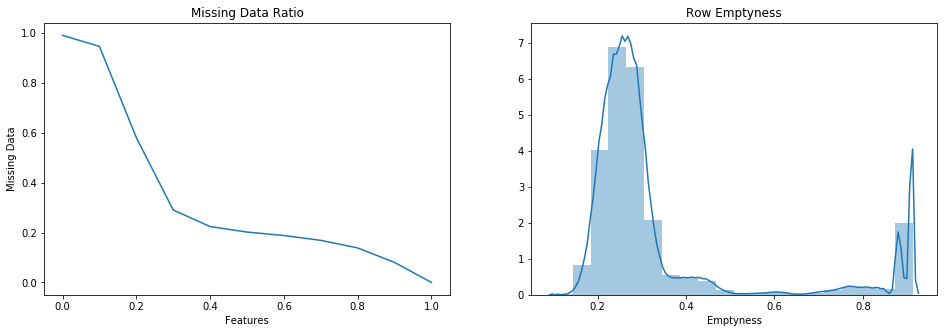

In [9]:
# compute percentage of missing values for columns
null_percentage = compute_columns_null_percentage(azdias)
# compute percentage of missing values for rows
azdias['Emptyness'] = azdias.apply(count_empty_columns, axis=1)

f, axes = plt.subplots(1,2, figsize=(16, 5))

X = [x/10 for x in range(0, 11)]
Y = [np.sum(np.array(list(null_percentage.values())) > x)/len(null_percentage) for x in X]
sns.lineplot(X, Y, ax=axes[0])
axes[0].set_ylabel('Missing Data')
axes[0].set_xlabel('Features')
axes[0].set_title('Missing Data Ratio')

sns.distplot(azdias['Emptyness'], bins=20, hist=True, ax=axes[1])
_ = axes[1].set_title('Row Emptyness')

We can observe that we have about 30% of features missing more than 40% of data. <br>
In addition, we can also observe a fair amount of rows with bad data

#### Detailed View of Missing Data using klib library

In [6]:
for column in azdias.columns.values:
    azdias.loc[azdias[column] == -1, column] = np.nan

GridSpec(6, 6)

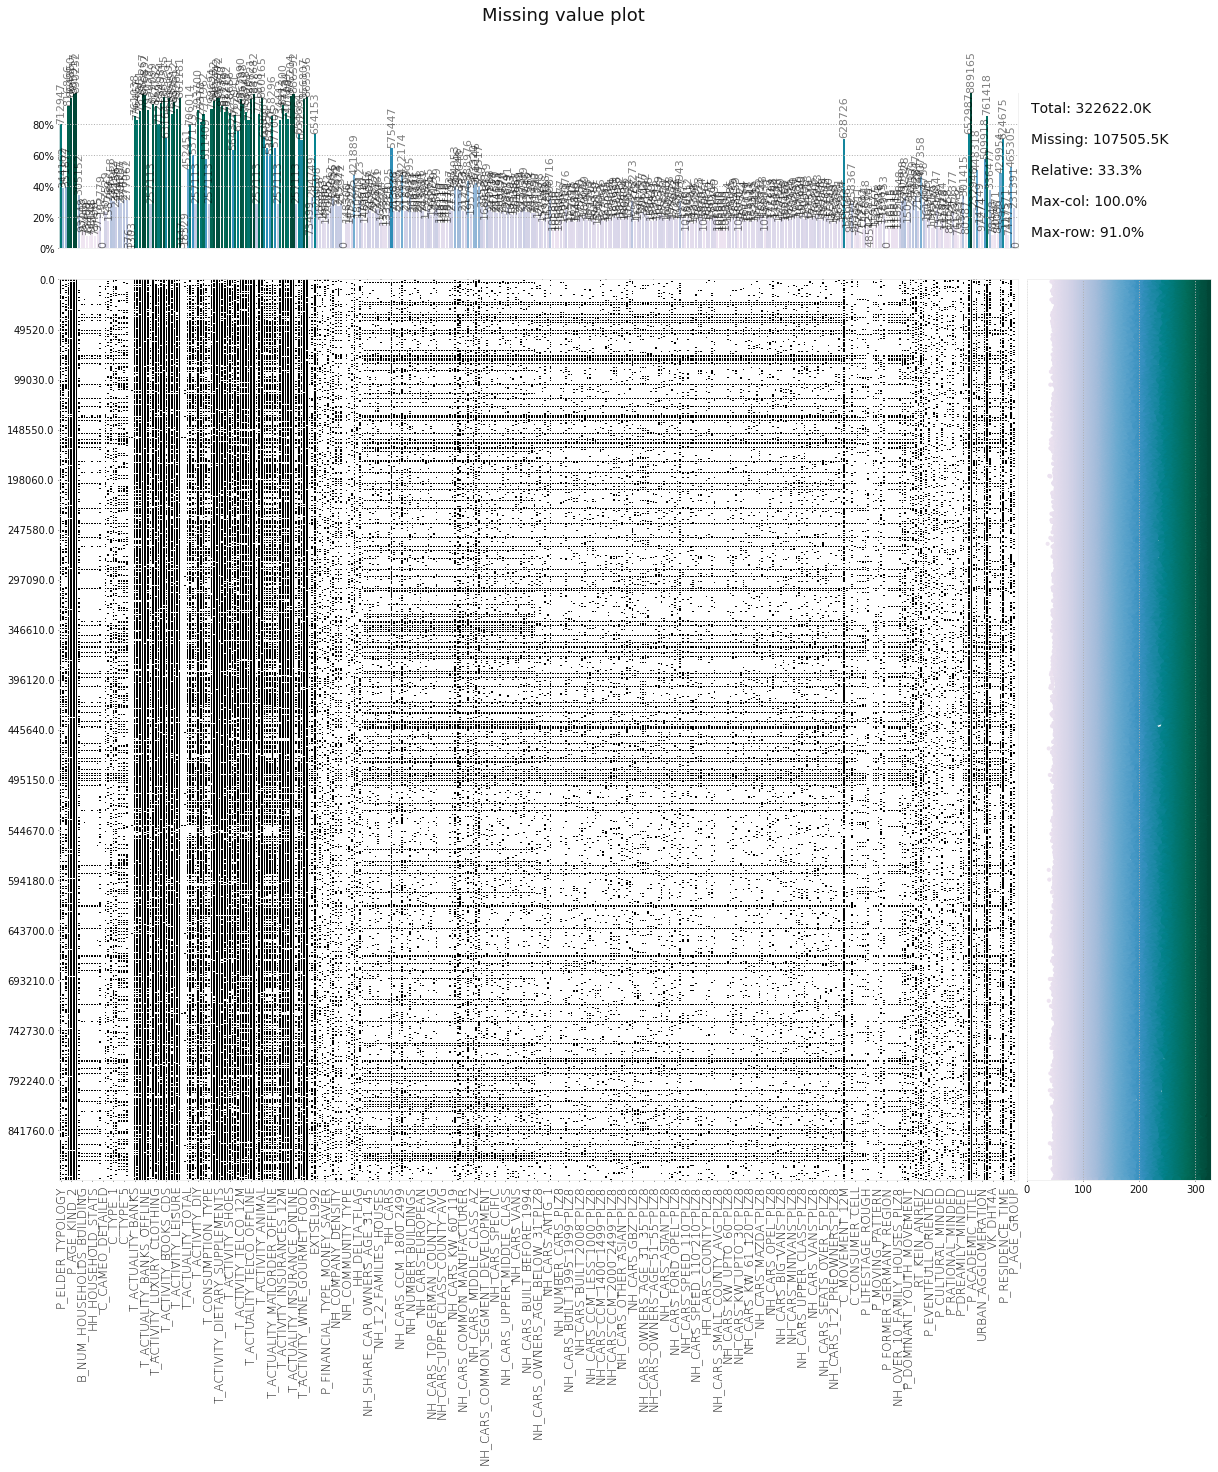

In [18]:
eda.missingval_plot(azdias)

It is hard to visualize this amount of features ... Let's try a tidy version

Displaying only columns with missing values.


GridSpec(6, 6)

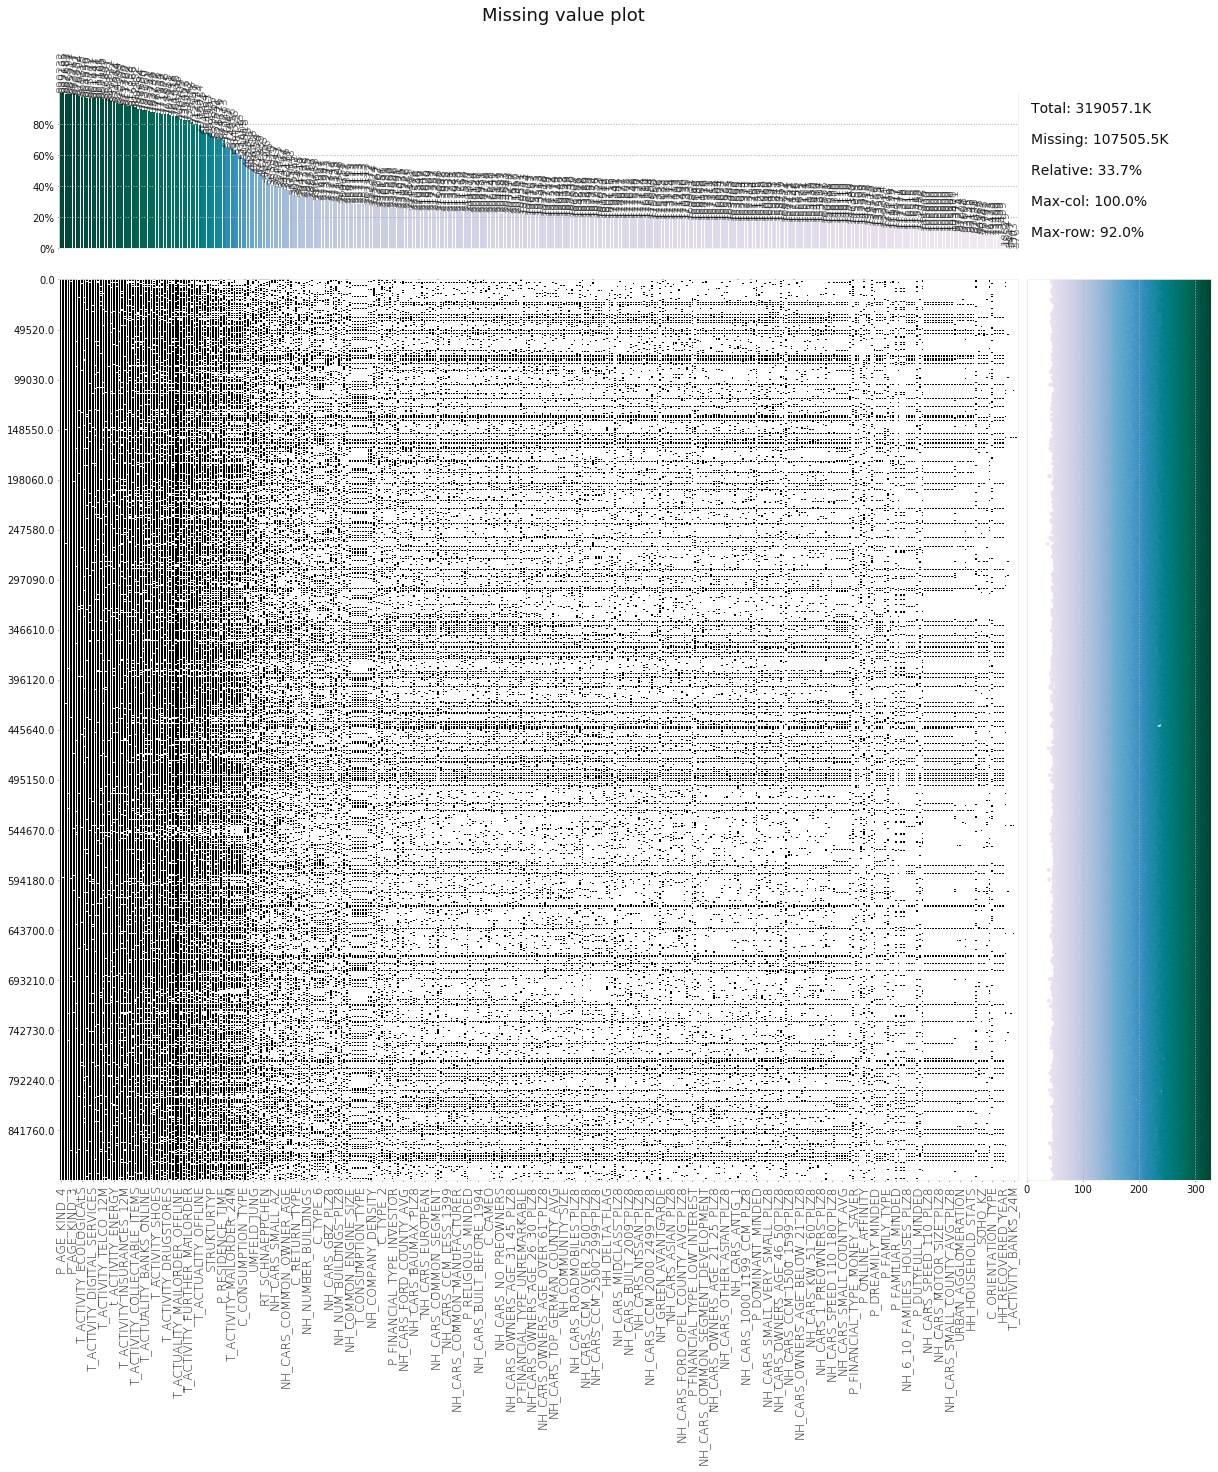

In [18]:
eda.missingval_plot(azdias, sort=True)

## Data Cleanup: 
Remove duplicated rows and drop columns and rows based on the missing values ratios
- threshold for columns: 0.5
- threshold for rows: 0.5

In [19]:
azdias.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 361 entries, P_ELDER_TYPOLOGY to P_AGE_GROUP
dtypes: float64(359), object(2)
memory usage: 2.5 GB


In [20]:
azdias = eda.data_cleaning(azdias, drop_threshold_cols=0.5, drop_threshold_rows=0.5)

Shape of cleaned data: (787617, 288) - Remaining NAs: 28170368

Changes:
Dropped rows: 103604
     of which 63 duplicates. (Rows: [62688, 63660, 97775, 149438, 151628, 187314, 189518, 193092, 200864, 237077, 244032, 262073, 264306, 278714, 281417, 285412, 287439, 294040, 318099, 348994, 349684, 359697, 359698, 372516, 393944, 402847, 439143, 445866, 447427, 447506, 450843, 468619, 473247, 477246, 497702, 511985, 566747, 578021, 580611, 591951, 593959, 626277, 630904, 632821, 636136, 646374, 673740, 678412, 682984, 744935, 766379, 800552, 810749, 831254, 835410, 839684, 845057, 845697, 852847, 859617, 872017, 887727, 890170])
Dropped columns: 73
     of which 0 single valued. (Columns: [])
Dropped missing values: 79335130
Reduced memory by at least: 1587.8 MB (-64.7%)


In [21]:
azdias.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787617 entries, 1 to 891220
Columns: 288 entries, AKT_DAT_KL to P_AGE_GROUP
dtypes: category(2), float32(286)
memory usage: 866.8 MB


After cleanup, 73 columns and 103604 rows (~ 12%) were dropped.

Save cleaned data

In [22]:
azdias.to_csv('Udacity_AZDIAS_052018_stg1.5.csv', index=False)

#### Save list of features of interest
Once we decided wich features to keep, we shall keep track of them in order to apply the same processing on additional data sets

In [25]:
processing.save_feature_set(azdias, attributes_df, label='features_of_interest')

### Data Imputation
Now that the data was pre-processed according to the data dictionary, it is time to perform imputation of missing values using the following criteria:
- numeric features: median value
- ordinal feature: median value
- categorical features: most frequent value

In [26]:
bucket = utils.BucketUtils(bucket_name = 'arvatos-capstone', prefix = 'data')

In [27]:
azdias = pd.read_csv('Udacity_AZDIAS_052018_stg1.5.csv')
attributes_df = bucket.read_csv('DIAS_attribute_transformations.csv')

In [29]:
# perform data imputation on missing values
azdias = processing.values_imputation(azdias, attributes_df, fit=True, nan_value=np.nan)
azdias.sample(7, random_state=42)

P_BIRTH_YEAR  NUM_CHILDREN  B_NUM_ACADEMICS_BUILDING  \
487778        1967.0           0.0                       0.0   
290516           0.0           0.0                       0.0   
511860        1951.0           0.0                       0.0   
511953        1937.0           0.0                       0.0   
727274        1974.0           0.0                       0.0   
133103        1951.0           0.0                       0.0   
131858        1955.0           0.0                       0.0   

        T_AMOUNT_ONLINE_INSURANCE_12M  T_AMOUNT_ONLINE_TOTAL_12M  \
487778                            0.0                        0.0   
290516                            0.0                       10.0   
511860                            0.0                        0.0   
511953                            0.0                       10.0   
727274                            0.0                       10.0   
133103                            0.0                       10.0   
131858                            0.0                       10.0   

        B_NUM_HOUSEHOLDS_BUILDING  T_AMOUNT_ONLINE_MAILORDER_12M  \
487778                        3.0                            0.0   
290516                       13.0                           10.0   
511860                        1.0                            0.0   
511953                        1.0                            0.0   
727274                       24.0                           10.0   
133103                        2.0                           10.0   
131858                        1.0                           10.0   

        HH_RECOVERED_YEAR  URBAN_AGGLOMERATION  HH_NUM_ADULTS  ...  \
487778             2005.0                  0.0            1.0  ...   
290516             1994.0                  3.0            2.0  ...   
511860             2004.0                  1.0            1.0  ...   
511953             1997.0                 18.0            1.0  ...   
727274             2012.0                  0.0            2.0  ...   
133103             1994.0                  0.0            3.0  ...   
131858             1998.0                  0.0            2.0  ...   

        VK_DISTANZ  NH_CARS_SPEED_110_210_PLZ8  NH_CARS_KW_71_80_PLZ8  \
487778         1.0                         2.0                    3.0   
290516         4.0                         3.0                    2.0   
511860        10.0                         4.0                    2.0   
511953         8.0                         3.0                    3.0   
727274         3.0                         3.0                    2.0   
133103         3.0                         4.0                    2.0   
131858         1.0                         3.0                    0.0   

        NH_CARS_MAZDA_PLZ8  NH_CARS_BUILT_2000_2003_PLZ8  \
487778                 3.0                           4.0   
290516                 4.0                           3.0   
511860                 3.0                           2.0   
511953                 4.0                           3.0   
727274                 3.0                           3.0   
133103                 4.0                           3.0   
131858                 2.0                           2.0   

        NH_CARS_SEATS_OVER_5_PLZ8  P_FIGHTFULL_ATTITUDE  \
487778                        3.0                   2.0   
290516                        3.0                   6.0   
511860                        3.0                   2.0   
511953                        3.0                   4.0   
727274                        4.0                   6.0   
133103                        4.0                   3.0   
131858                        1.0                   5.0   

        NH_CARS_BUILT_1994_2000  NH_CARS_UPPER_CLASS_AZ  \
487778                      3.0                     2.0   
290516                      3.0                     0.0   
511860                      3.0                     0.0   
511953                      3.0                     1.0   
727274    

### EDA after data cleanup and imputation

#### Numeric features

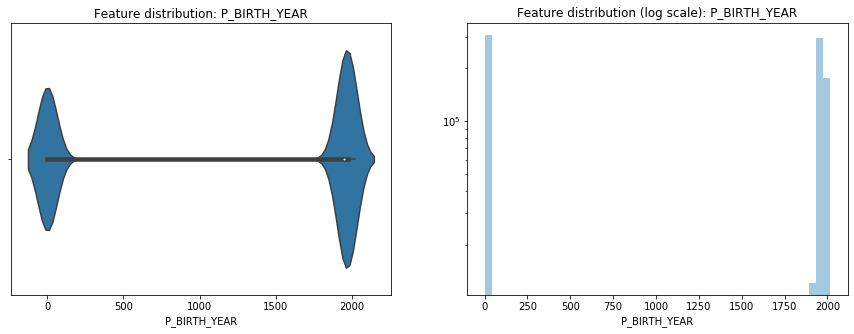

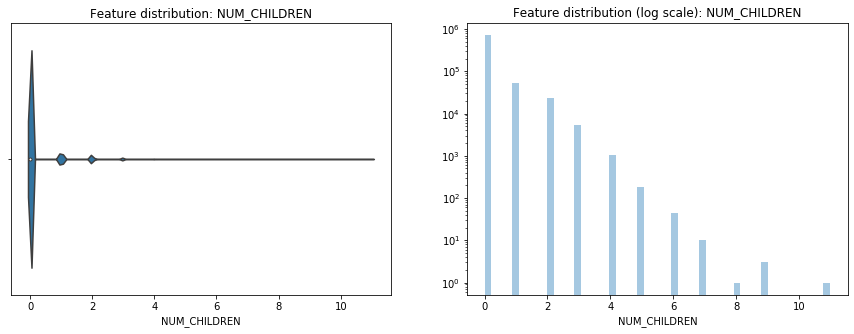

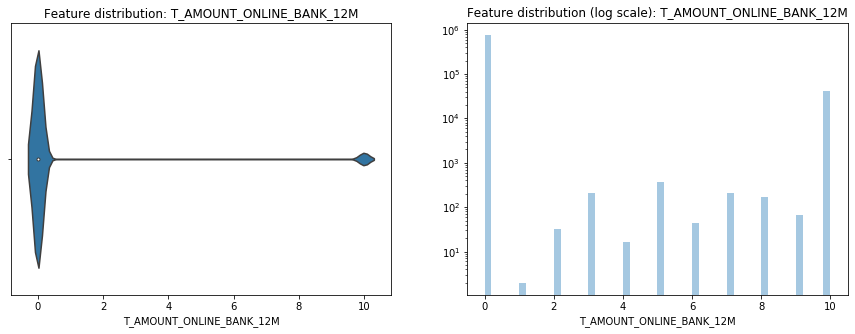

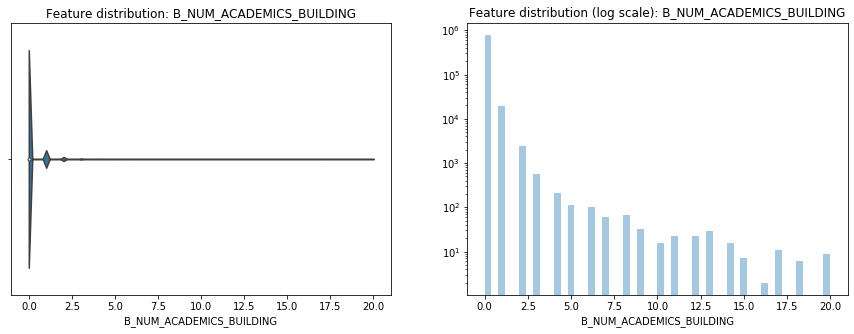

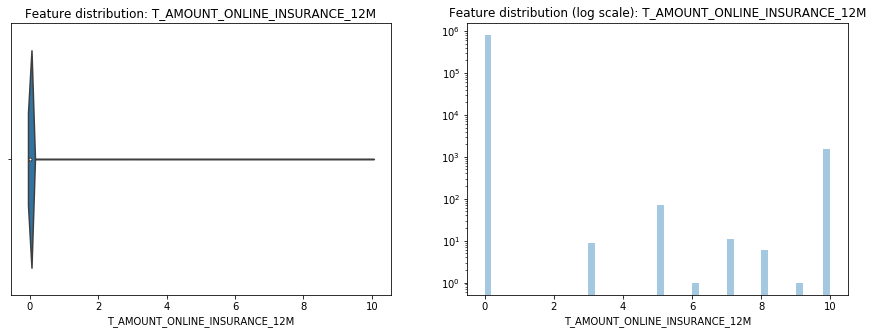

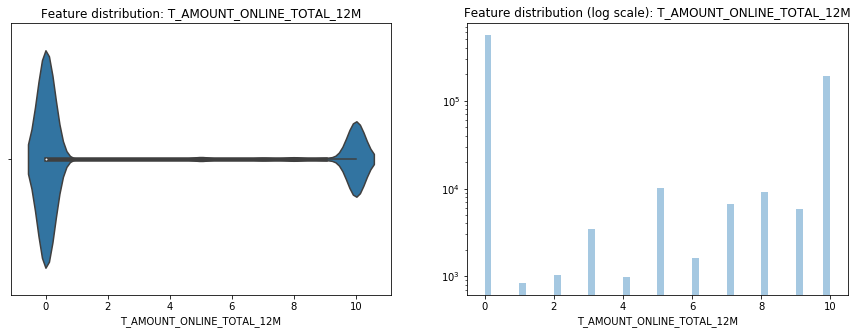

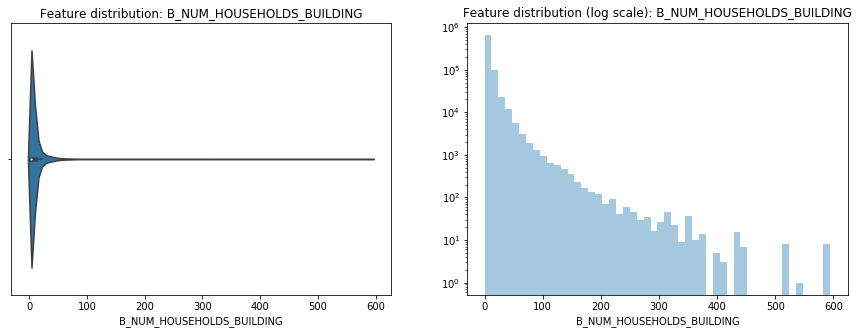

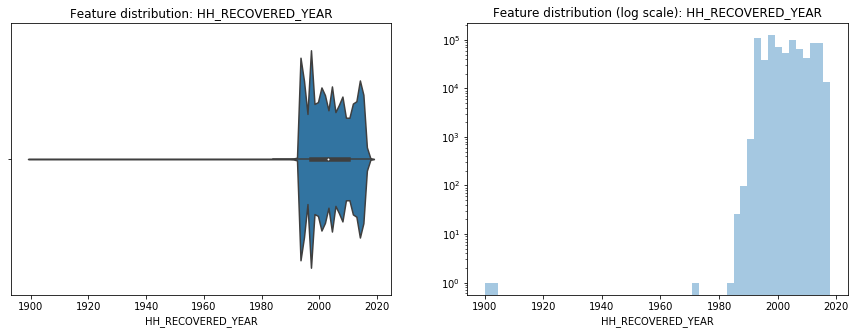

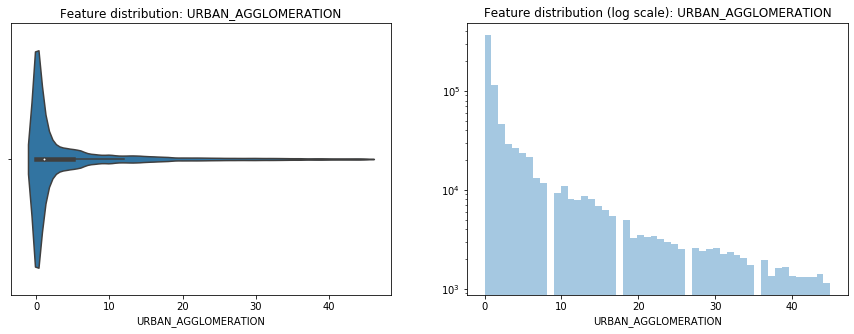

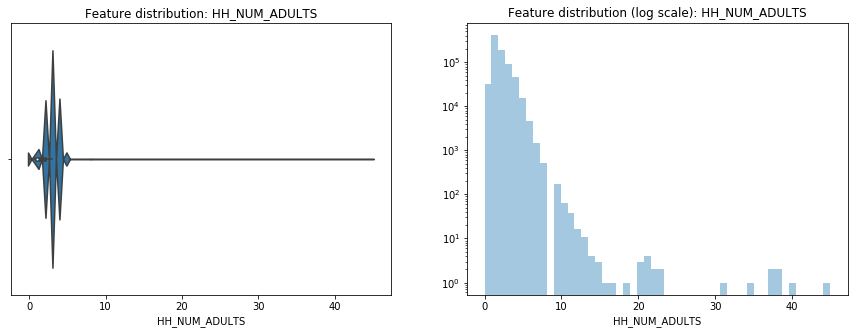

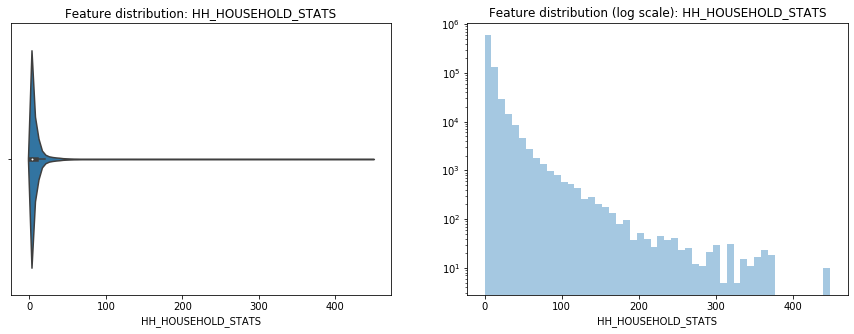

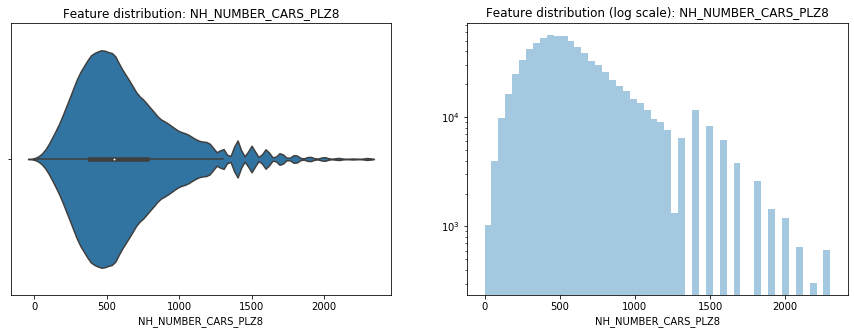

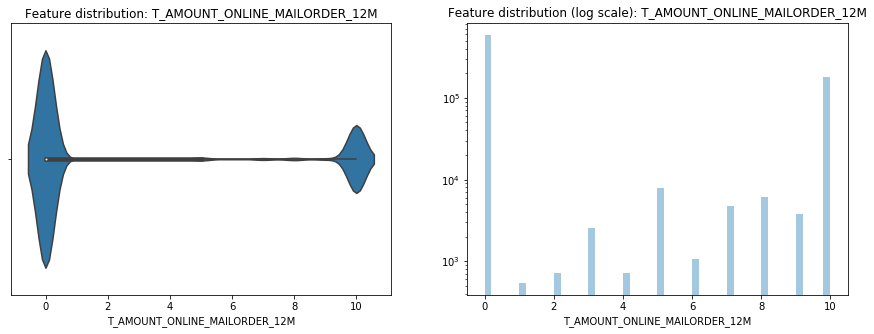

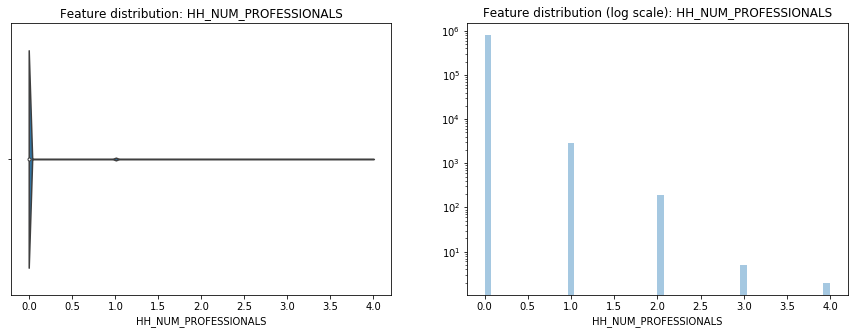

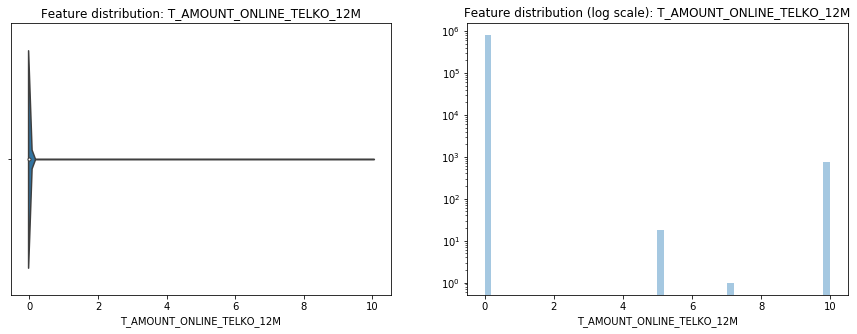

In [30]:
numeric_dataframe = processing.get_numeric_dataframe(azdias, attributes_df)
interval_cols = numeric_dataframe.columns.values

for col in interval_cols:
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    _ = sns.violinplot(azdias[col], ax=axes[0])
    _ = sns.distplot(azdias[col], kde=False, ax=axes[1])
    _ = axes[0].set_title('Feature distribution: %s' % col)
    _ = axes[1].set_title('Feature distribution (log scale): %s' % col)
    axes[1].set_yscale('log')
    plt.show()

Decided to drop `P_BIRTH_YEAR` wich contains obvious invalid data
- don't worry, we have additional age related features

In [31]:
azdias.drop(columns=['P_BIRTH_YEAR'], inplace=True)
post_imputation_drop_features = ['P_BIRTH_YEAR']

Another visualization of data distribution

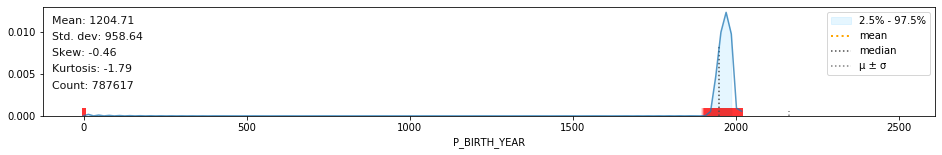

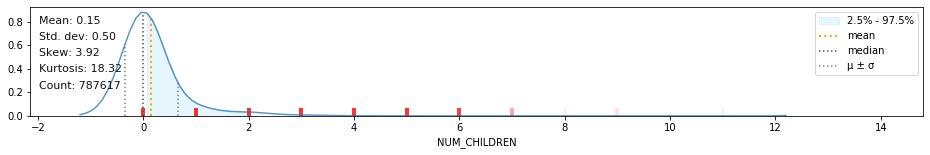

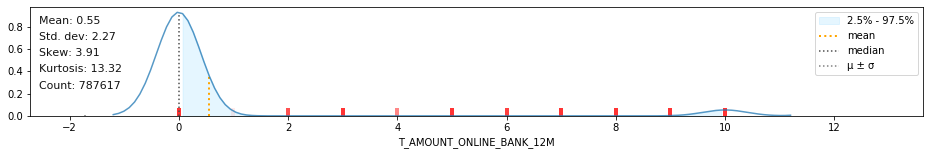

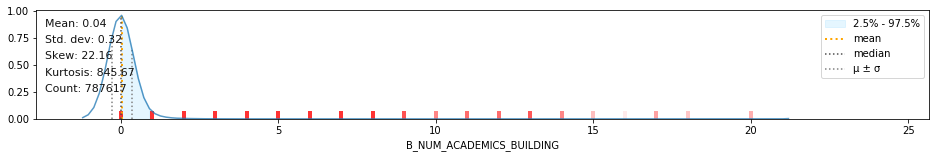

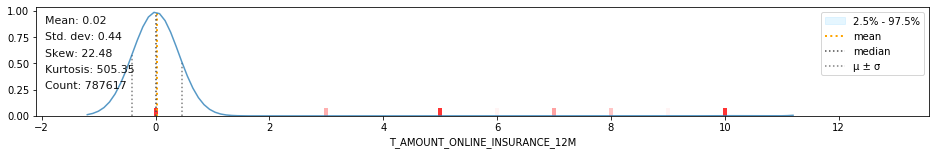

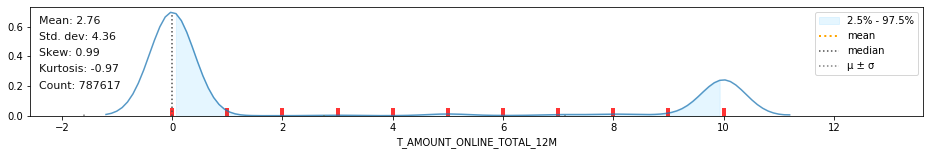

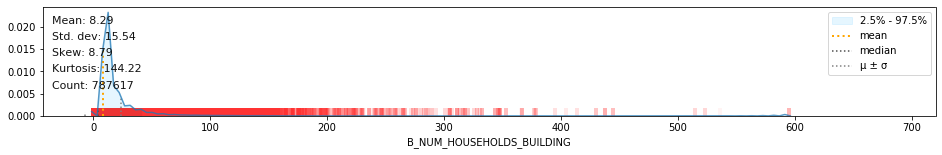

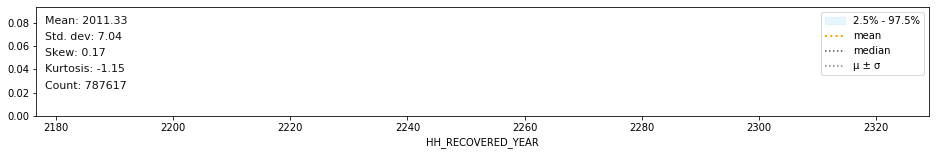

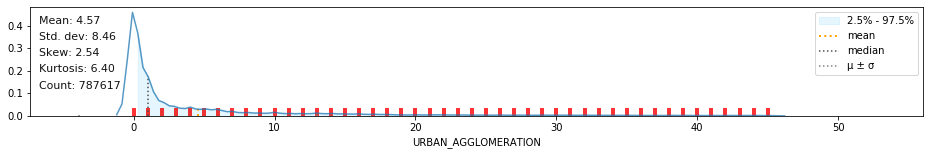

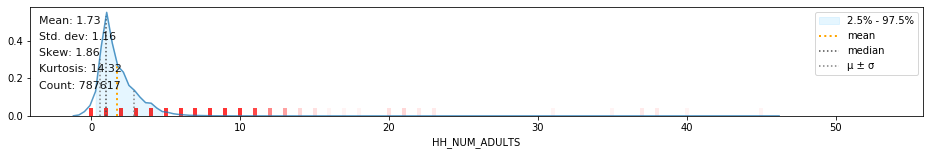

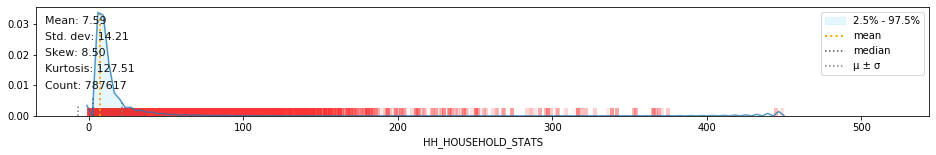

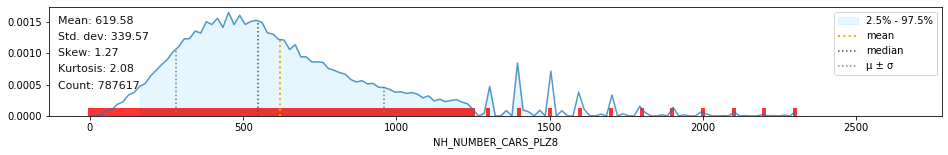

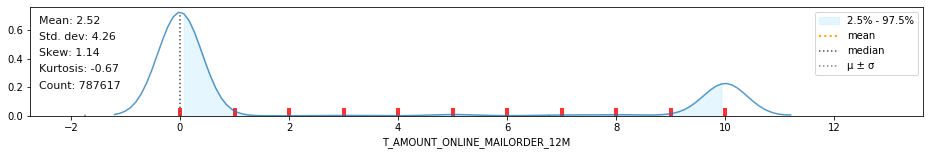

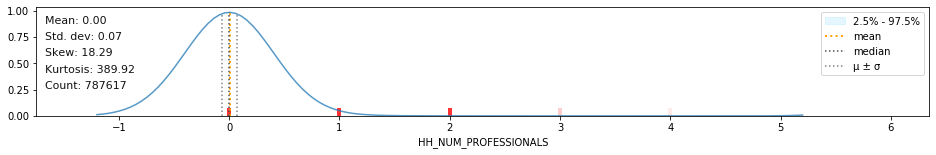

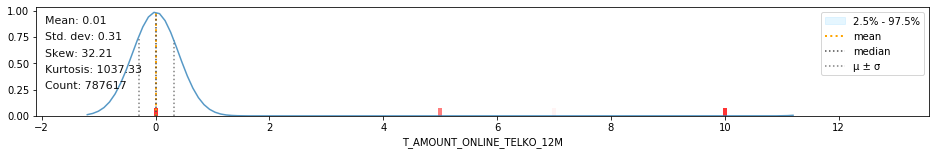

In [32]:
eda.dist_plot(numeric_dataframe)

Several numeric features have skewed distributions althought their ranges are usually contained to a a few orders of magnitude.<br>
Based on that, it won't be applied log transformations to any feature in particular. <br>
In addition, based on the skewness, feature normalization seems to be more suitable than standardization.

#### Feature Correlation for Numeric Features
Let's check for numeric features with high correlation

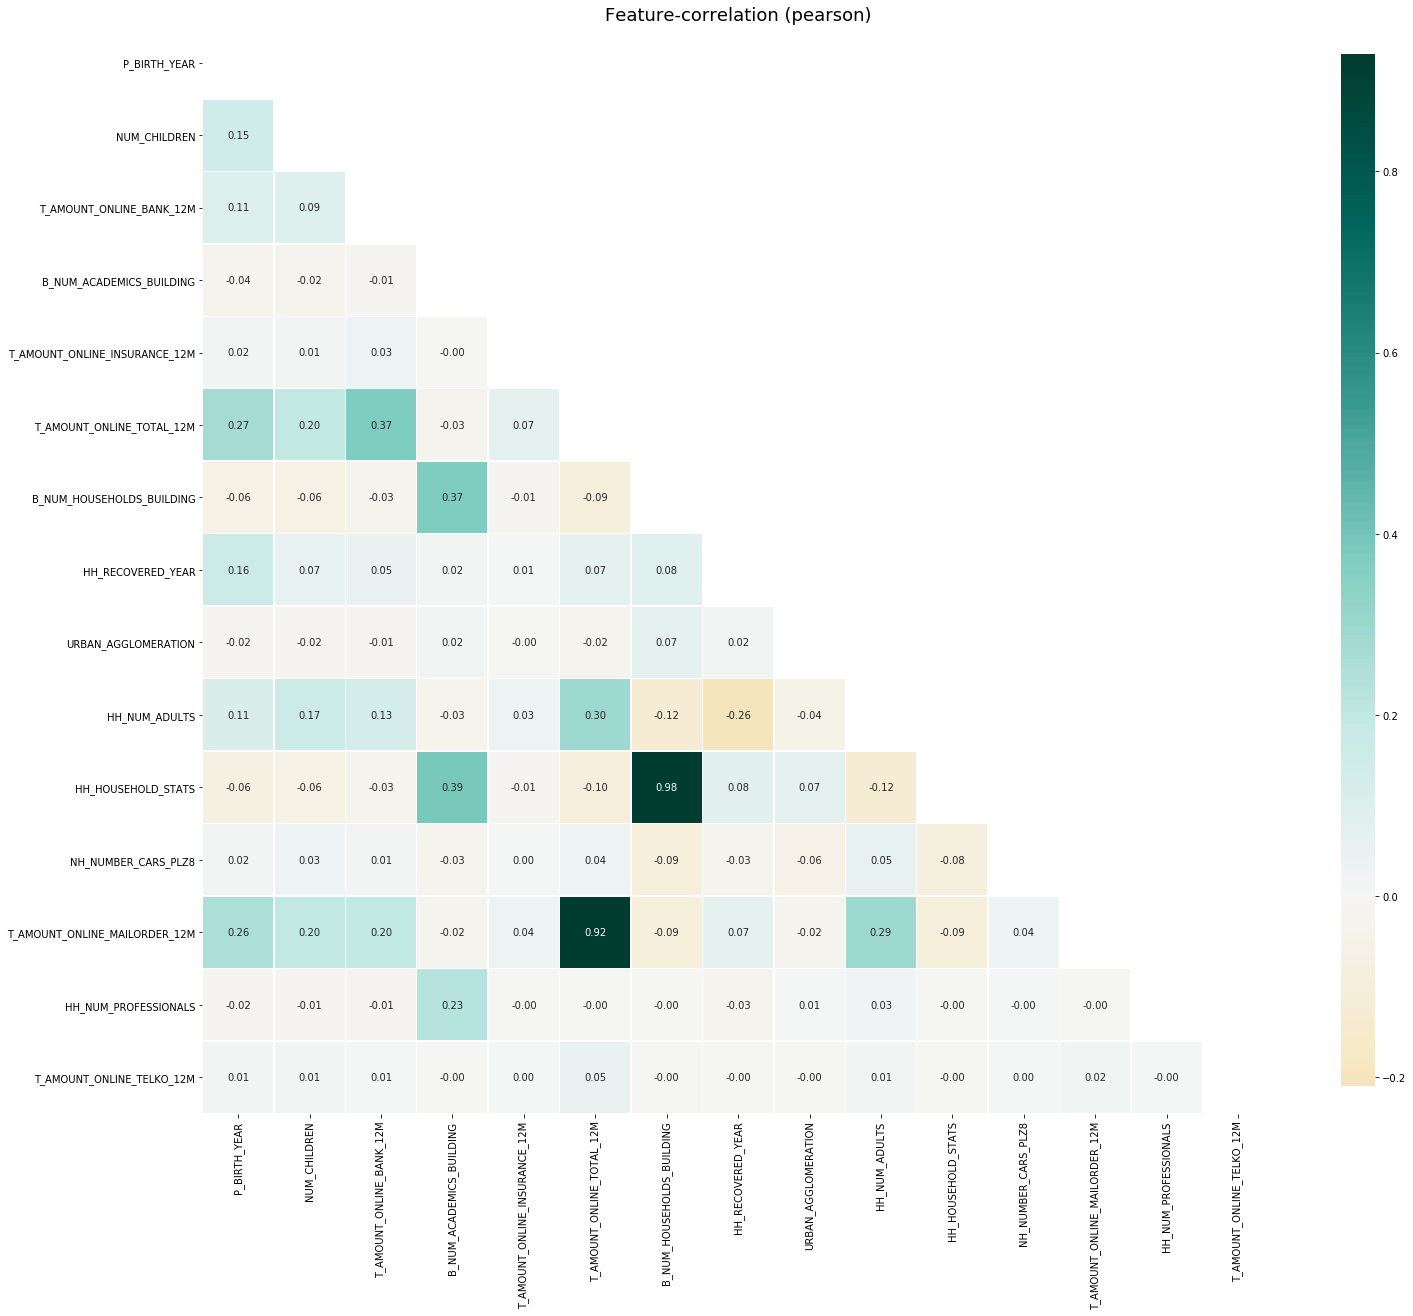

In [33]:
eda.corr_plot(numeric_dataframe, split='high', threshold=0.85, annot=True, figsize=(24, 20)) 

`T_AMOUNT_ONLINE_TOTAL_12M` has a high correlation with `T_AMOUNT_ONLINE_MAILORDER_12M` and the same goes to `B_NUM_HOUSEHOLDS_BUILDING` and `HH_HOUSEHOLD_STATS`. We shall drop one feature of each pair

In [34]:
azdias.drop(columns=['B_NUM_HOUSEHOLDS_BUILDING', 'T_AMOUNT_ONLINE_TOTAL_12M'], inplace=True)
post_imputation_drop_features.extend(['B_NUM_HOUSEHOLDS_BUILDING', 'T_AMOUNT_ONLINE_TOTAL_12M'])

In [35]:
del numeric_dataframe

#### Ordinal Features

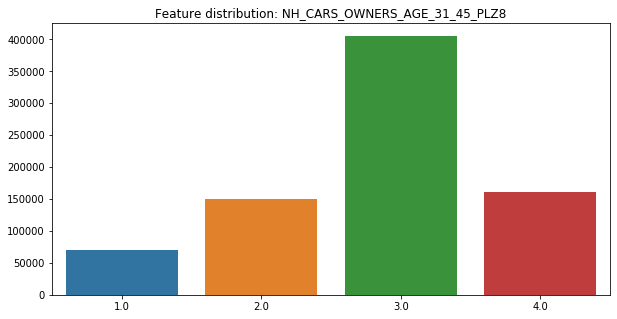

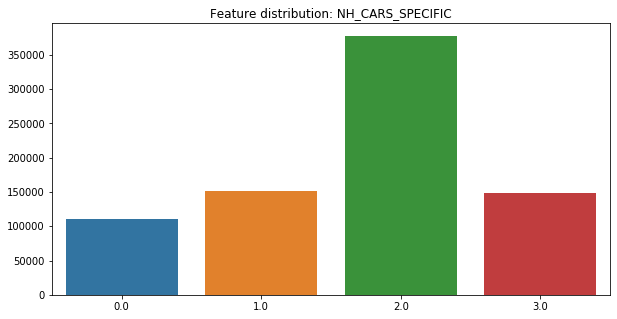

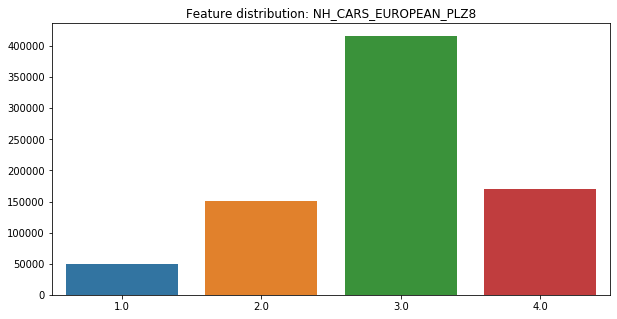

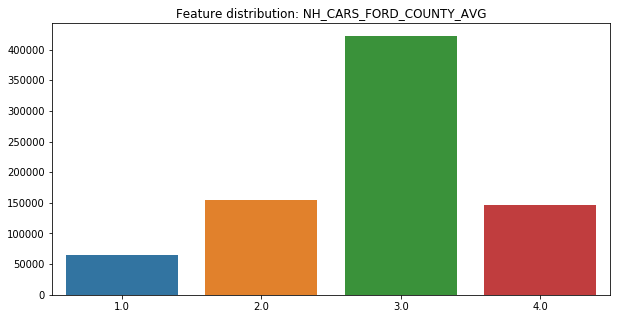

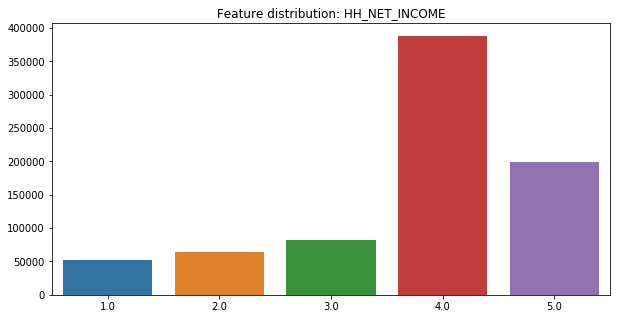

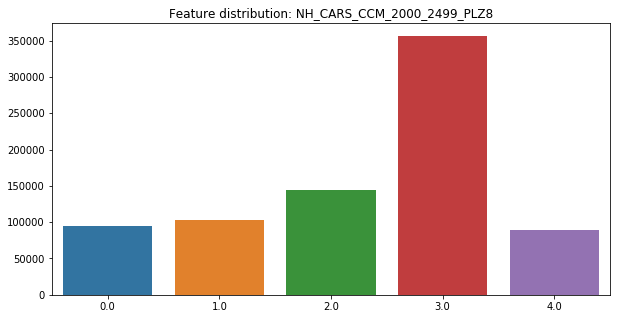

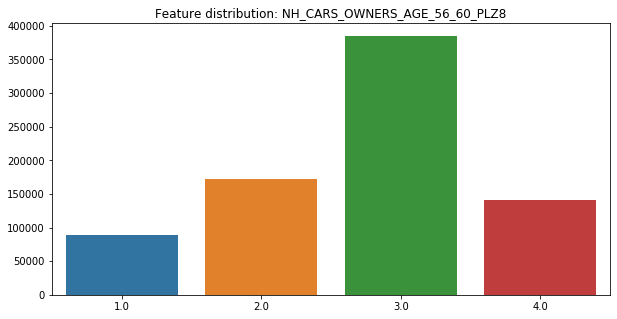

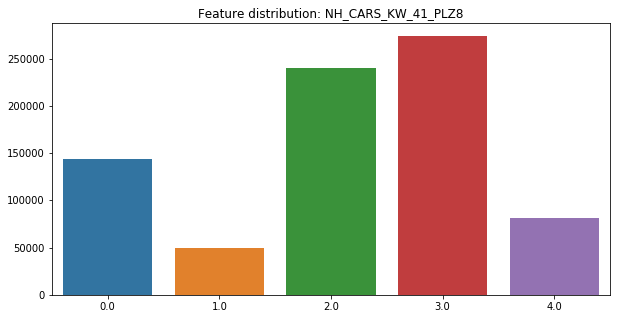

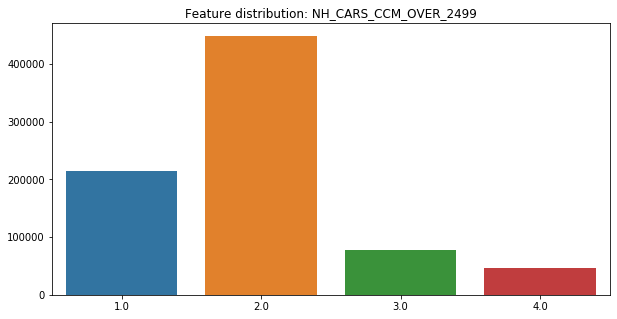

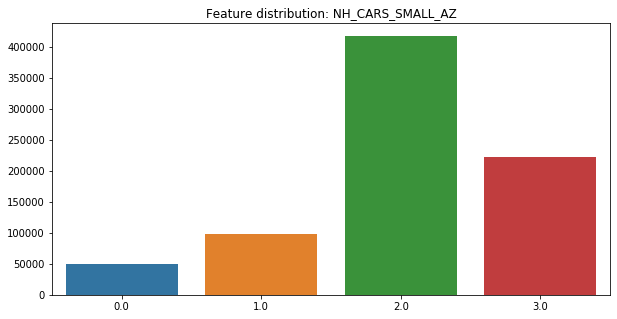

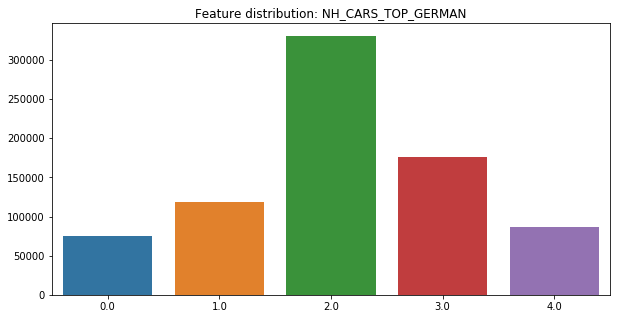

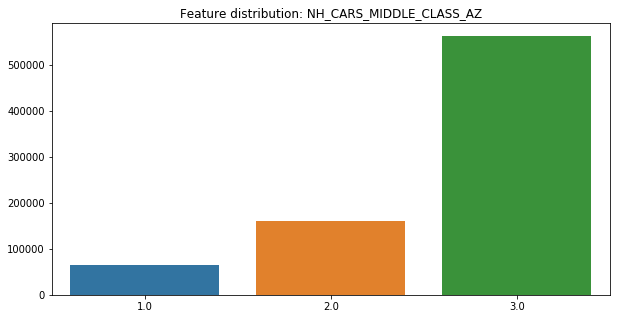

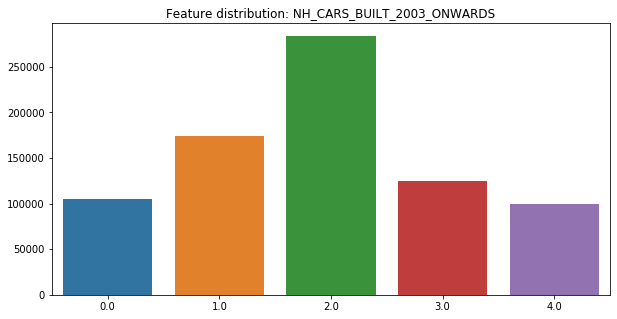

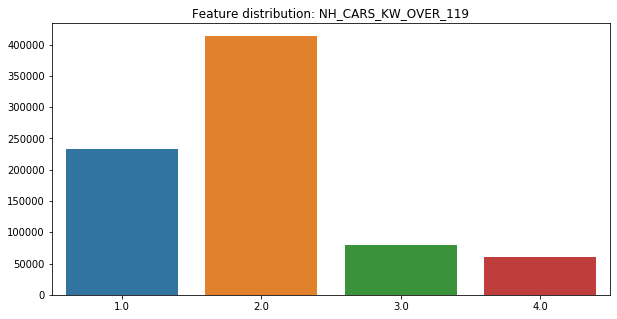

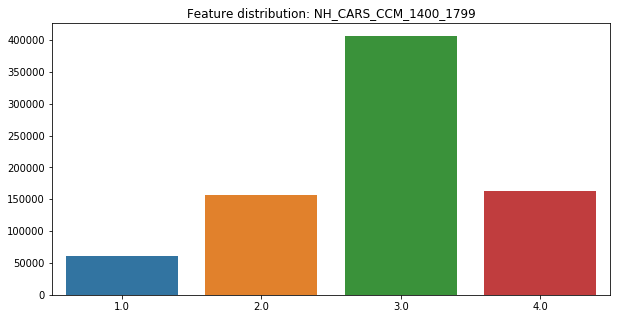

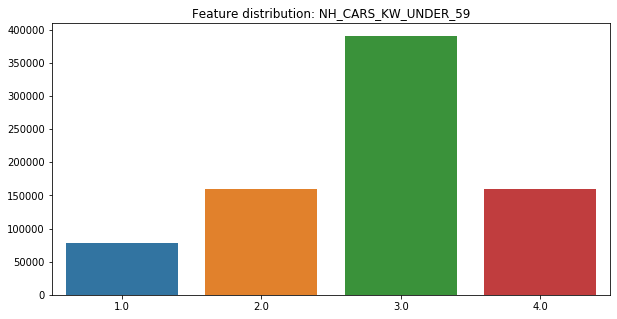

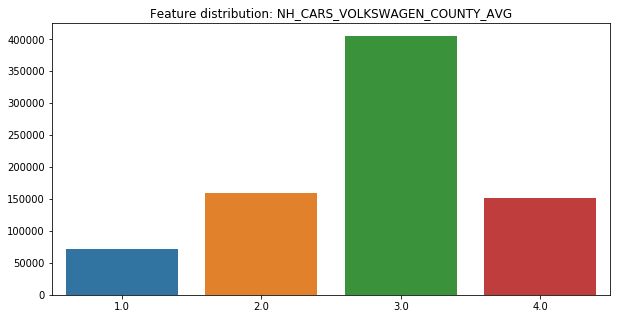

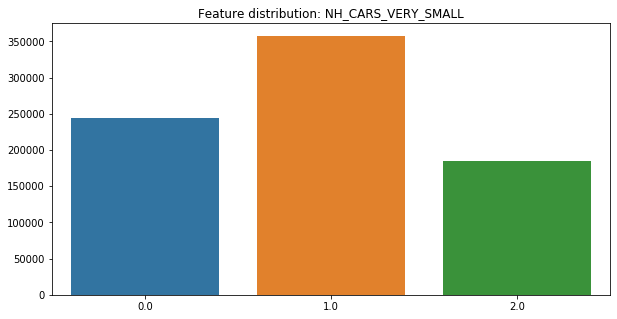

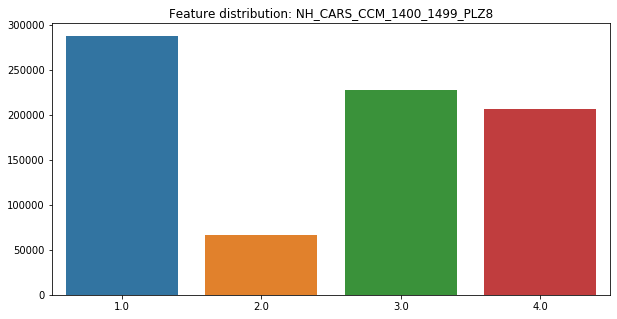

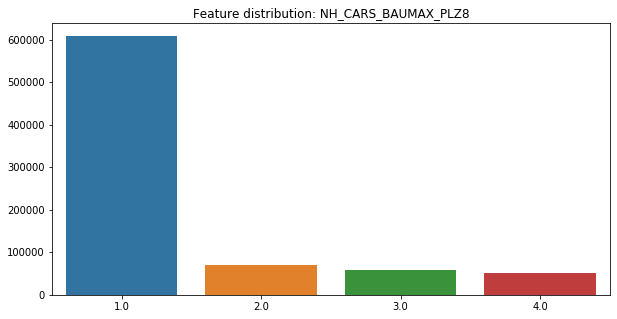

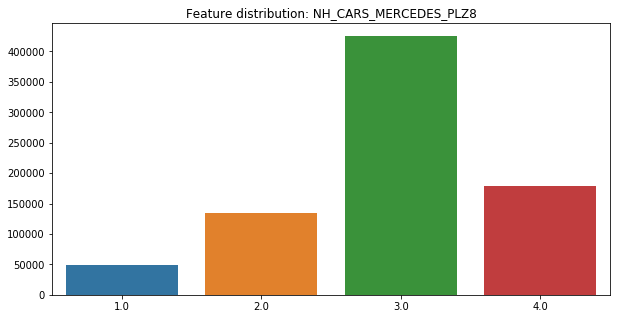

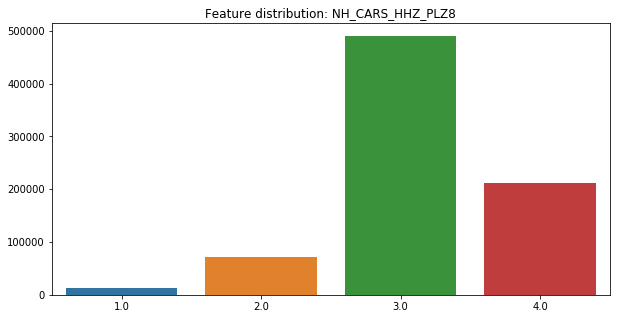

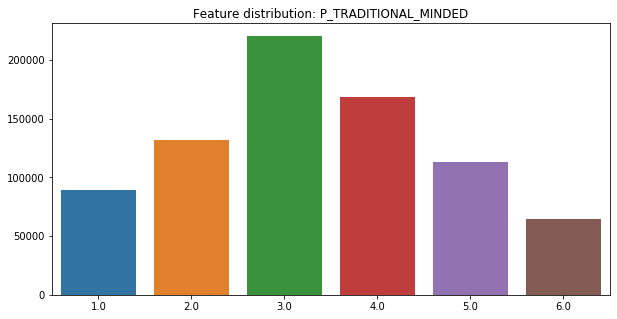

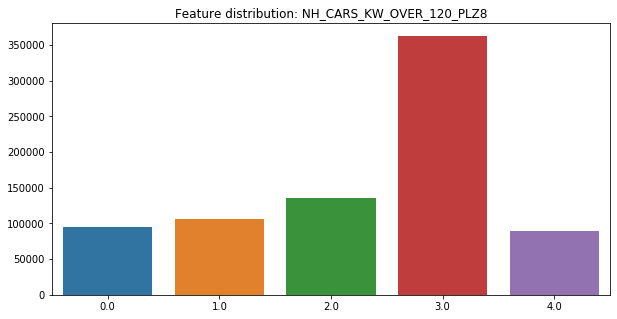

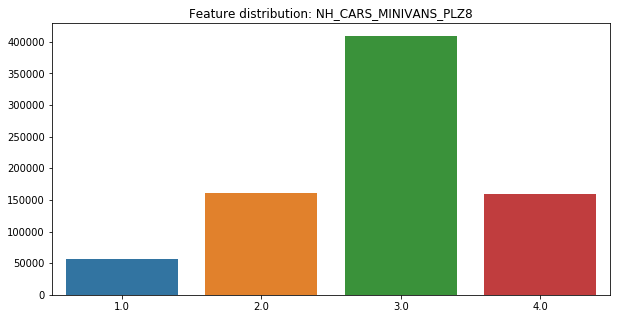

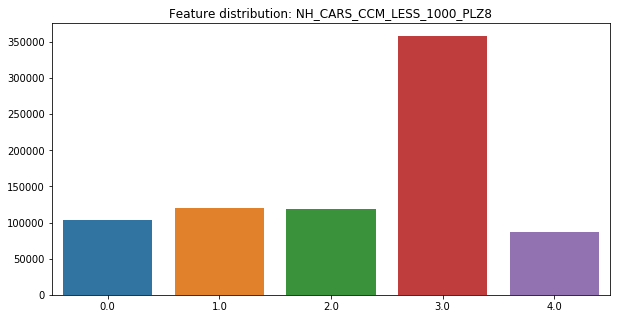

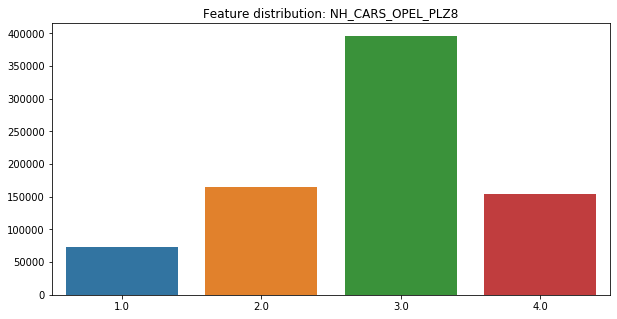

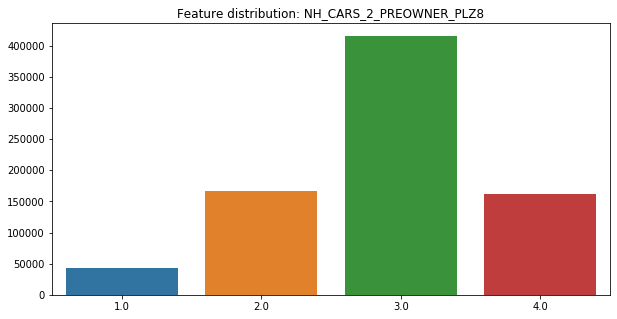

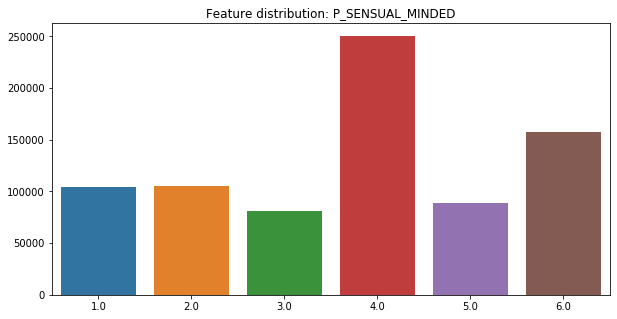

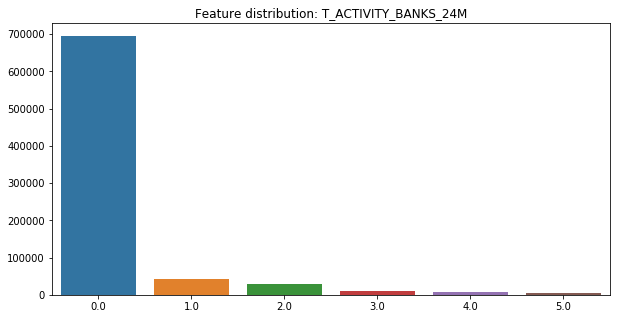

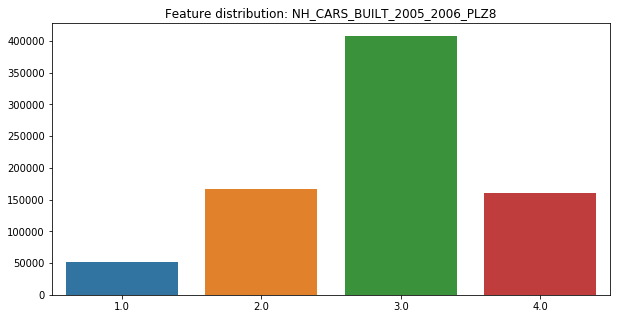

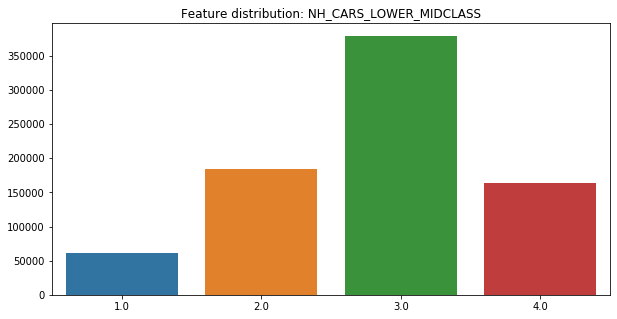

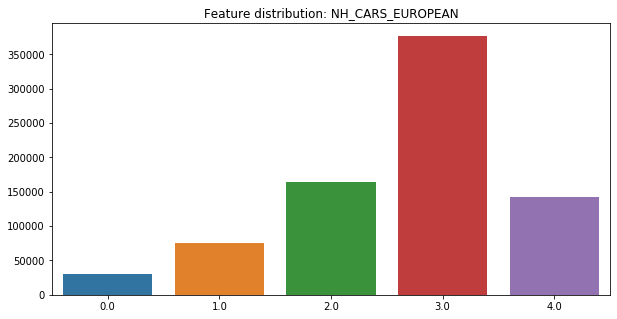

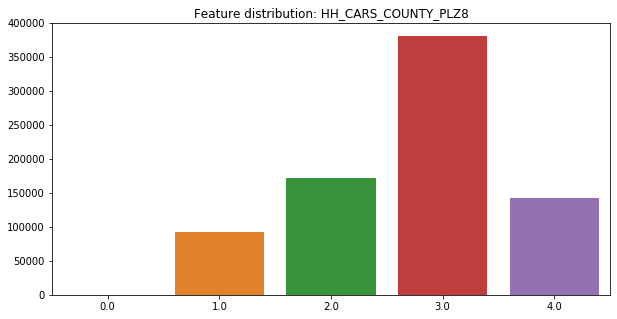

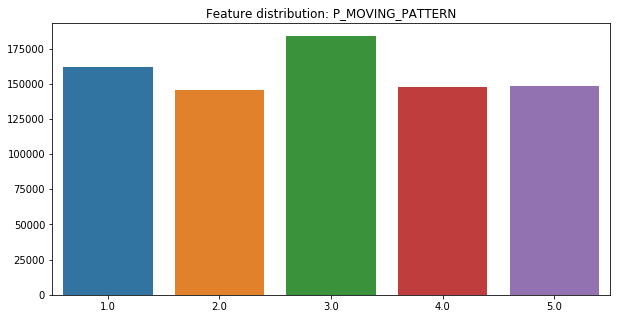

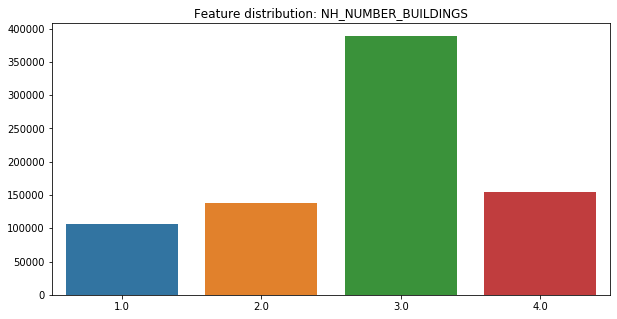

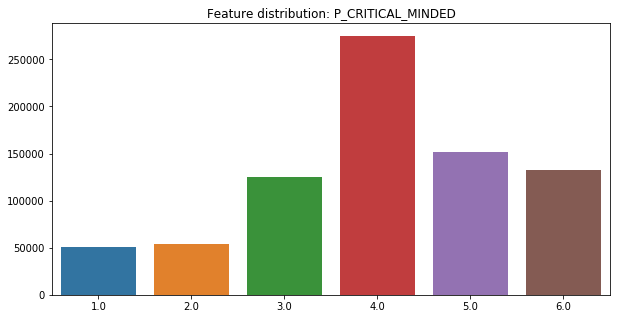

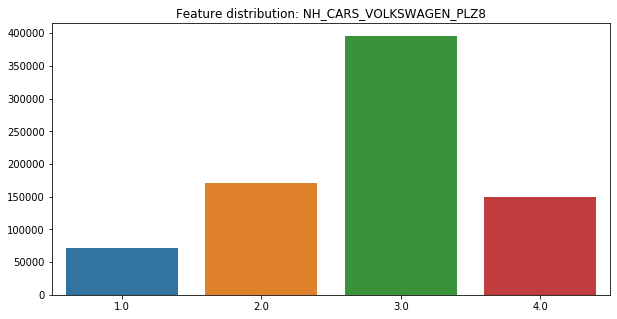

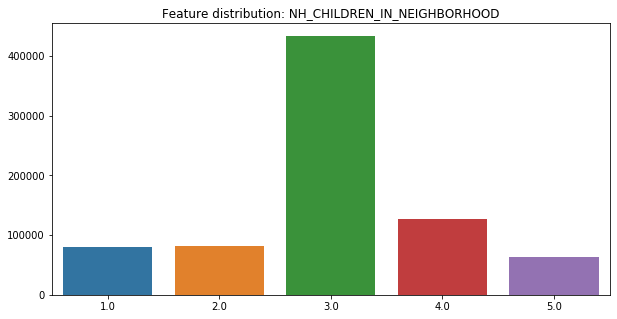

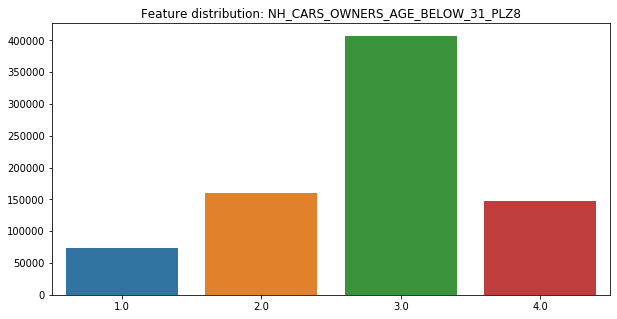

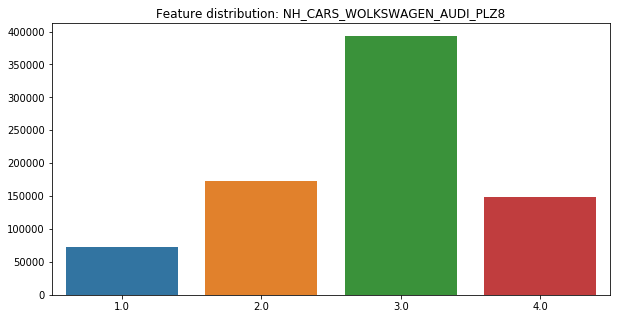

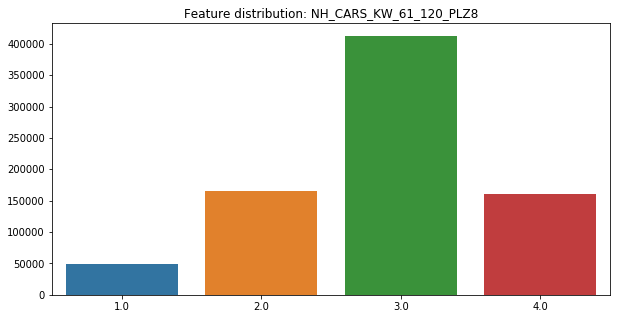

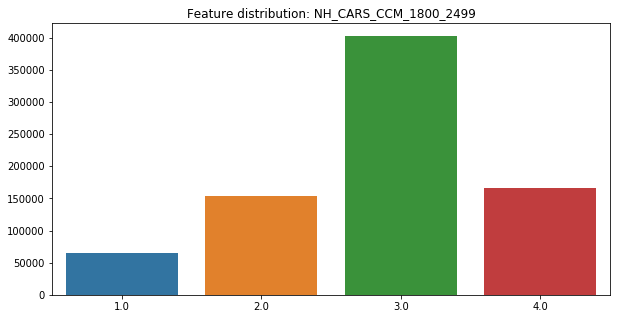

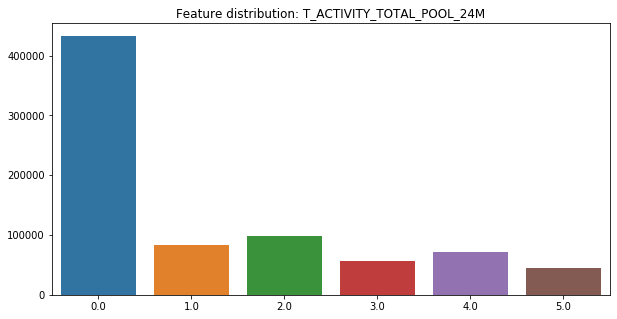

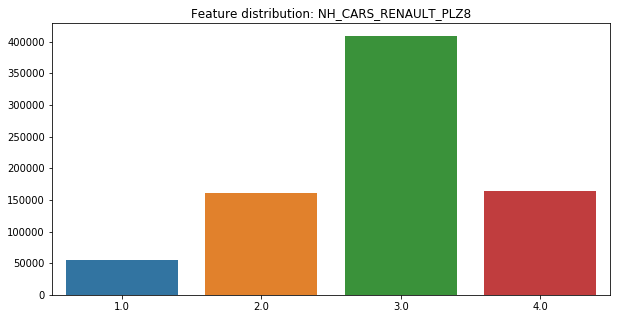

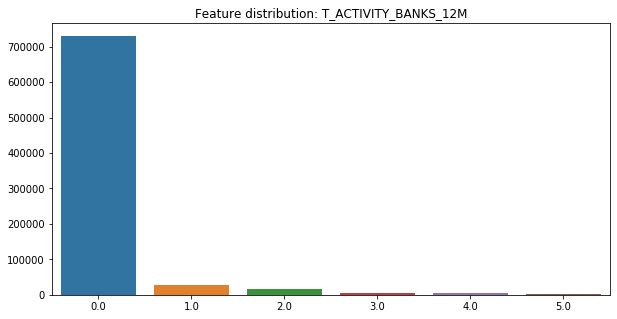

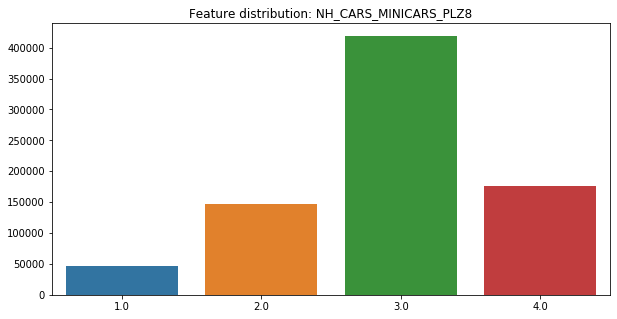

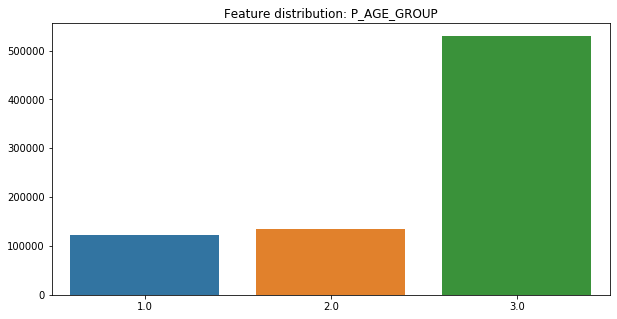

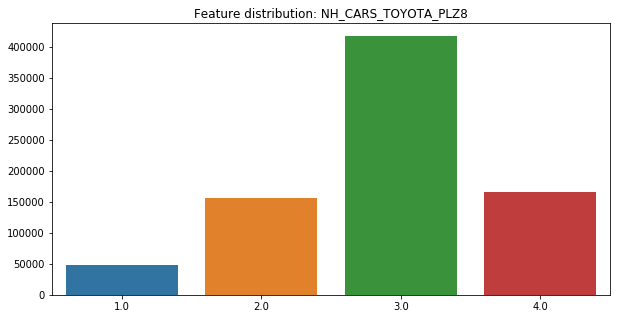

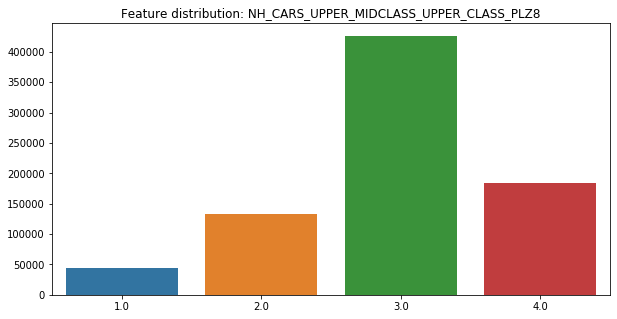

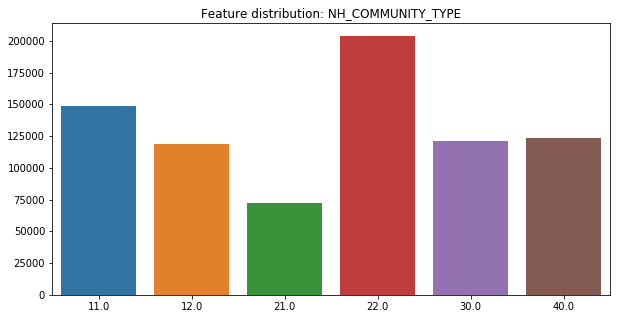

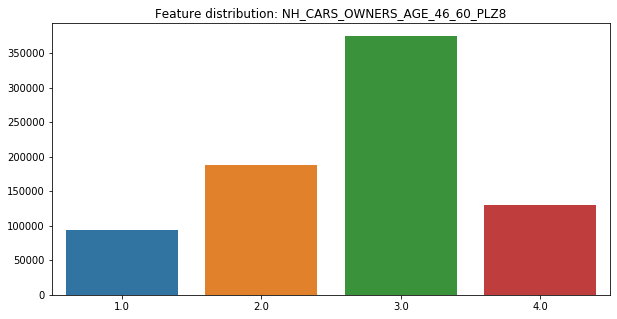

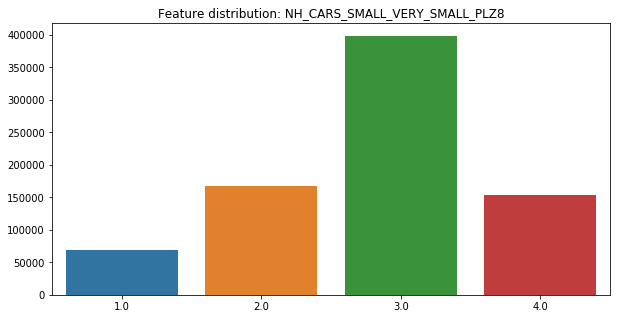

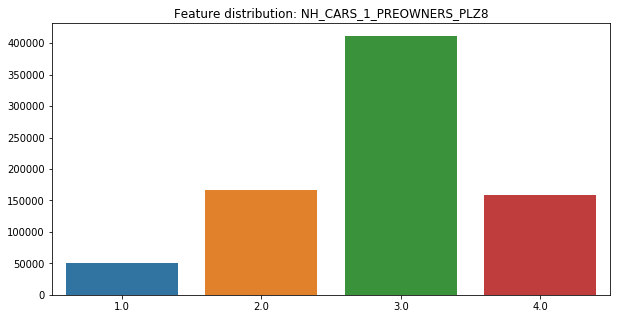

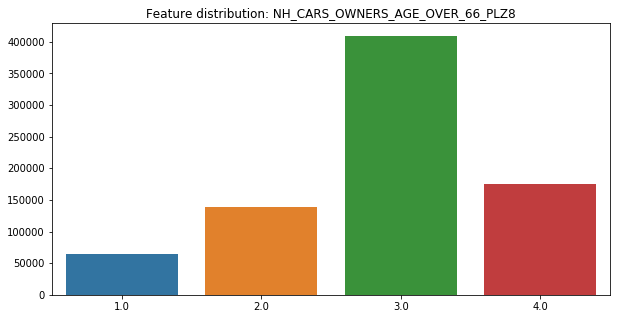

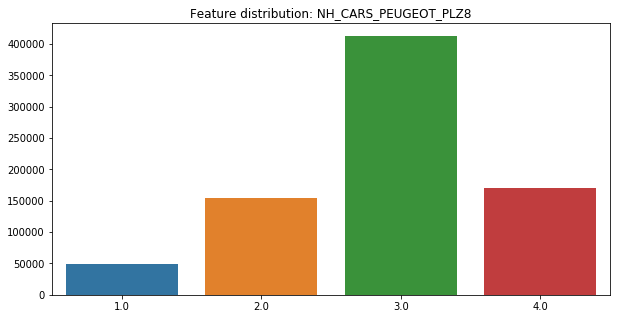

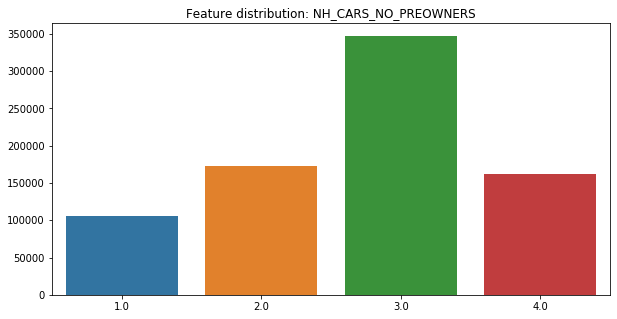

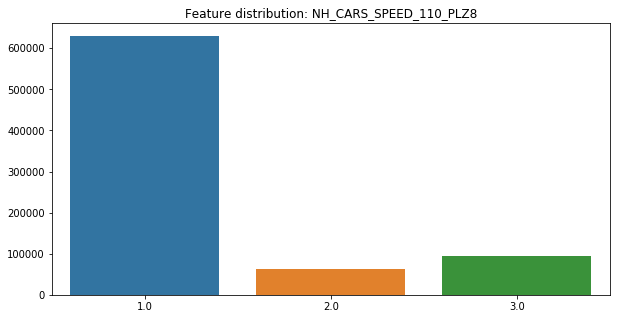

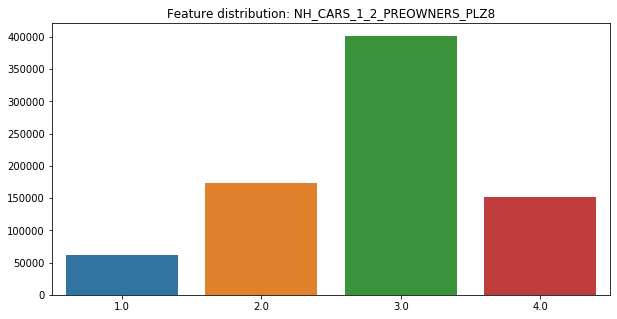

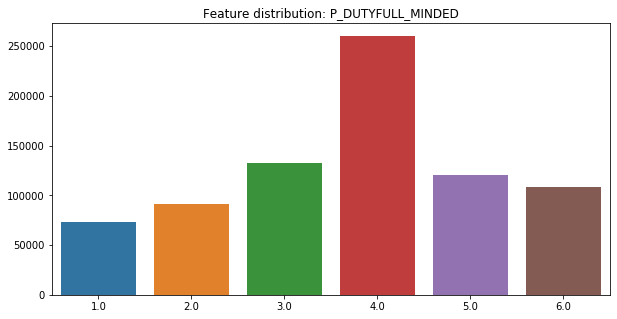

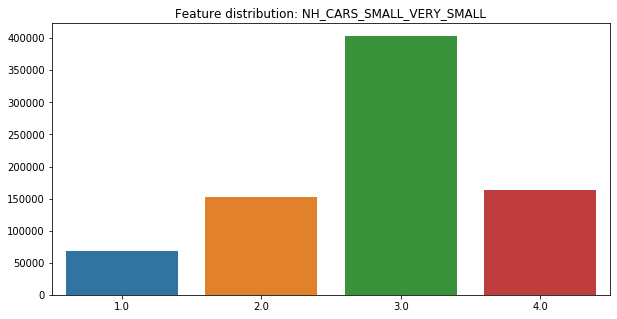

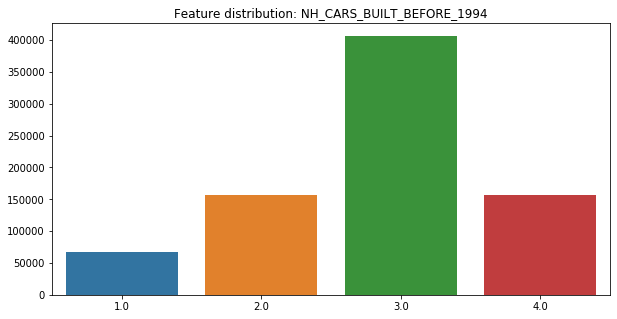

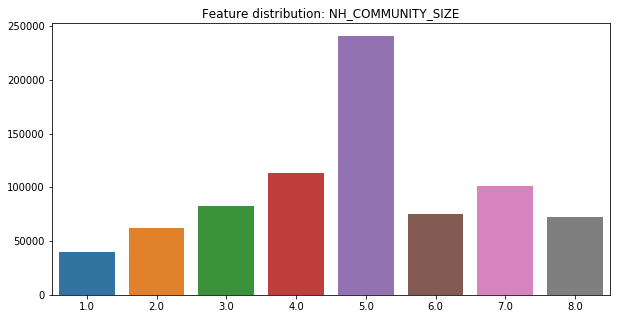

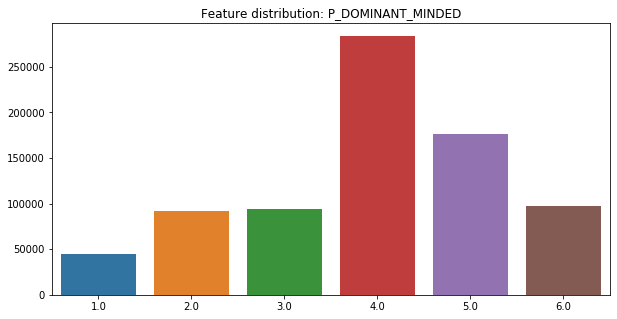

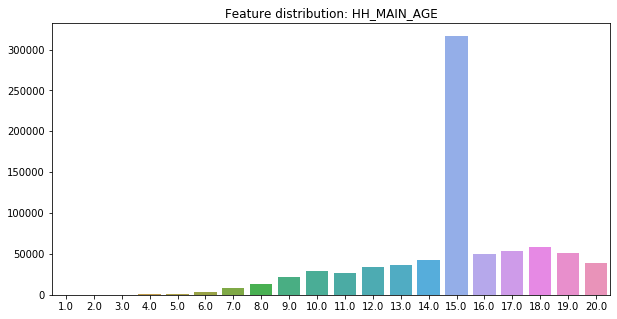

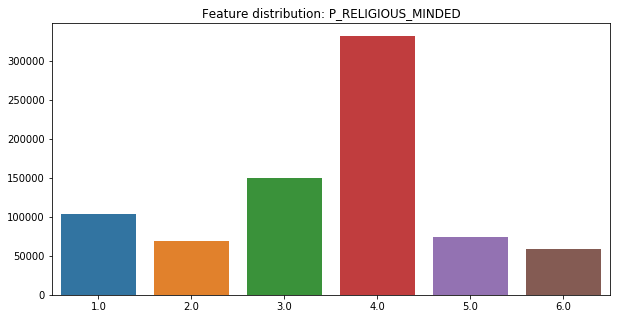

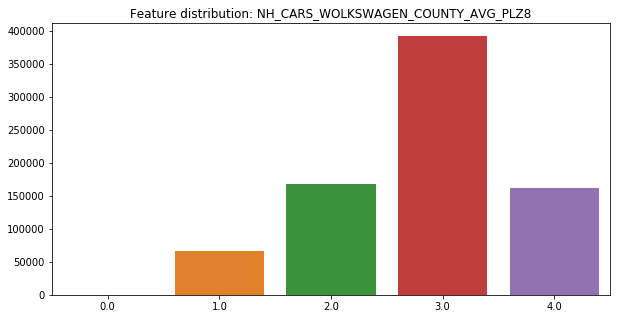

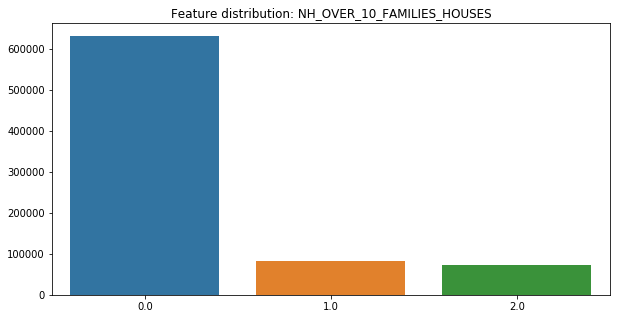

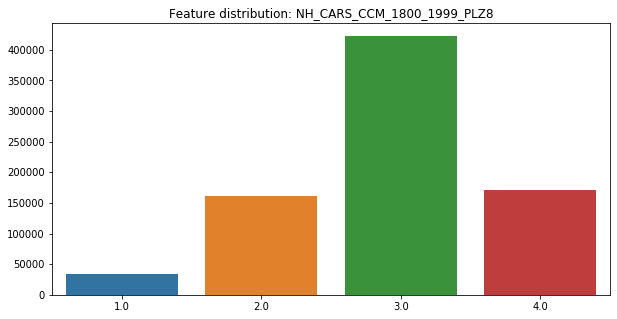

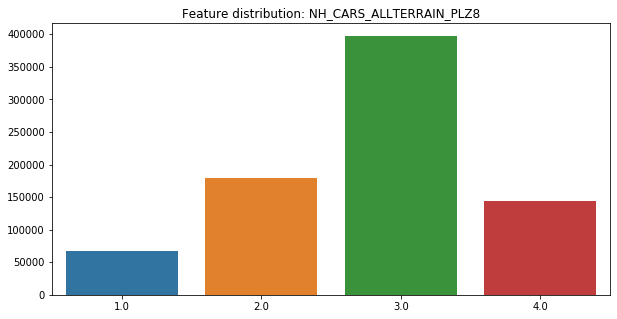

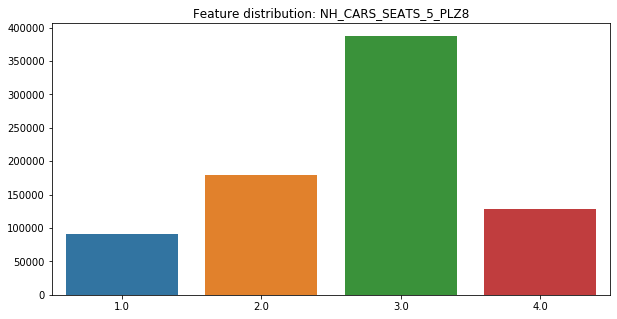

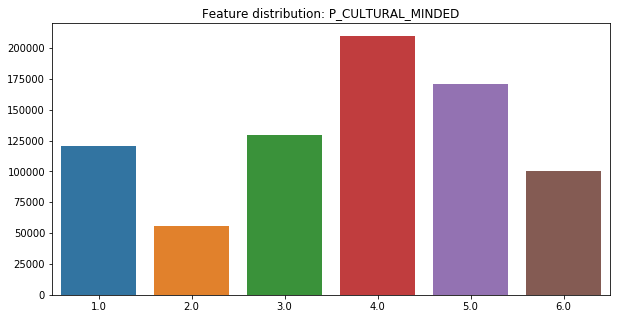

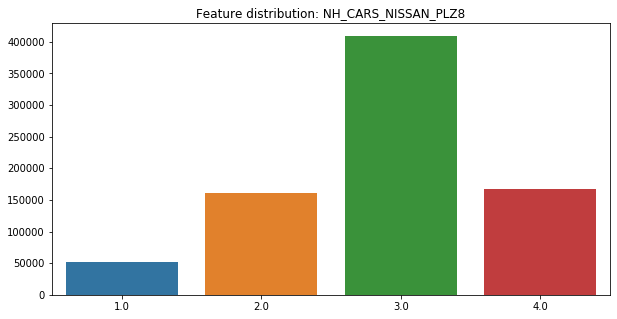

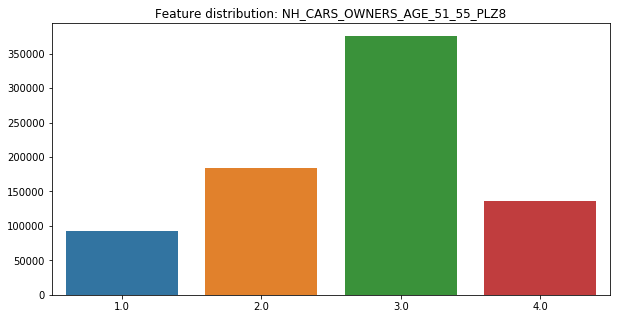

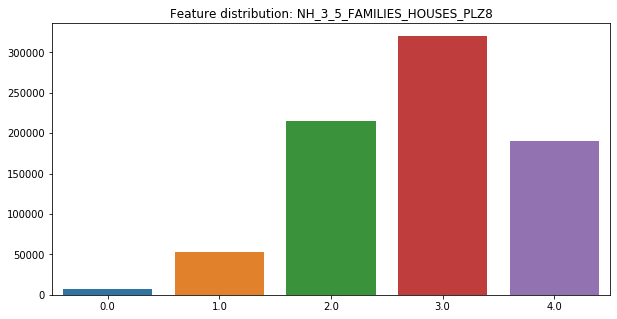

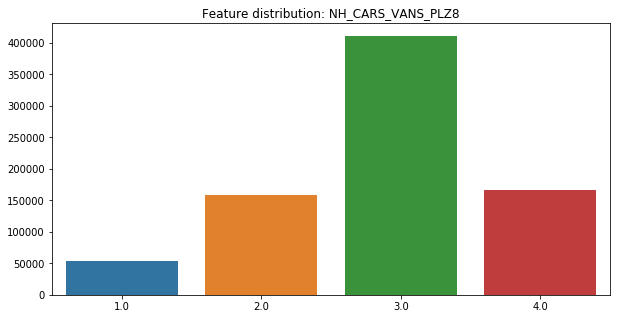

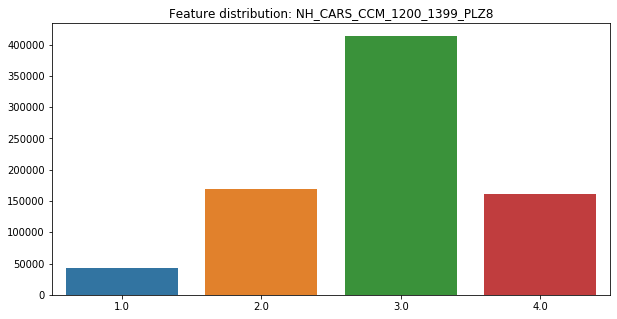

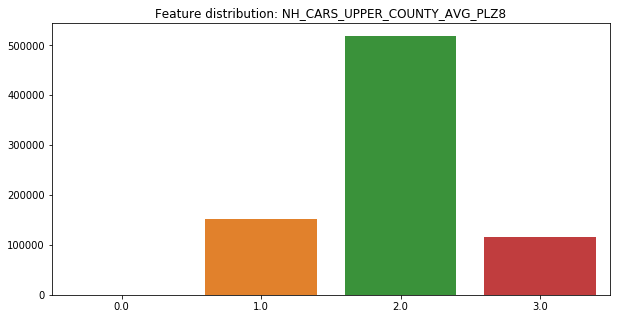

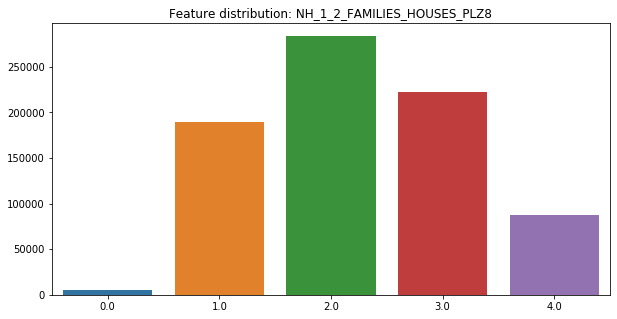

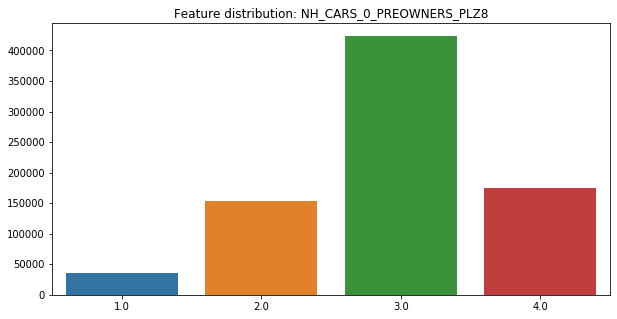

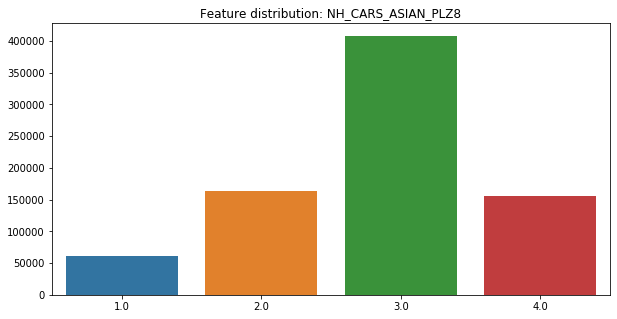

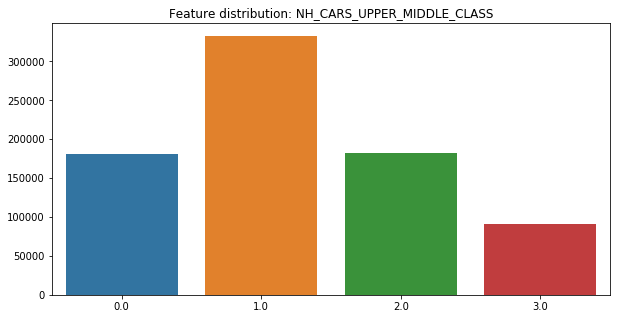

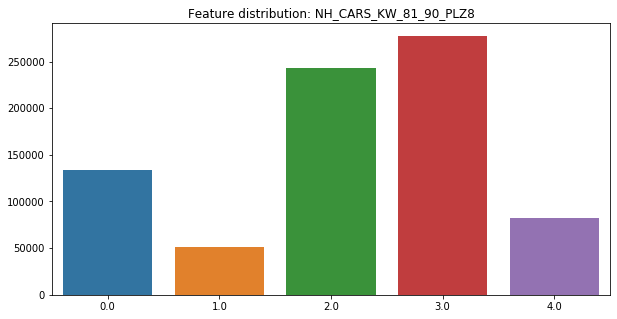

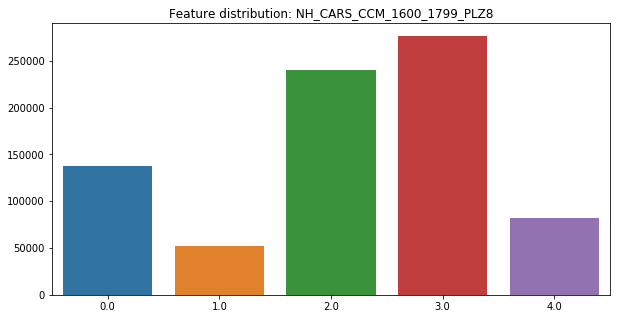

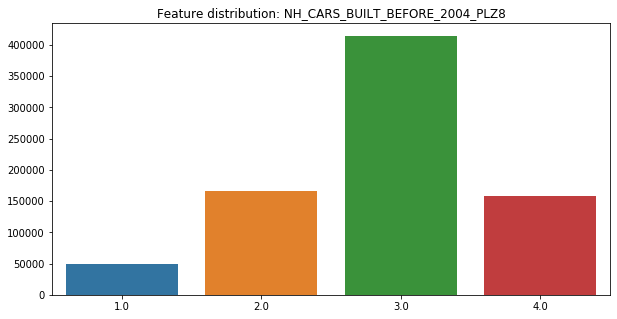

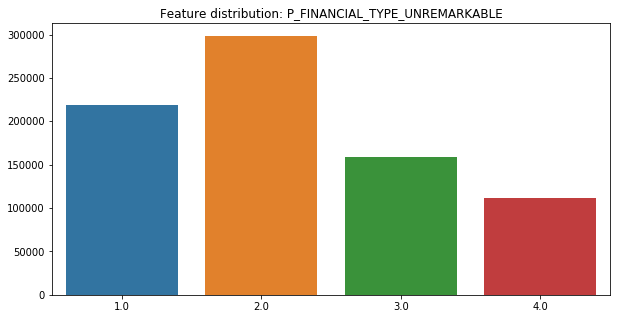

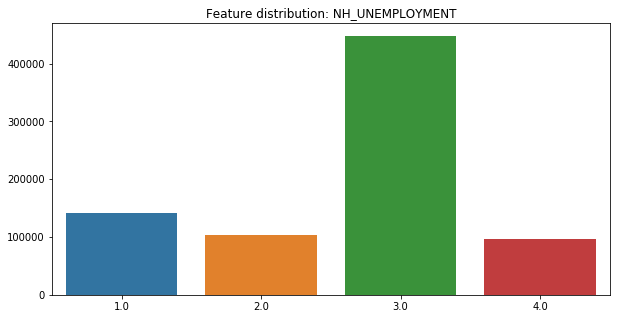

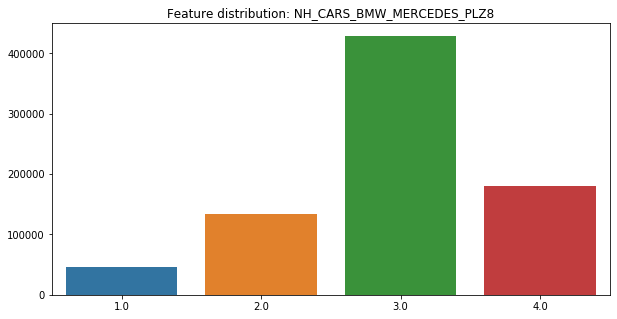

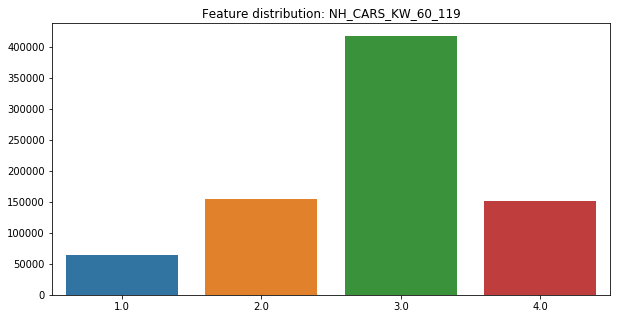

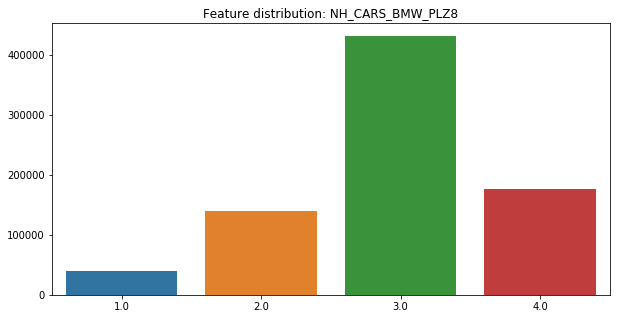

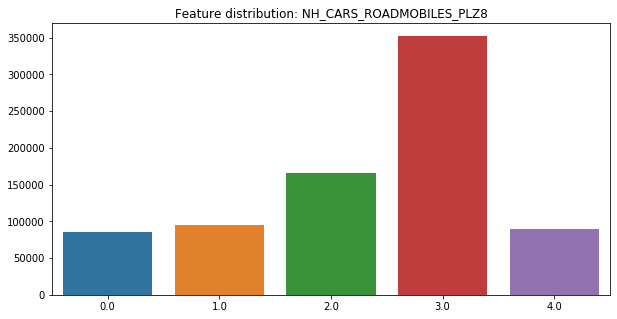

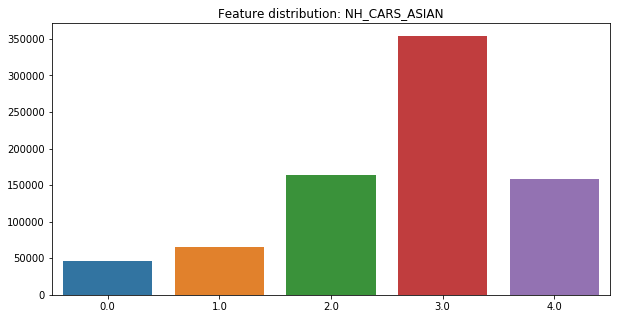

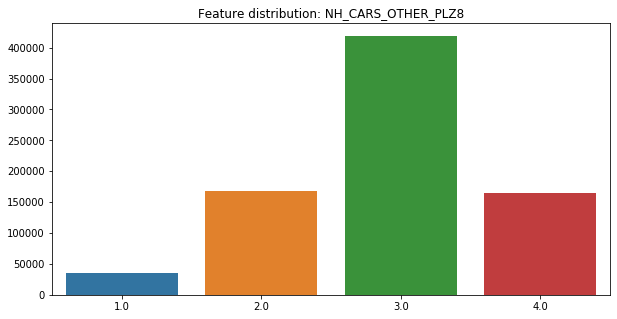

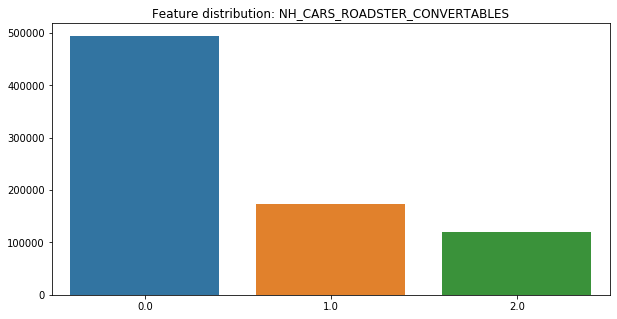

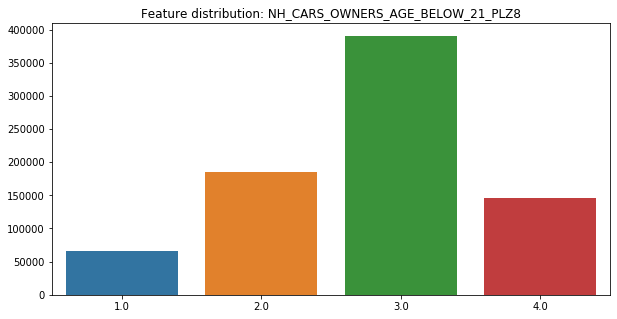

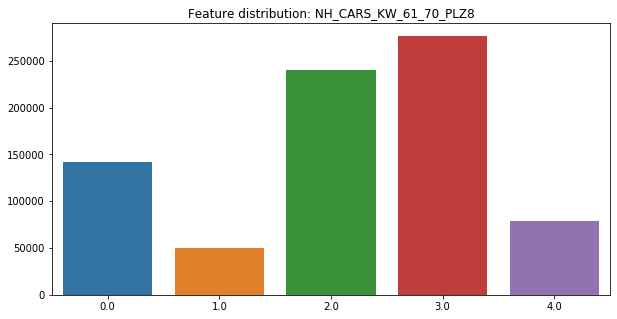

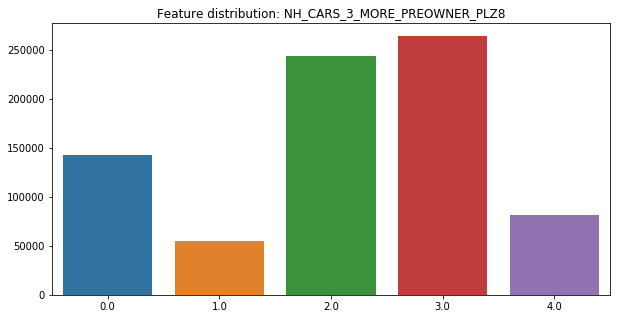

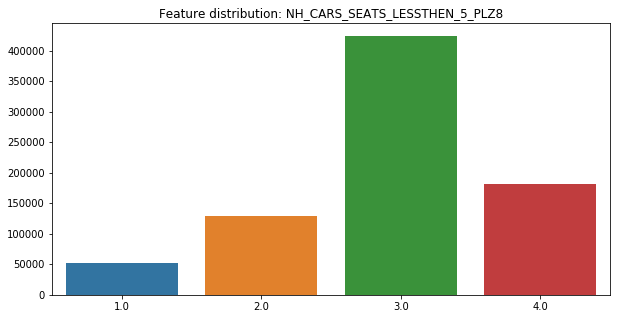

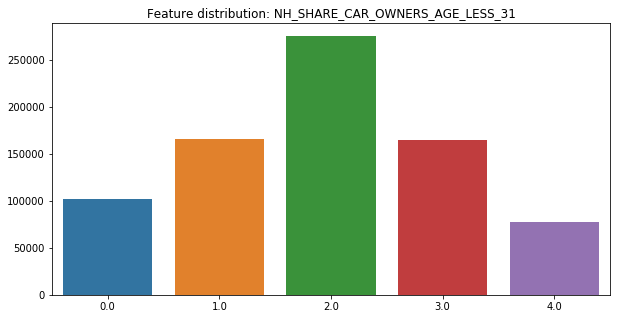

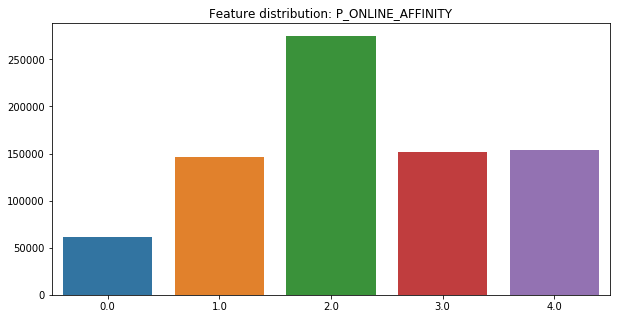

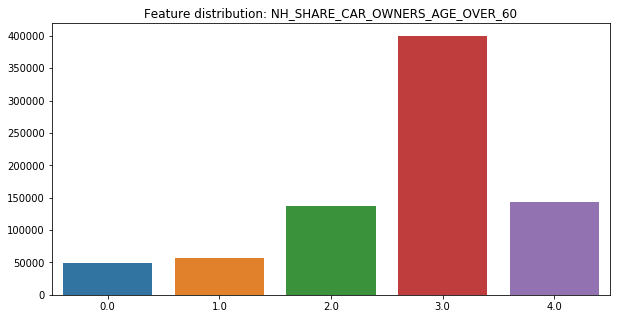

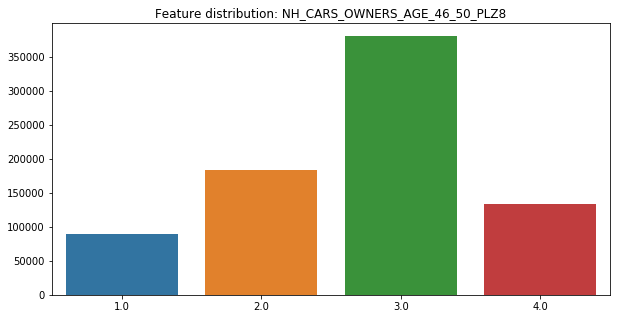

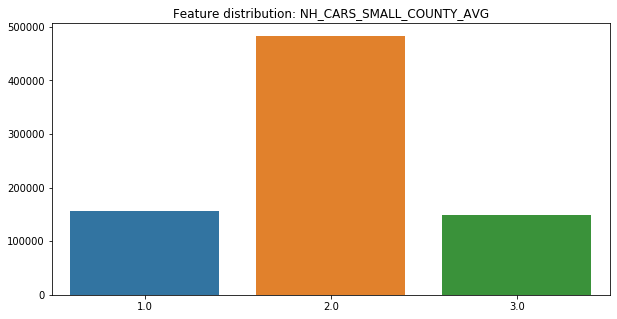

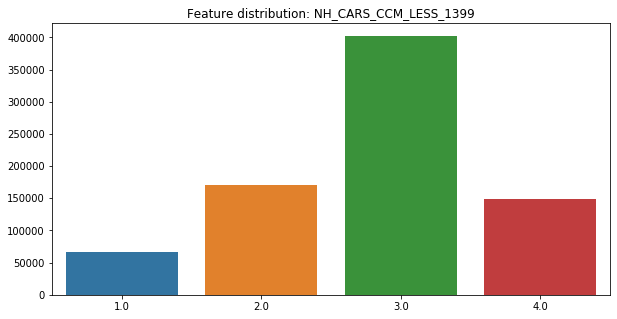

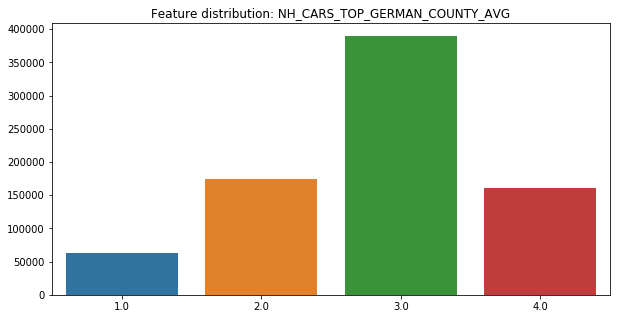

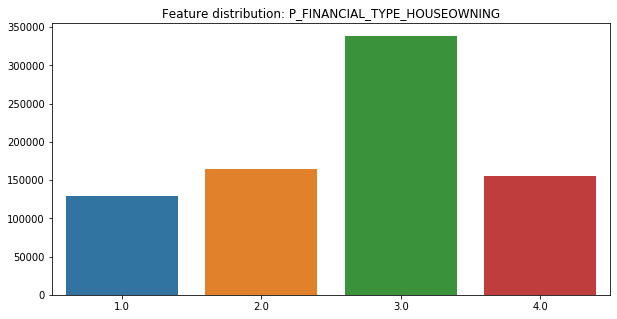

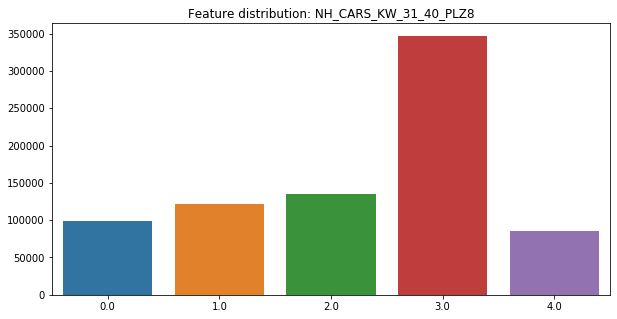

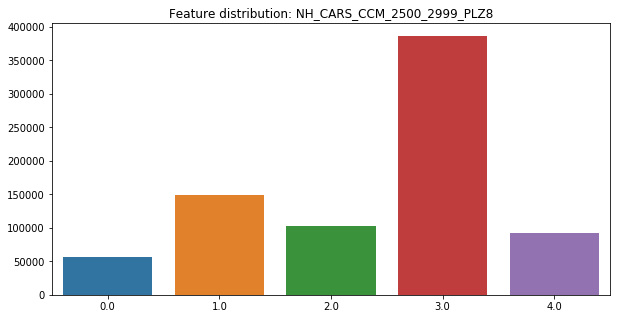

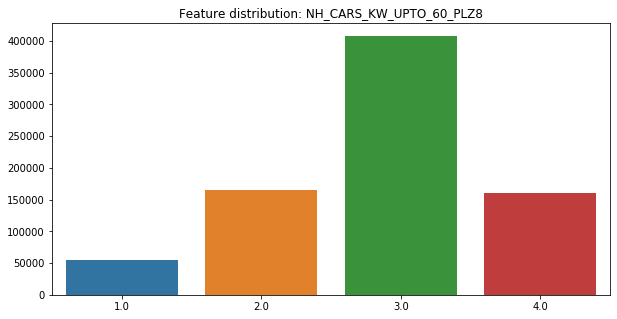

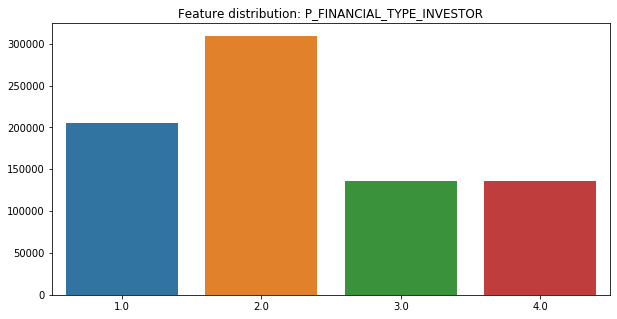

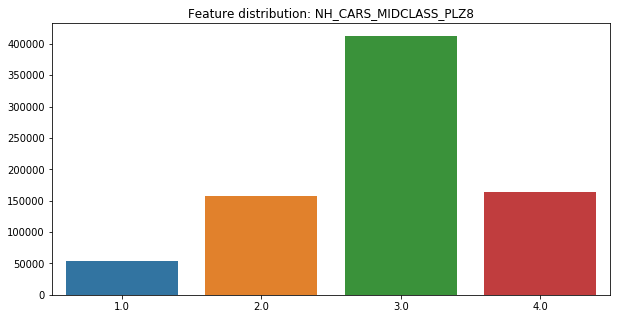

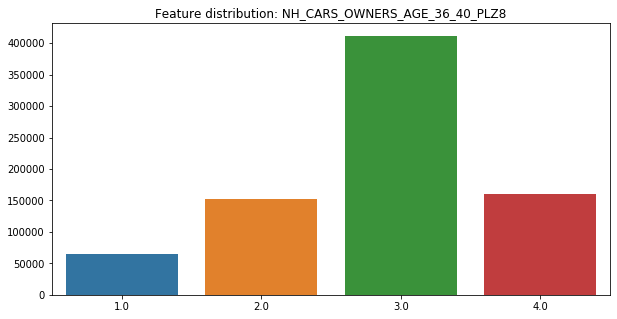

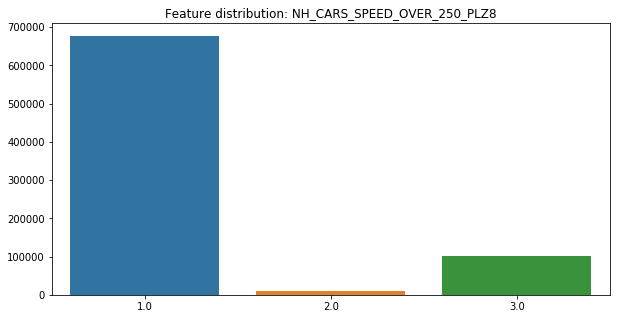

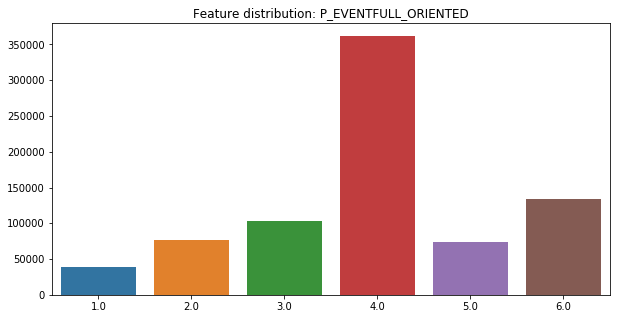

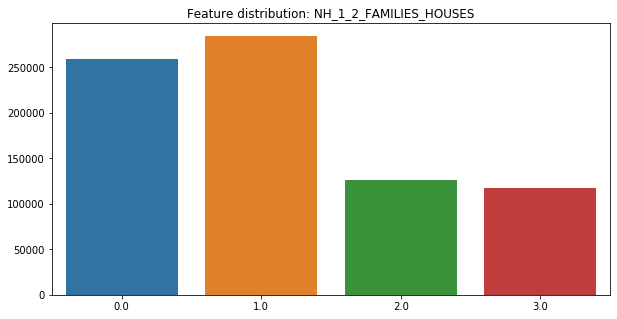

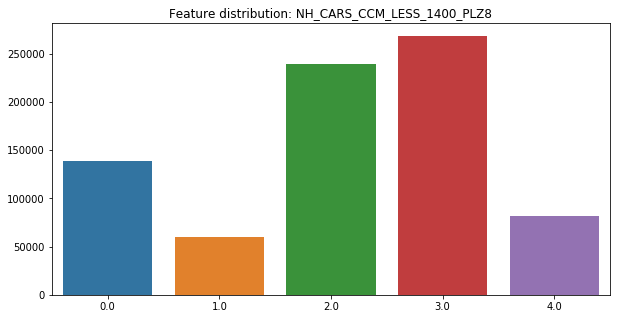

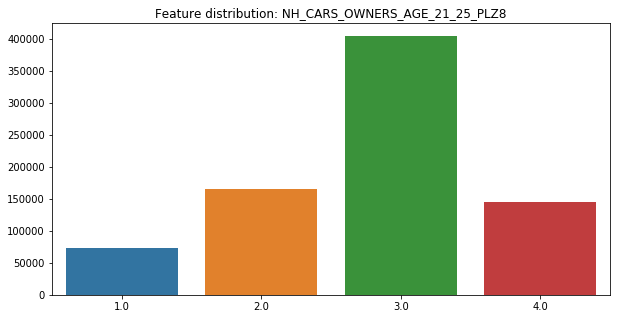

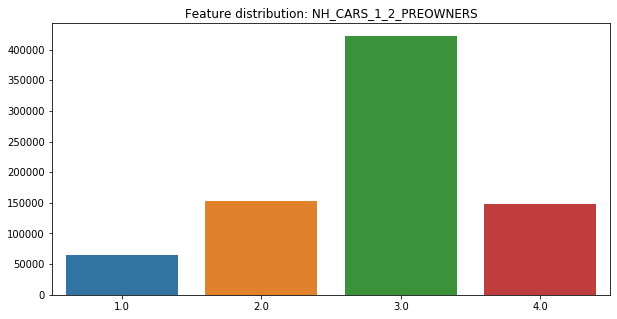

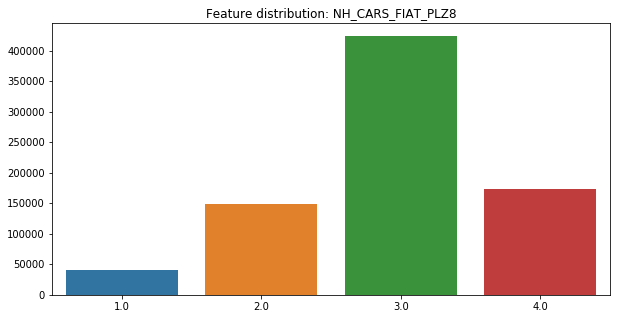

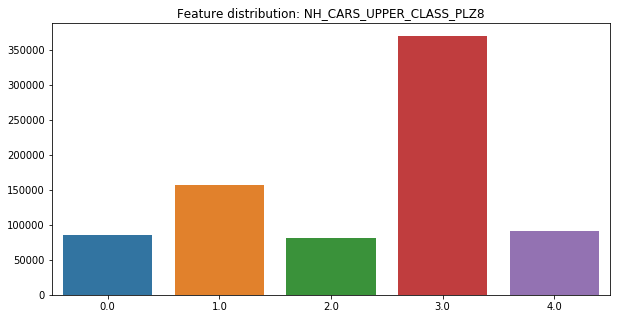

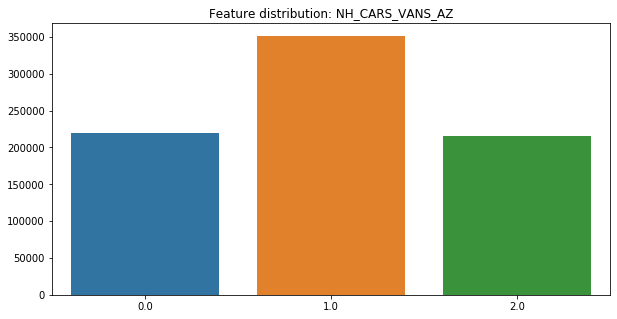

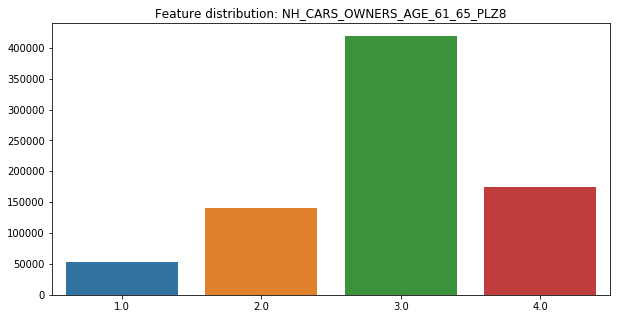

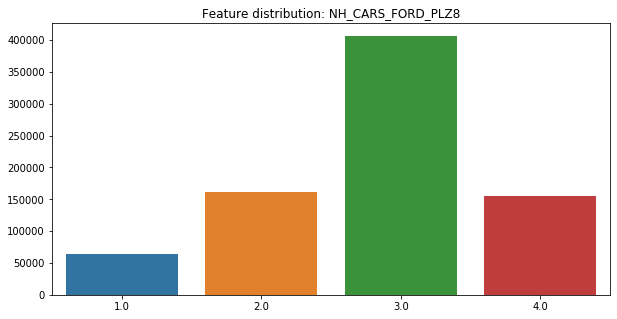

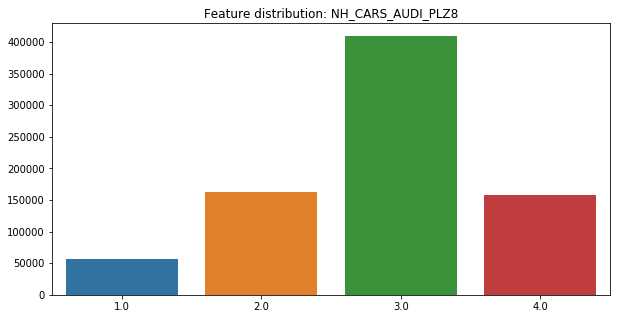

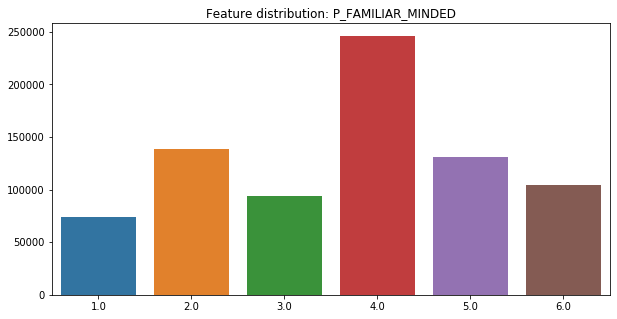

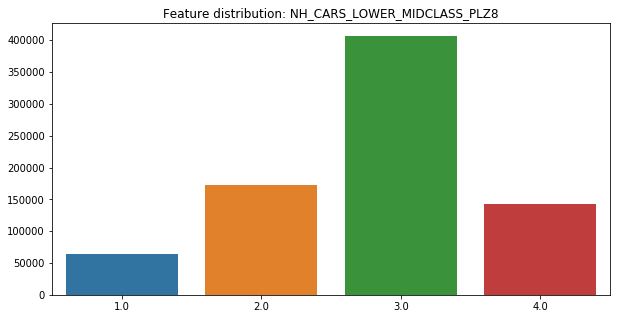

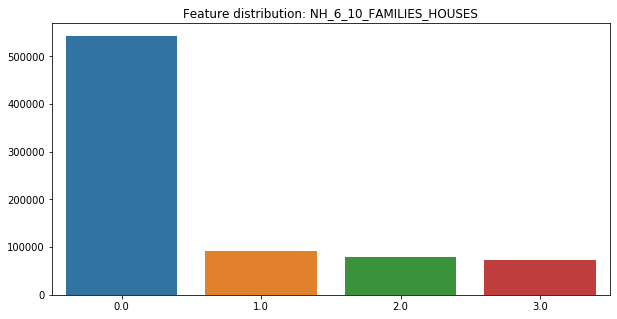

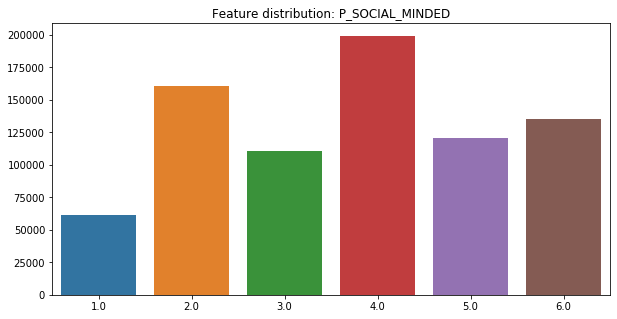

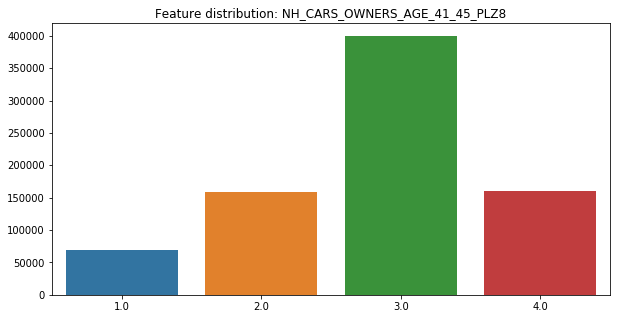

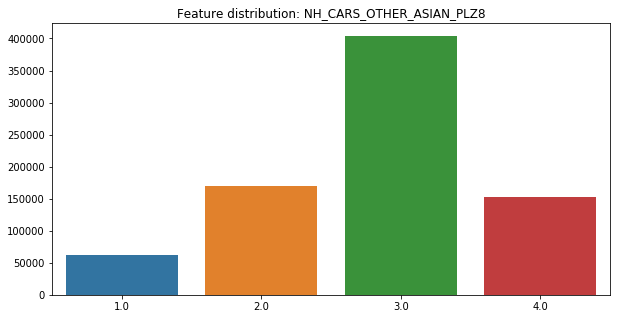

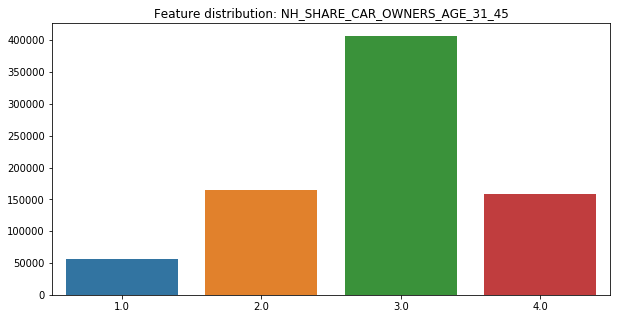

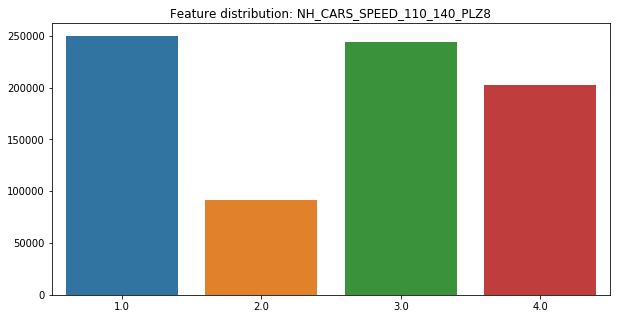

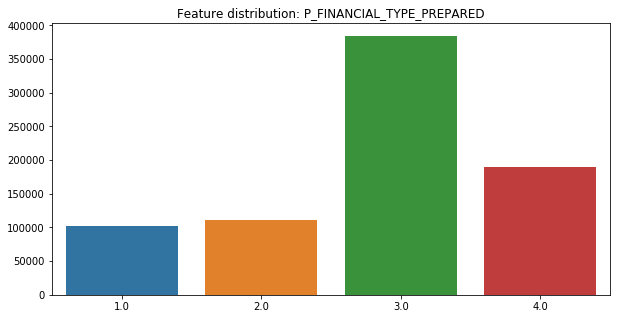

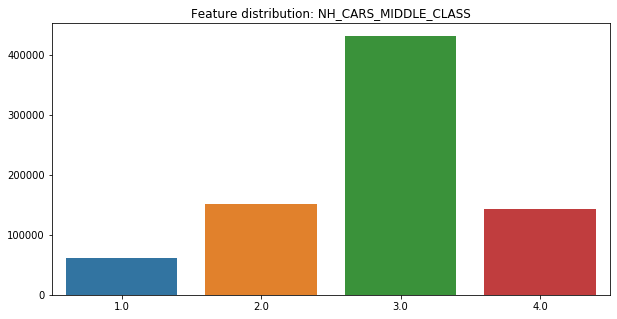

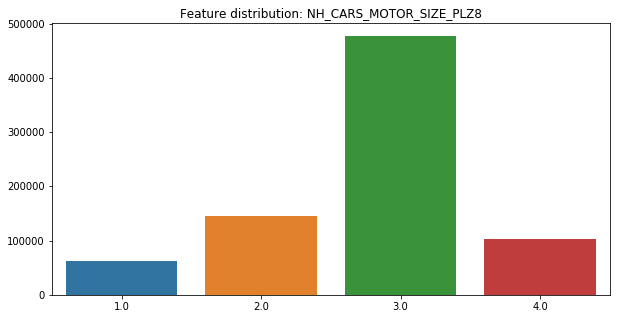

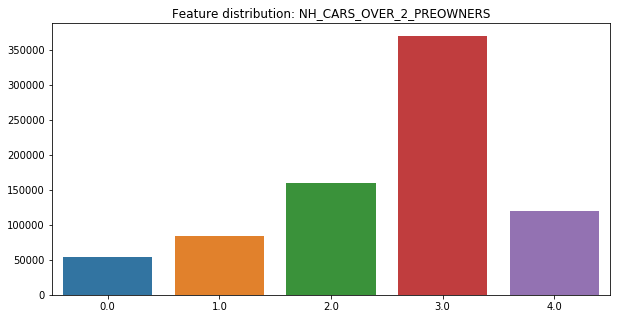

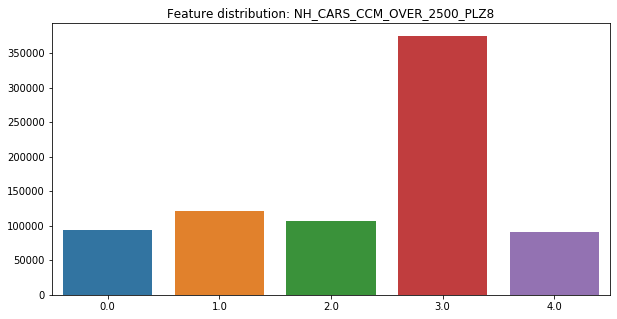

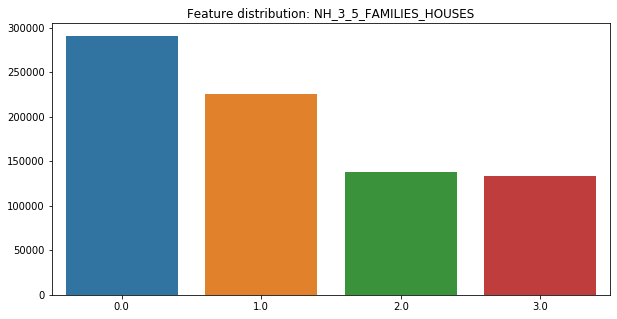

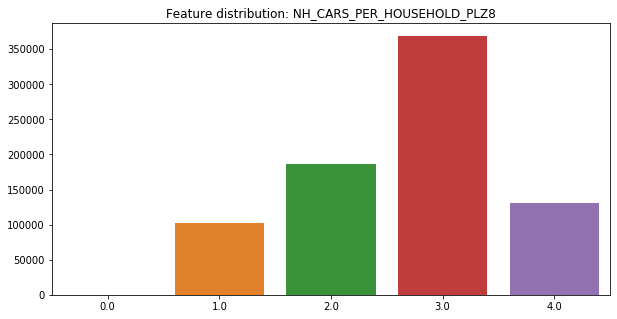

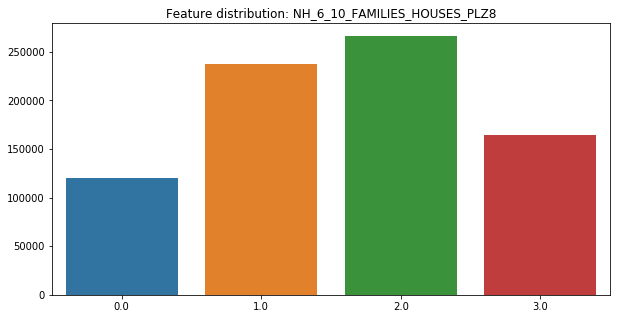

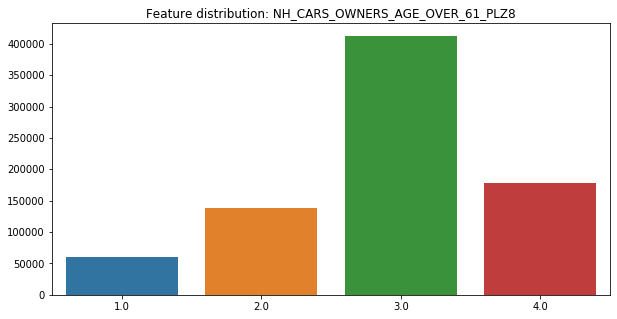

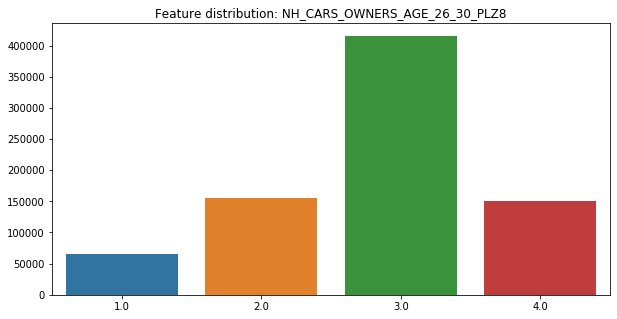

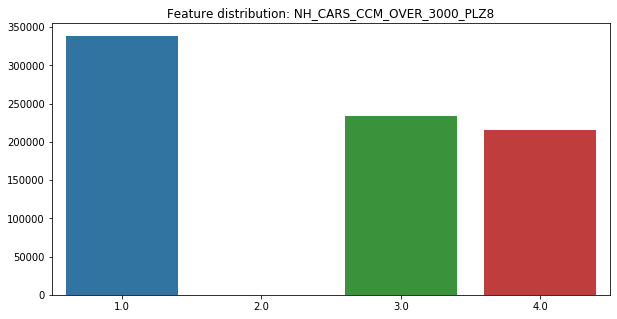

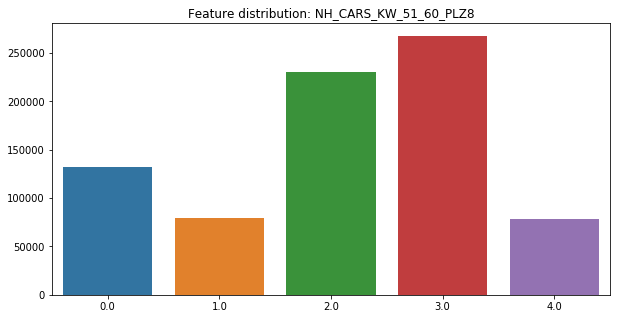

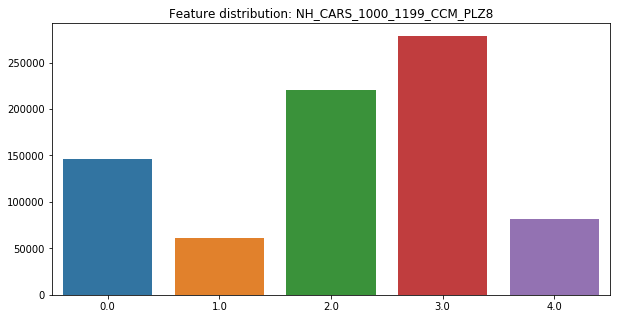

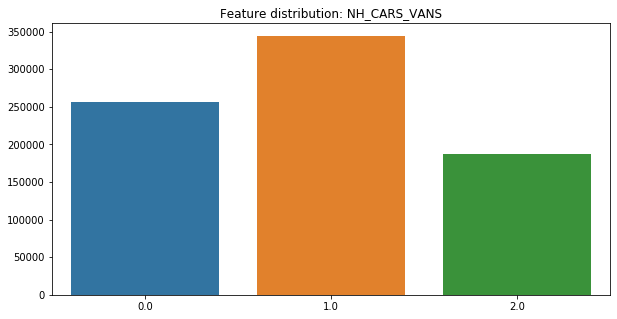

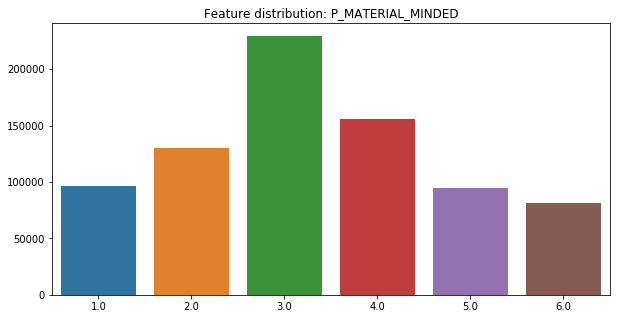

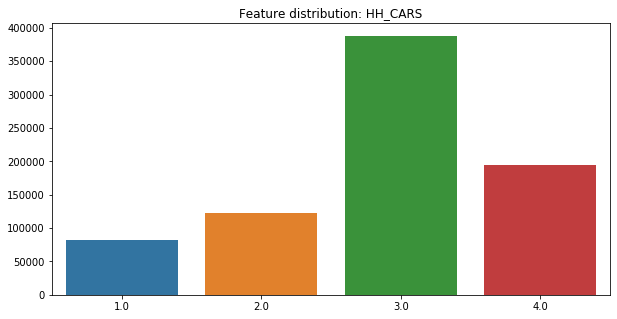

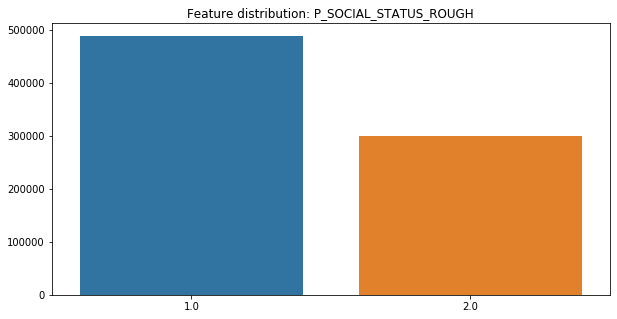

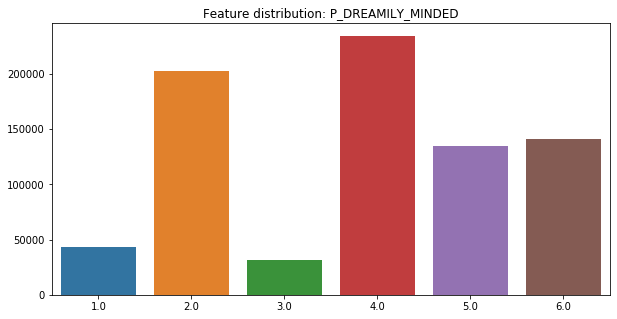

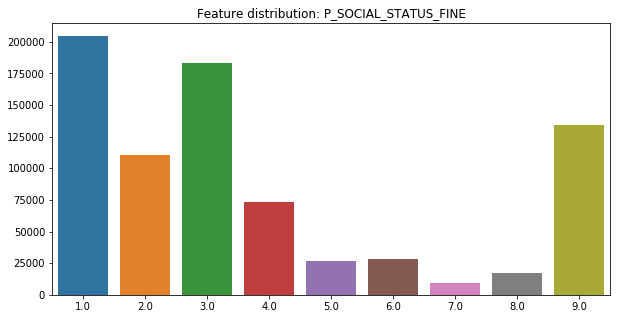

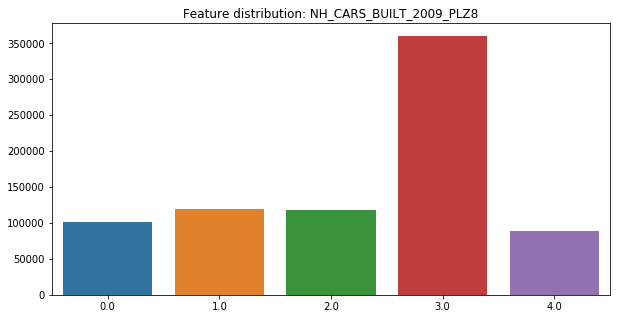

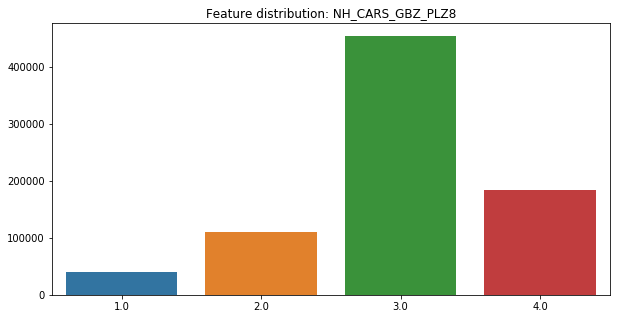

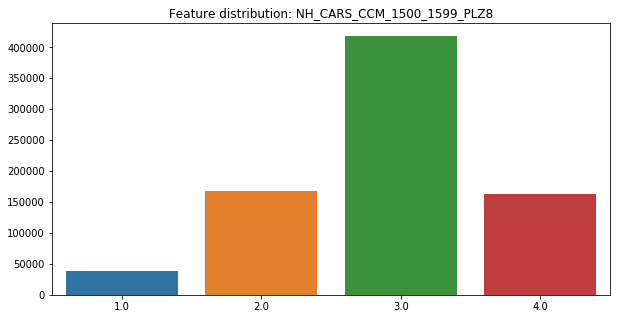

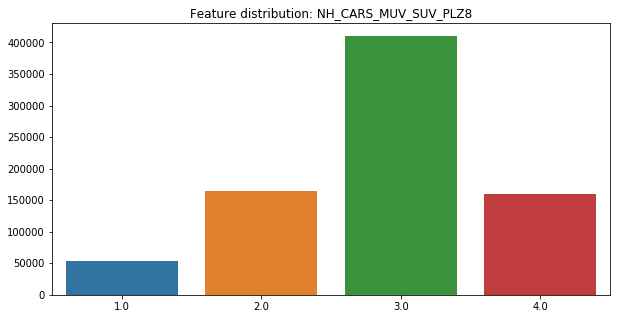

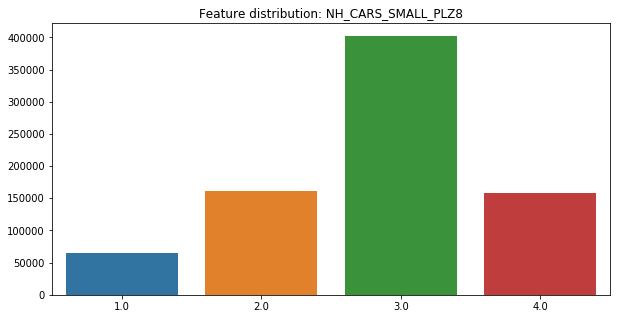

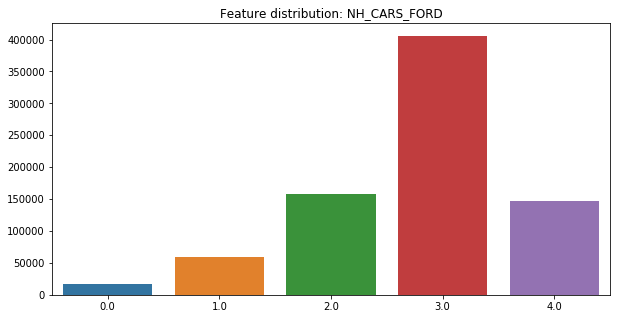

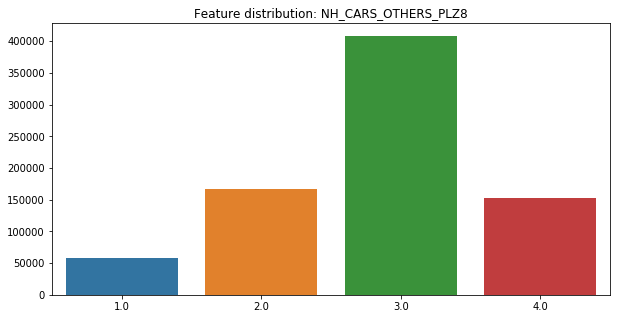

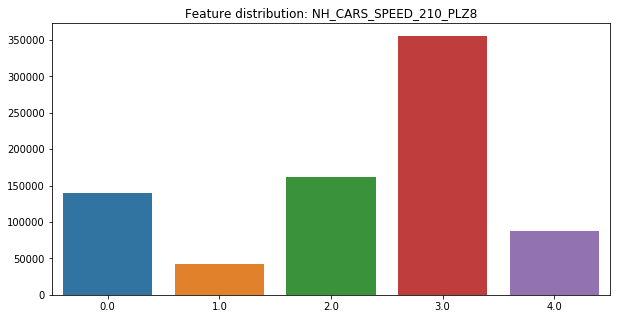

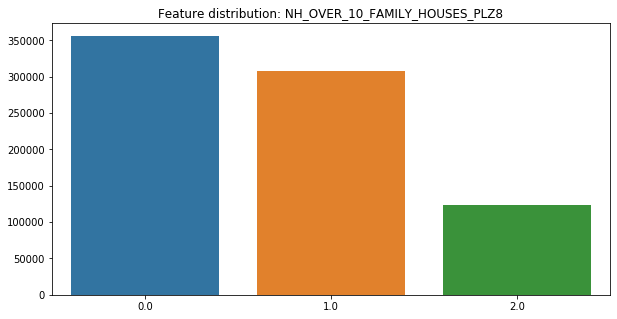

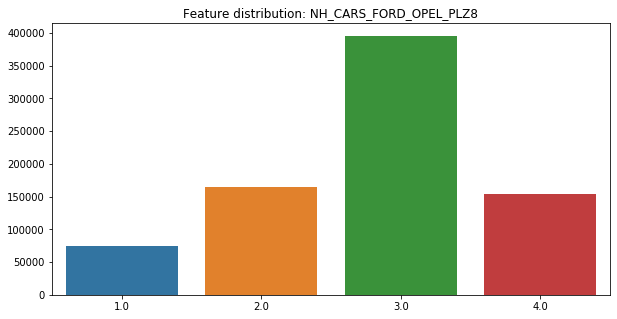

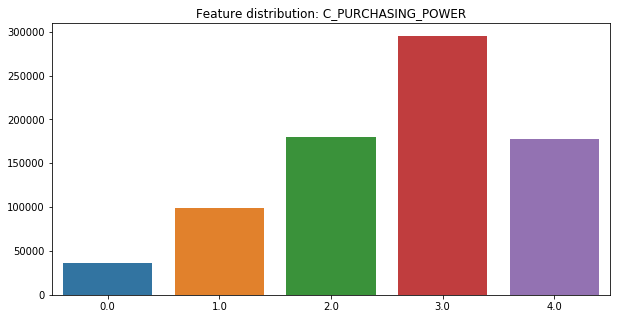

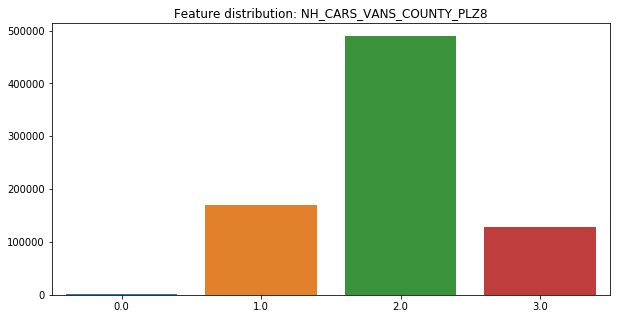

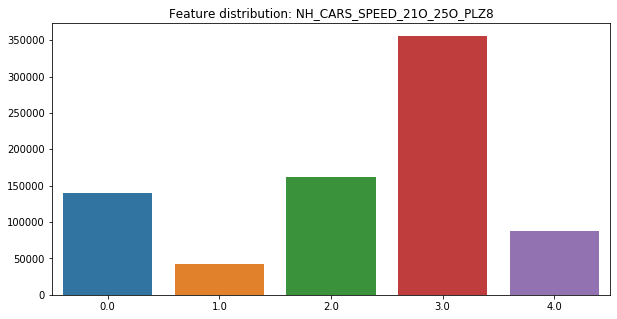

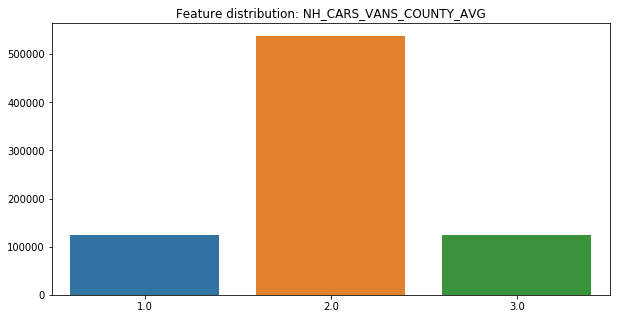

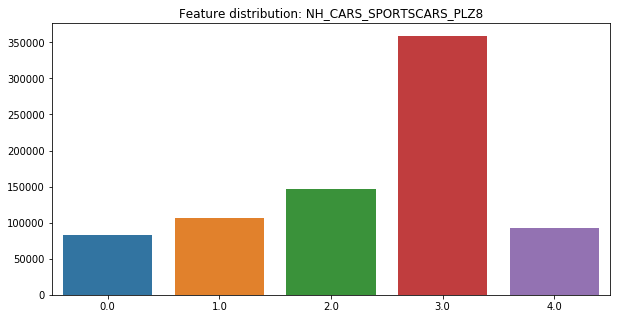

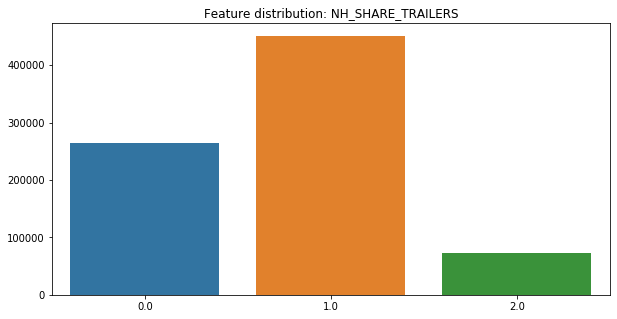

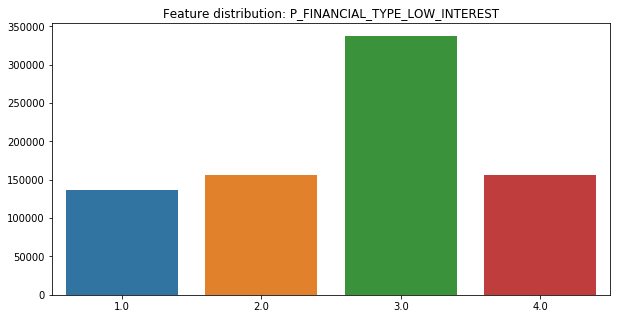

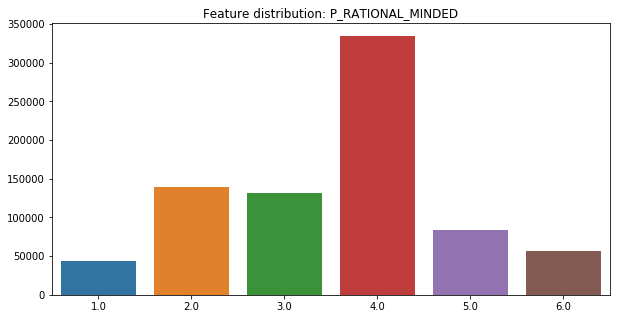

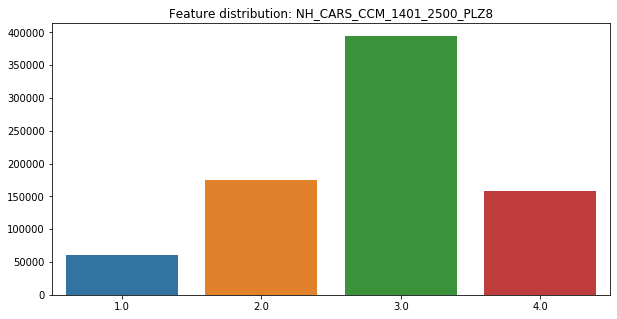

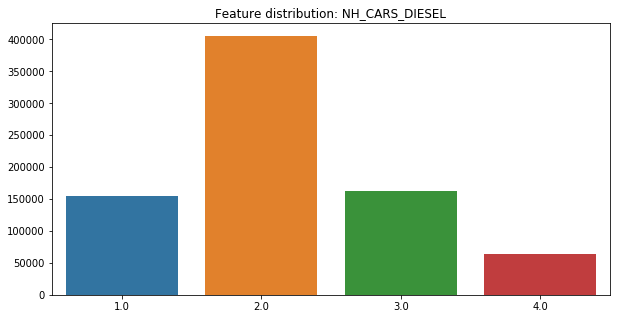

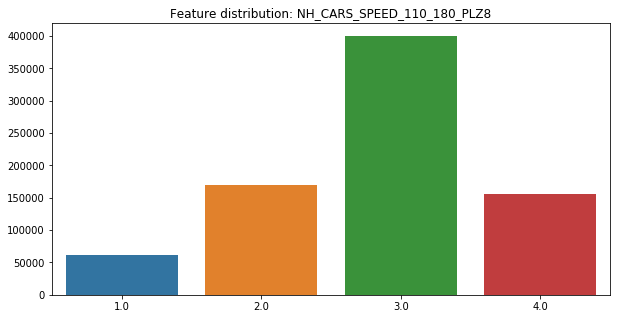

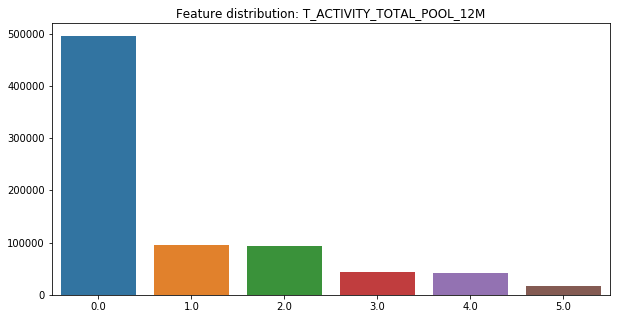

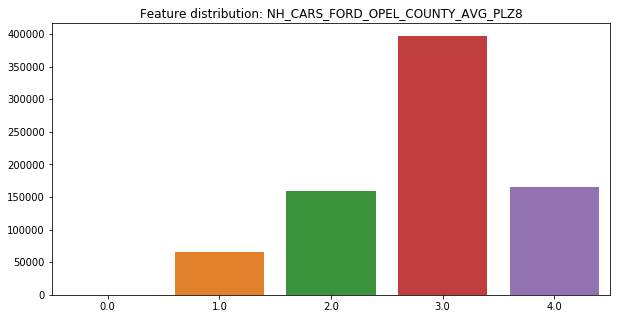

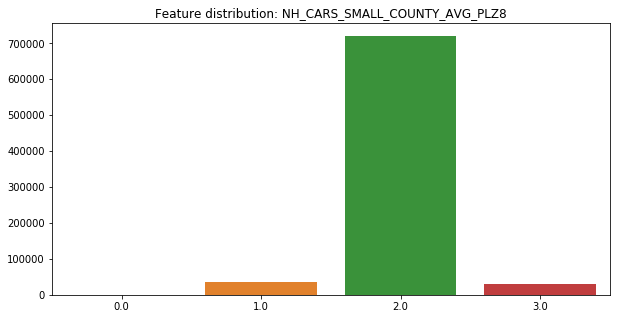

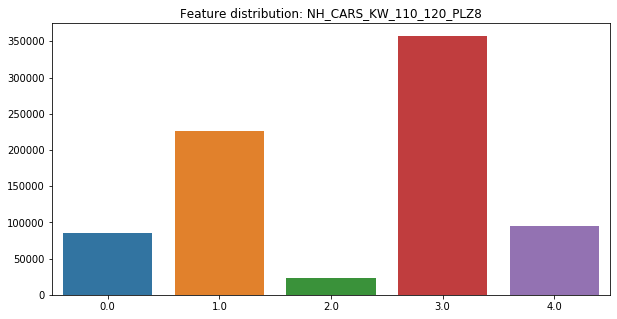

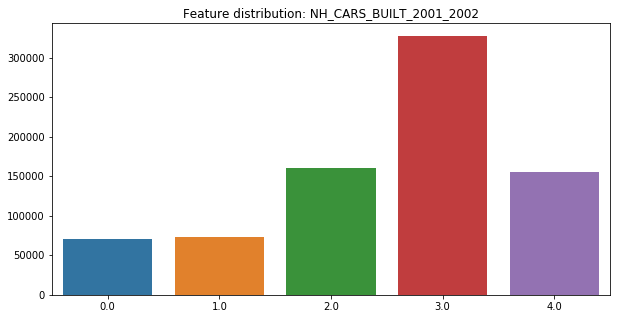

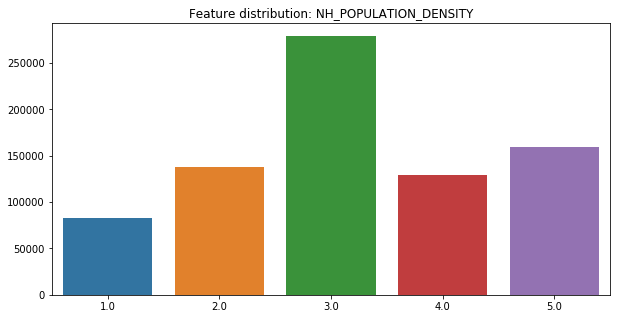

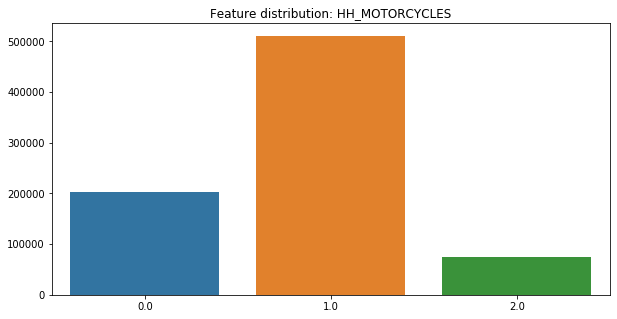

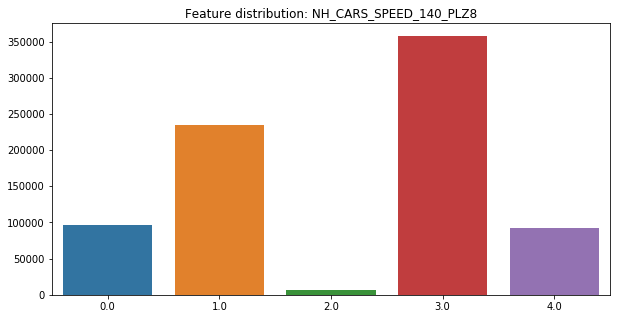

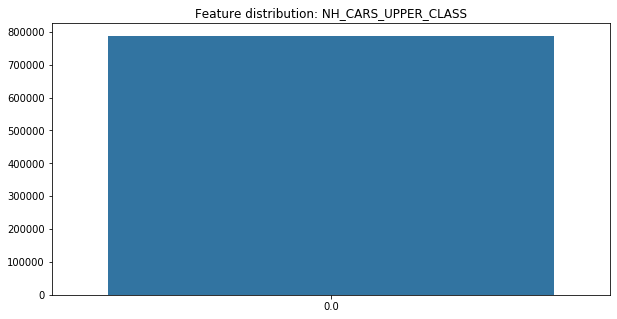

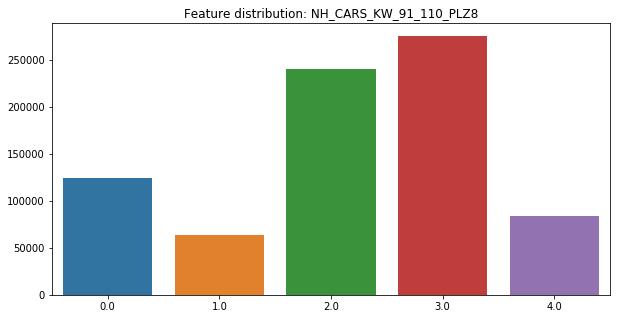

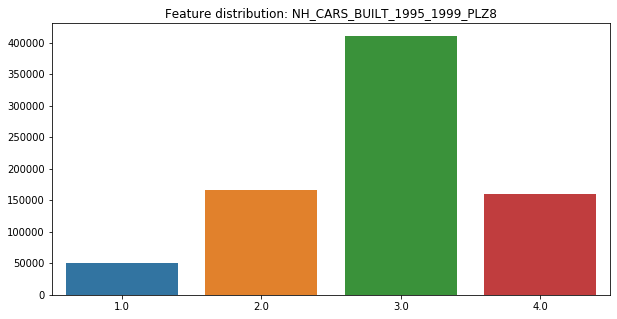

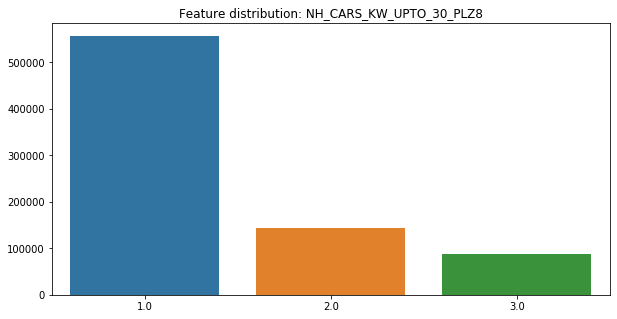

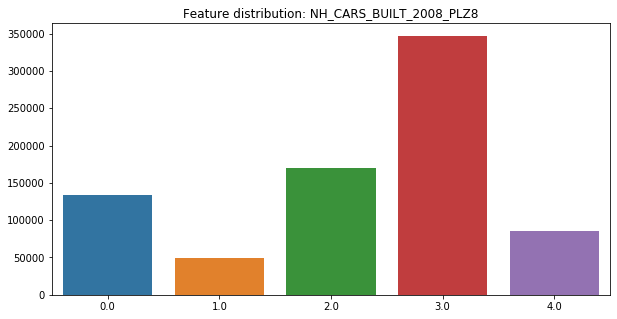

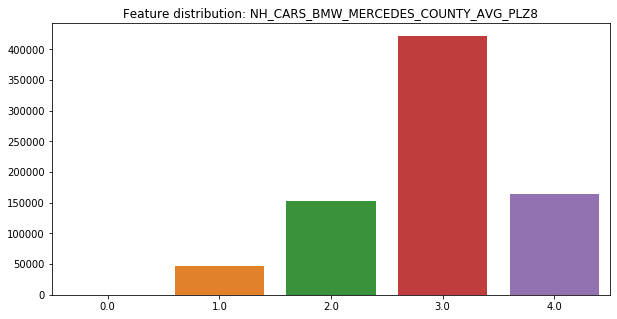

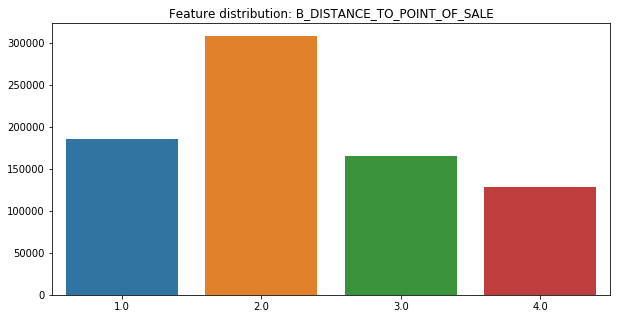

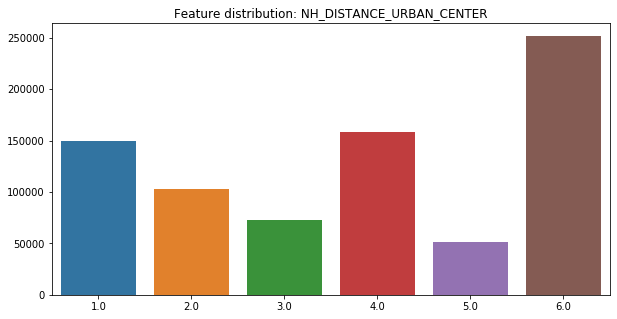

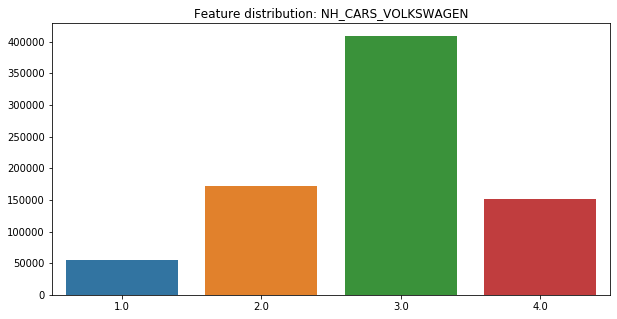

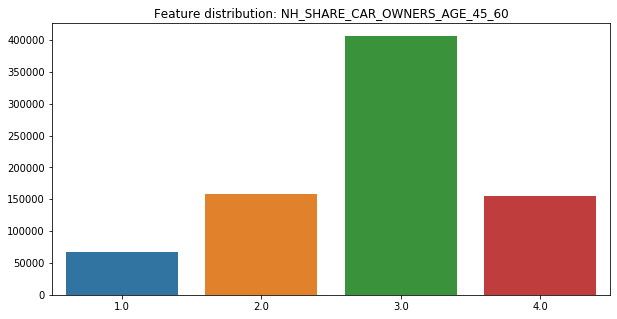

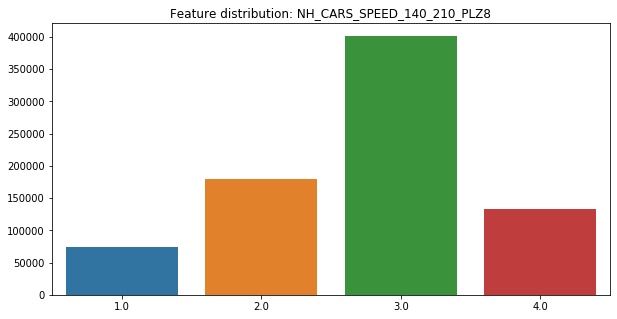

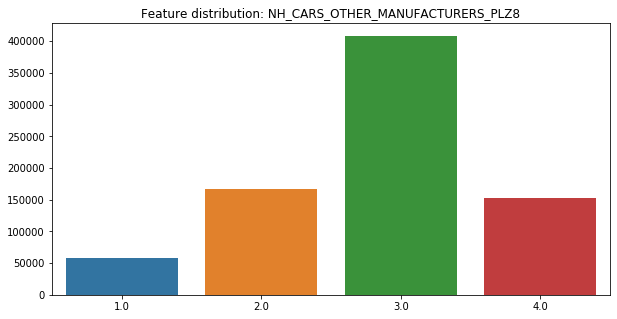

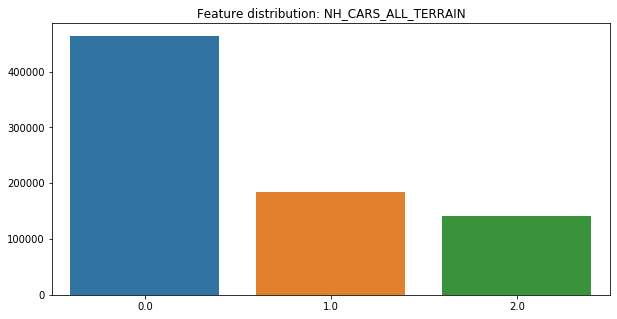

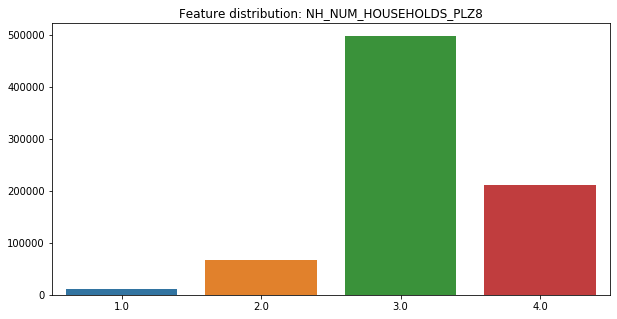

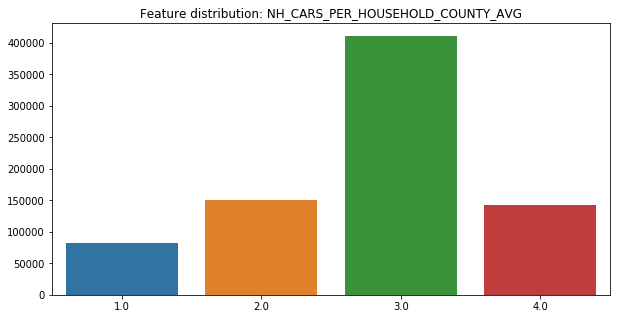

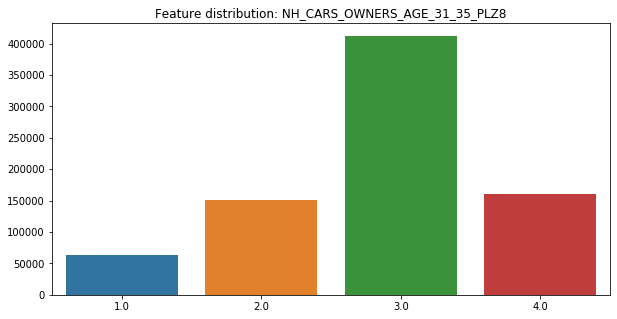

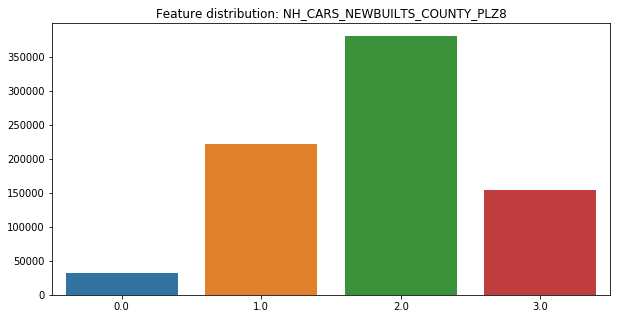

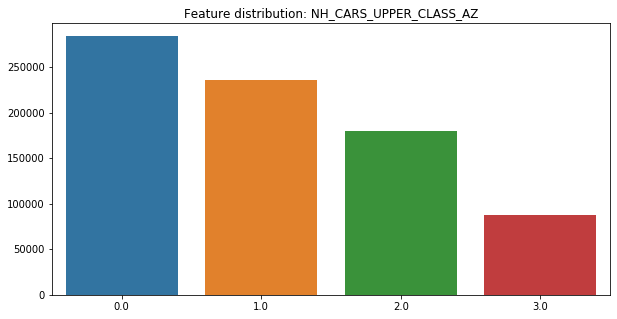

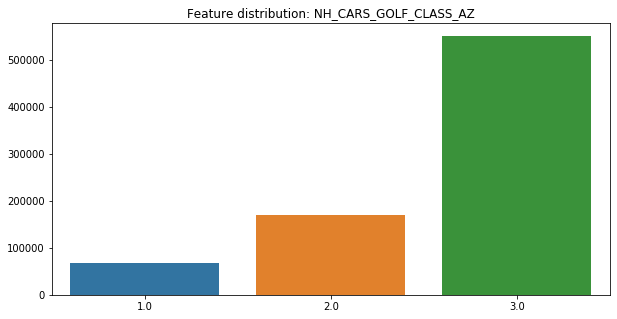

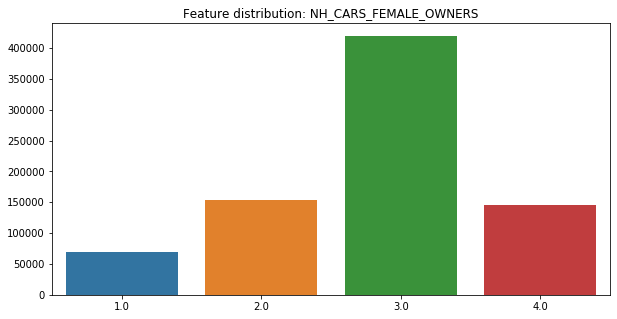

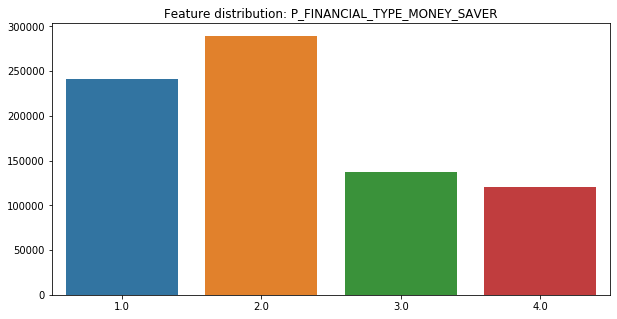

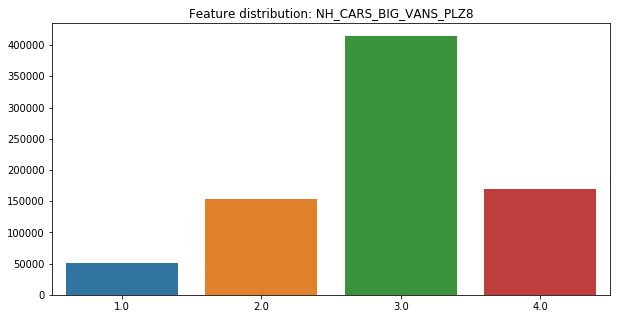

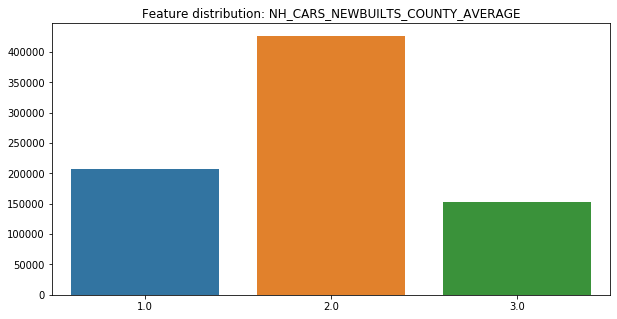

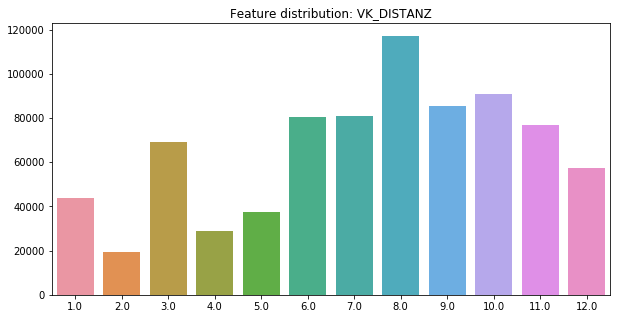

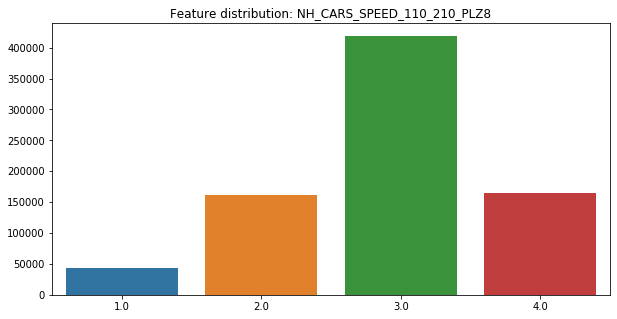

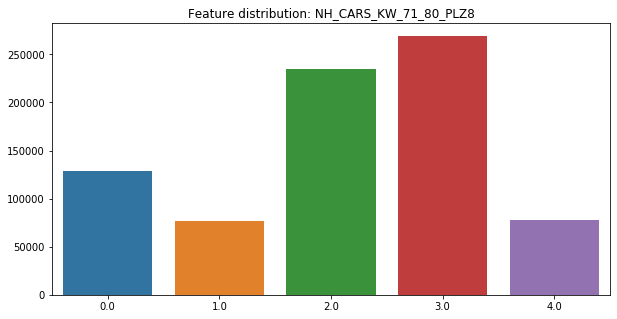

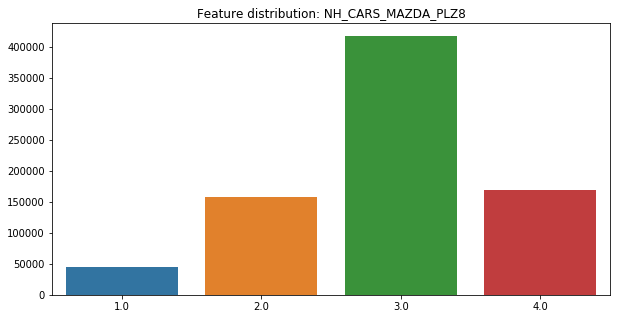

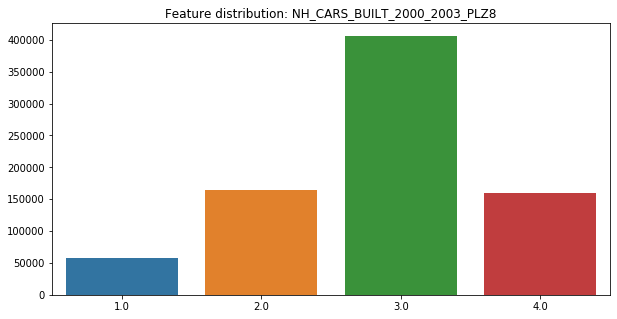

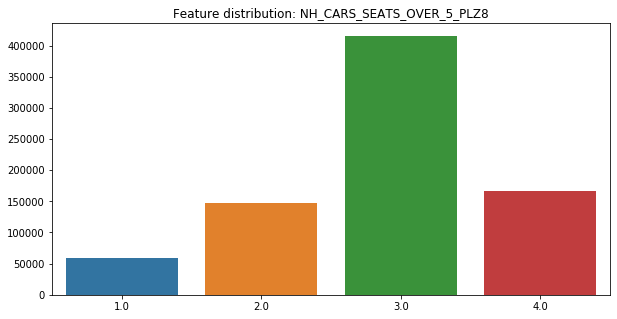

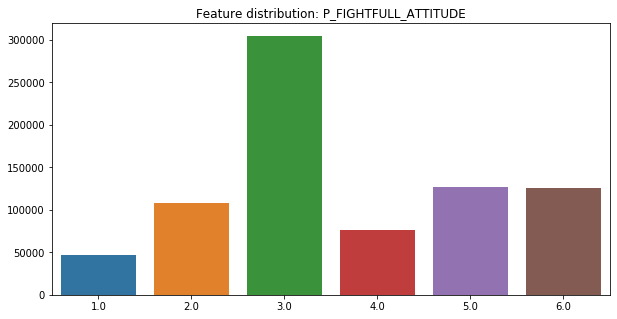

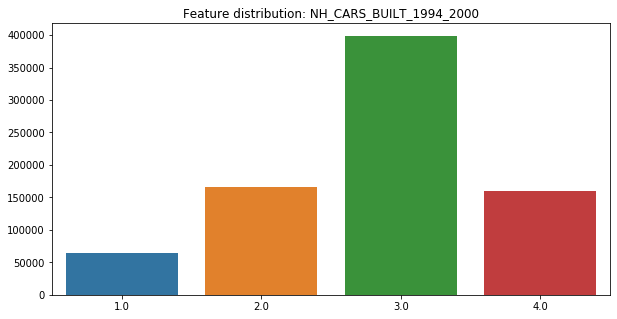

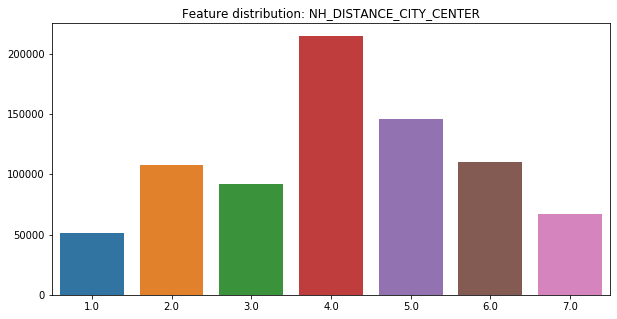

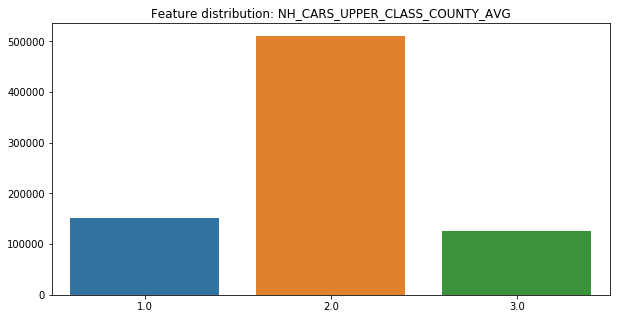

In [46]:
ordinal_dataframe = processing.get_ordinal_dataframe(azdias, attributes_df)
ordinal_cols = ordinal_dataframe.columns.values

for col in ordinal_cols:
    c = Counter(azdias[col])
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax = sns.barplot(x=list(c.keys()), y=list(c.values()))
    ax.set_title('Feature distribution: %s' % col)
    plt.show()

Feature `NH_CARS_UPPER_CLASS` has zero variance and hence shall be dropped

In [47]:
azdias.drop(columns=['NH_CARS_UPPER_CLASS'], inplace=True)
ordinal_dataframe.drop(columns=['NH_CARS_UPPER_CLASS'], inplace=True)

post_imputation_drop_features.extend(['NH_CARS_UPPER_CLASS'])

Visualization of data distribution for some ordinal features

Note: The number of non binary numerical features is very large (211), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.


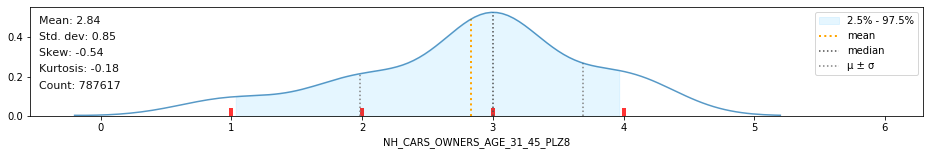

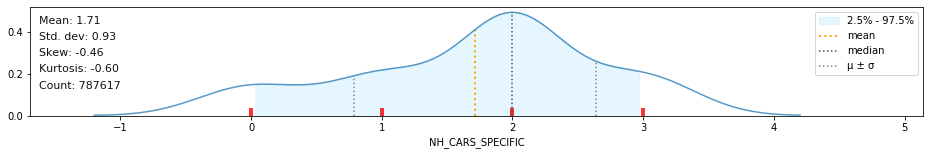

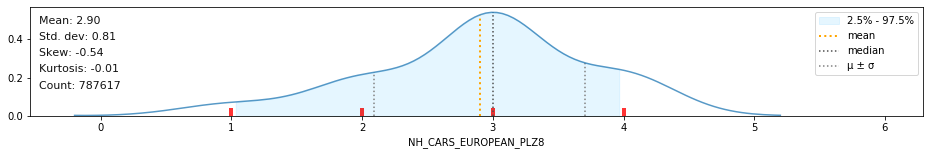

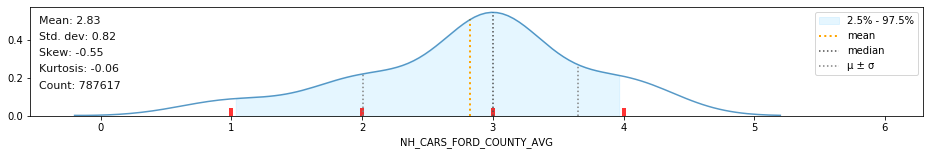

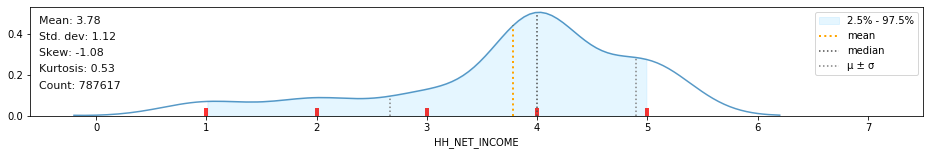

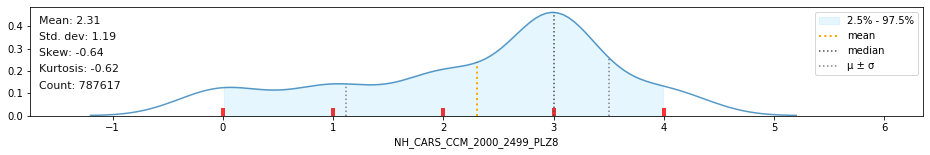

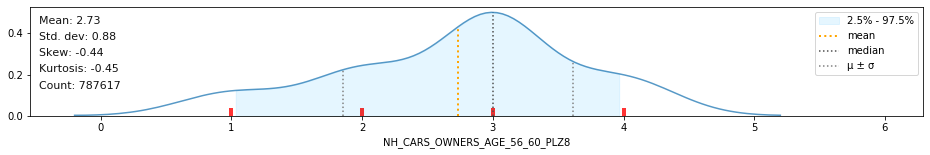

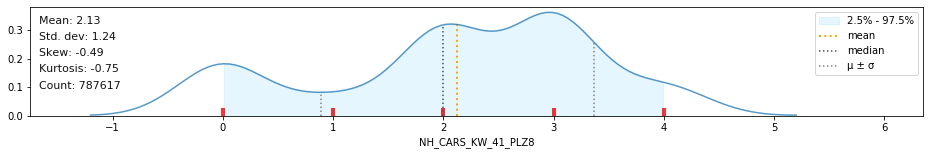

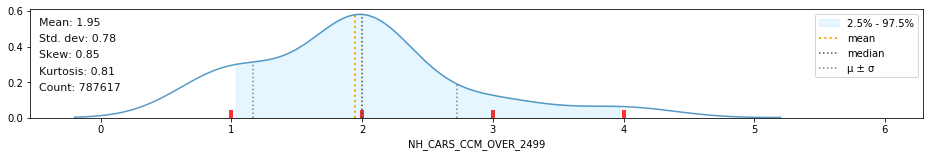

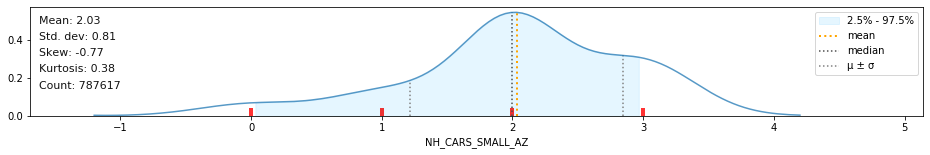

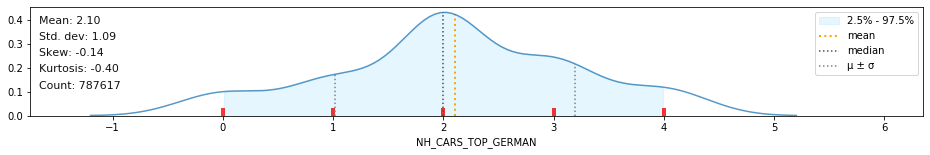

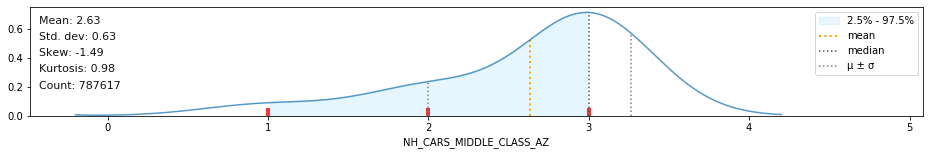

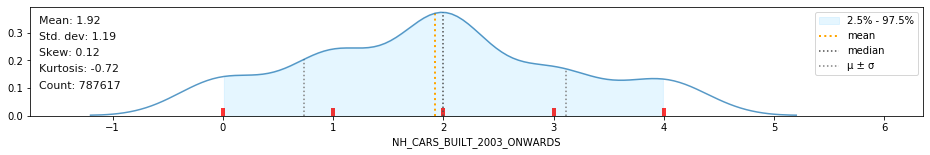

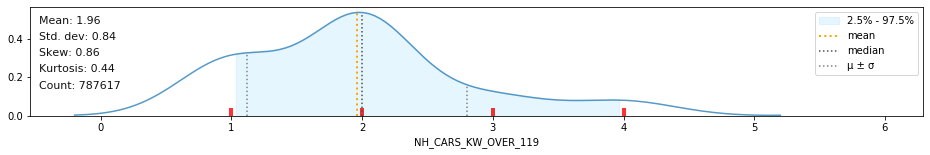

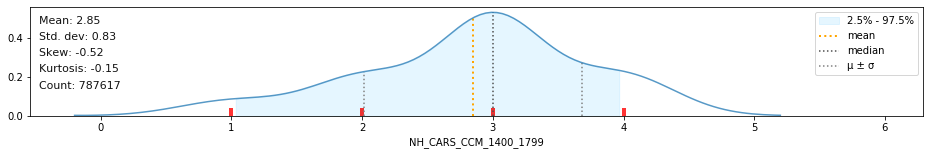

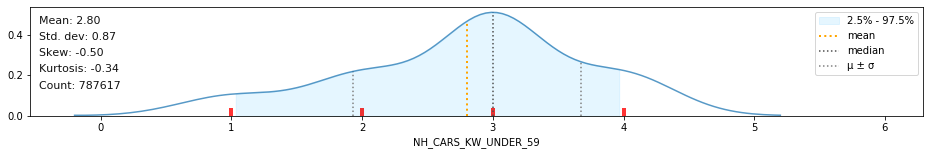

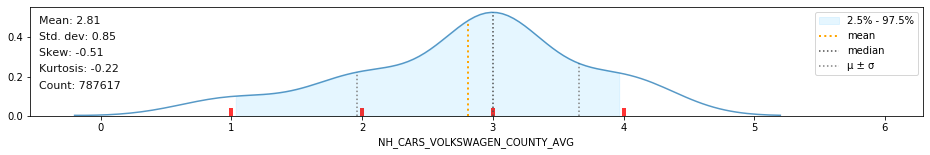

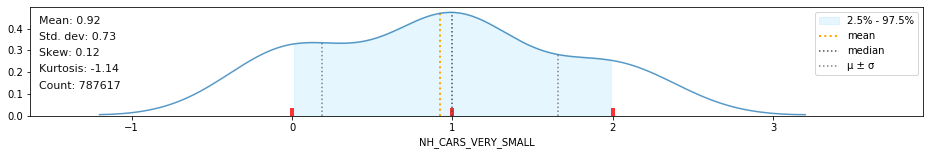

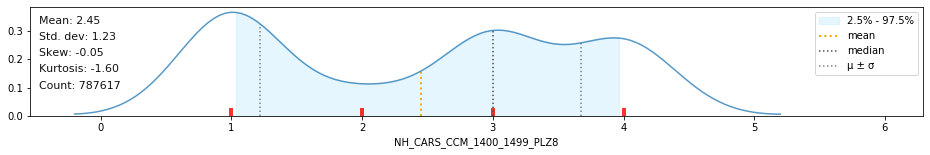

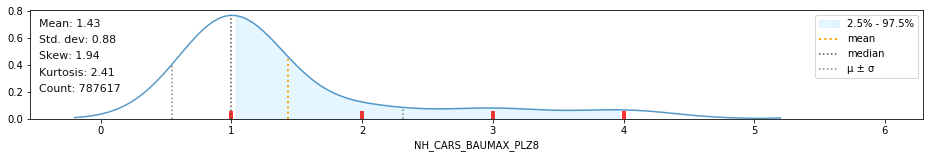

In [49]:
eda.dist_plot(ordinal_dataframe)

#### Feature Correlation for Ordinal Features

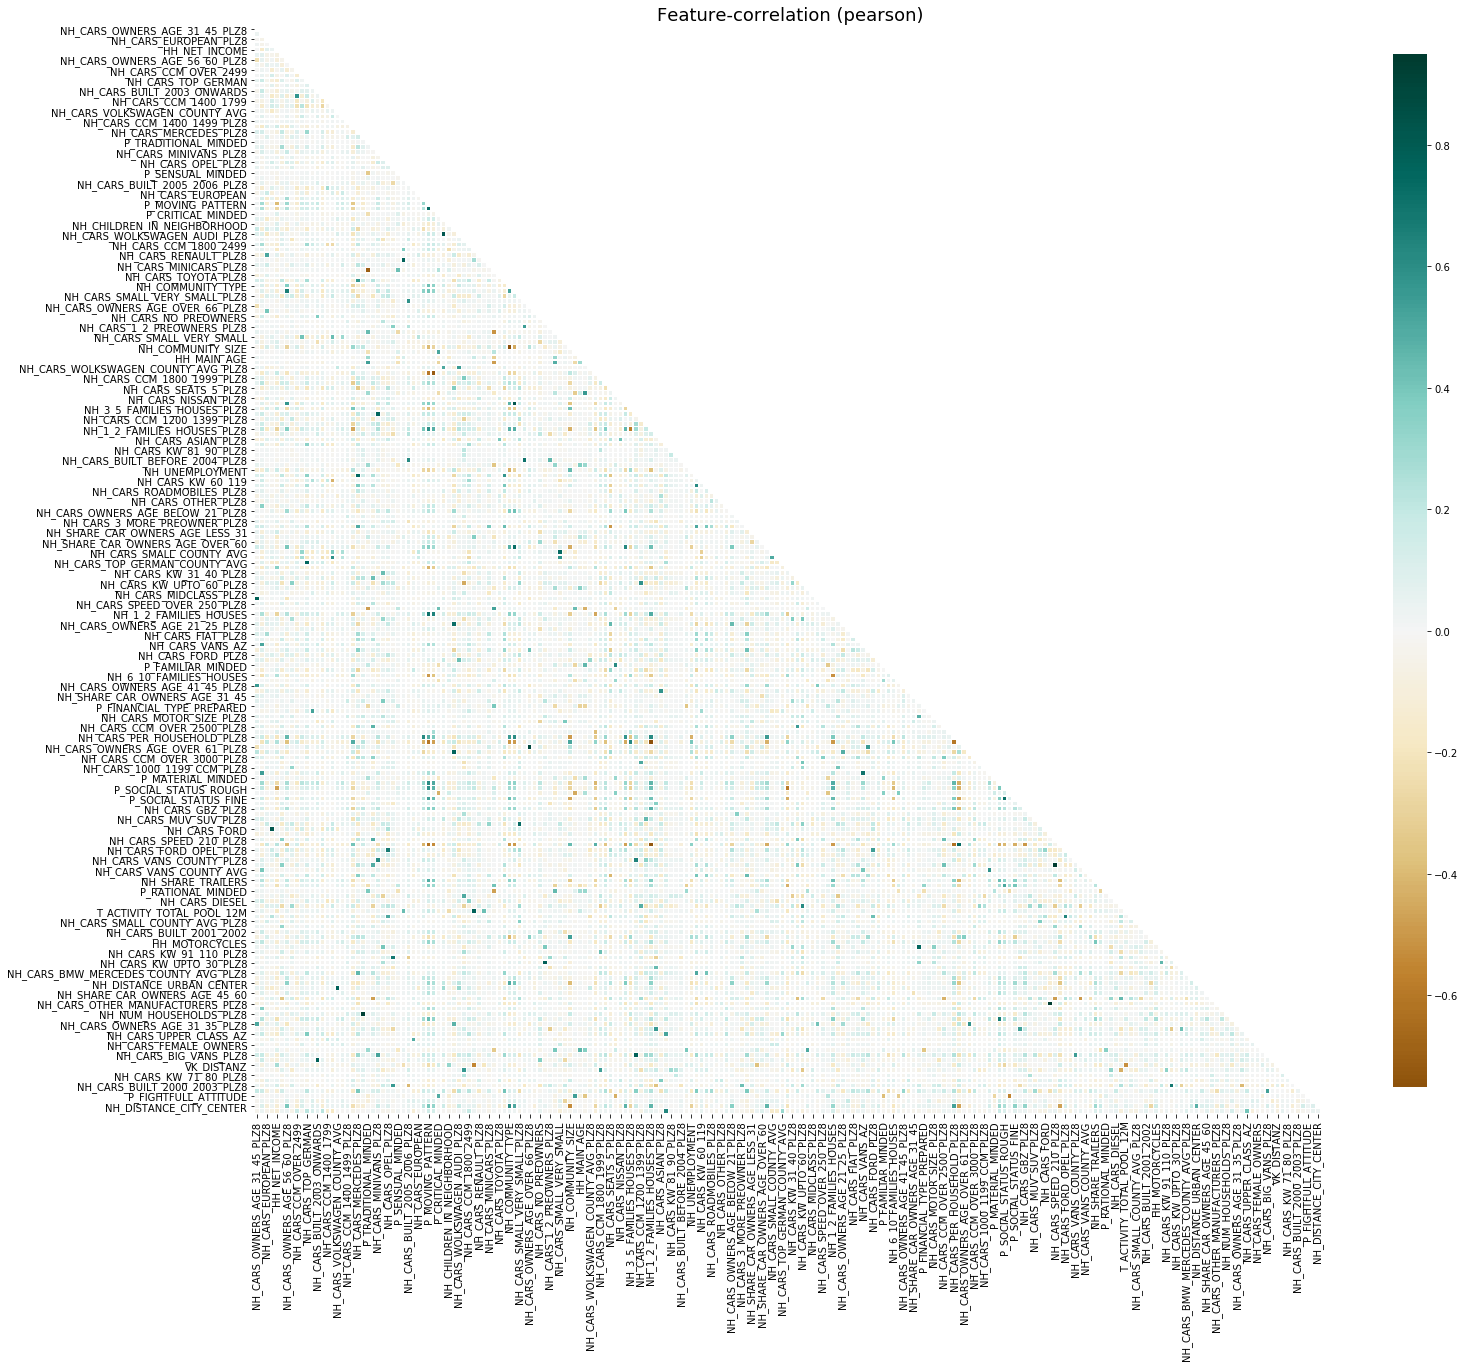

In [71]:
eda.corr_plot(ordinal_dataframe, split='high', threshold=0.85, annot=False, figsize=(24, 20)) 

In [72]:
del ordinal_dataframe

#### Feature Correlation for Numeric and Ordinal Features

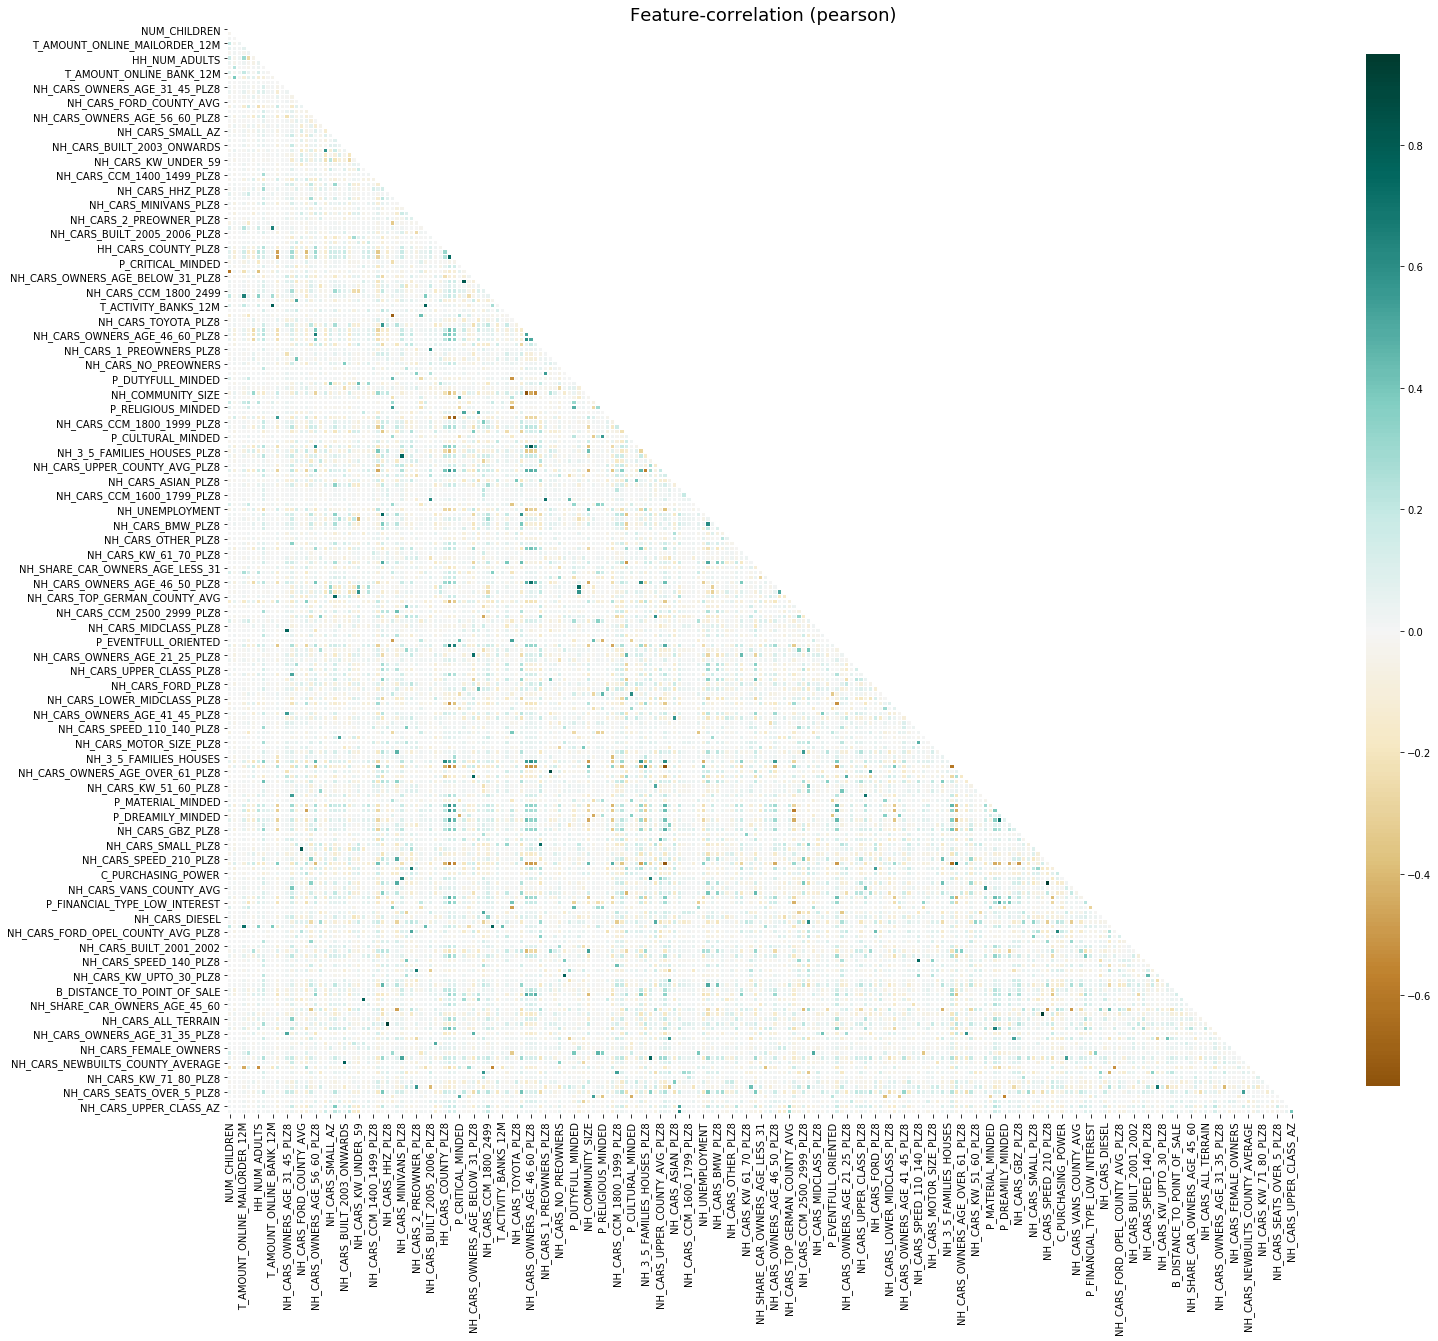

In [52]:
categorical_columns = processing.get_categorical_dataframe(azdias, attributes_df).columns.values
eda.corr_plot(azdias.drop(columns=categorical_columns), split='high', threshold=0.85, annot=False, figsize=(24, 20)) 

We can observe that we have some relevant correlation between features but due to the high number of ordinal features, it is hard to pin point those features. We will rely on PCA transformation to deal with that during dimensionality reduction.

#### Categorical Features

In [53]:
cat_df = processing.get_categorical_dataframe(azdias, attributes_df)

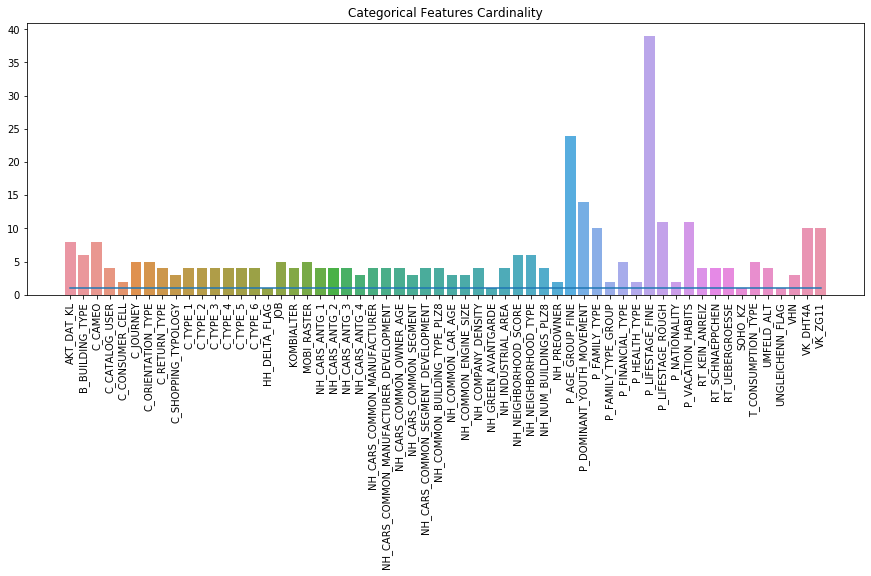

In [56]:
cardinality = OrderedDict()
for column in sorted(cat_df.columns.values):
    cardinality[column] = len(cat_df[column].unique())
                              
_, ax = plt.subplots(figsize=(15, 5))
x_values = list(cardinality.keys())
ax = sns.barplot(x_values, list(cardinality.values()))
ax = sns.lineplot(x_values, [1 for _ in range(len(x_values))])
ax.set_title('Categorical Features Cardinality')
_ = plt.xticks(rotation=90)

We can observe that while we have some features with low cardinality (and even some features with single values), we have features such as `P_AGE_GROUP_FINE` and `P_LIFESTAGE_FINE` with more than 25 distinct values and other couple of features with about 10 distinct categories.<br>
Encoding such features using One Hot Encoding would lead to an explosion in the number of features. To circunvent that, we will rely on Binary Encoding for features with more than 5 categories.<br>
Binary Encoding works by converting each category value to a binary representation and spliting each binary digit into a specific column. This techinique prevents the number of features to rapidily increasing at the cost of promoting a little distortion in features distances.

Drop categorical features with low variance:

In [57]:
print({k for k, v in cardinality.items() if v==1})

{'HH_DELTA_FLAG', 'UNGLEICHENN_FLAG', 'SOHO_KZ', 'NH_GREEN_AVANTGARDE'}


In [58]:
azdias.drop(columns=['HH_DELTA_FLAG', 'NH_GREEN_AVANTGARDE', 'UNGLEICHENN_FLAG', 'SOHO_KZ'], inplace=True)
cat_df.drop(columns=['HH_DELTA_FLAG', 'NH_GREEN_AVANTGARDE', 'UNGLEICHENN_FLAG', 'SOHO_KZ'], inplace=True)

post_imputation_drop_features.extend(['HH_DELTA_FLAG', 'NH_GREEN_AVANTGARDE', 'UNGLEICHENN_FLAG', 'SOHO_KZ'])

#### Feature correlation for categorical features
The standard definition of correlation does not apply to categorical features, since they lack the concept of magnitude.<br>
For such features, we can relly on [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r's_V) as a measure of assoctiation between 2 categorical features.

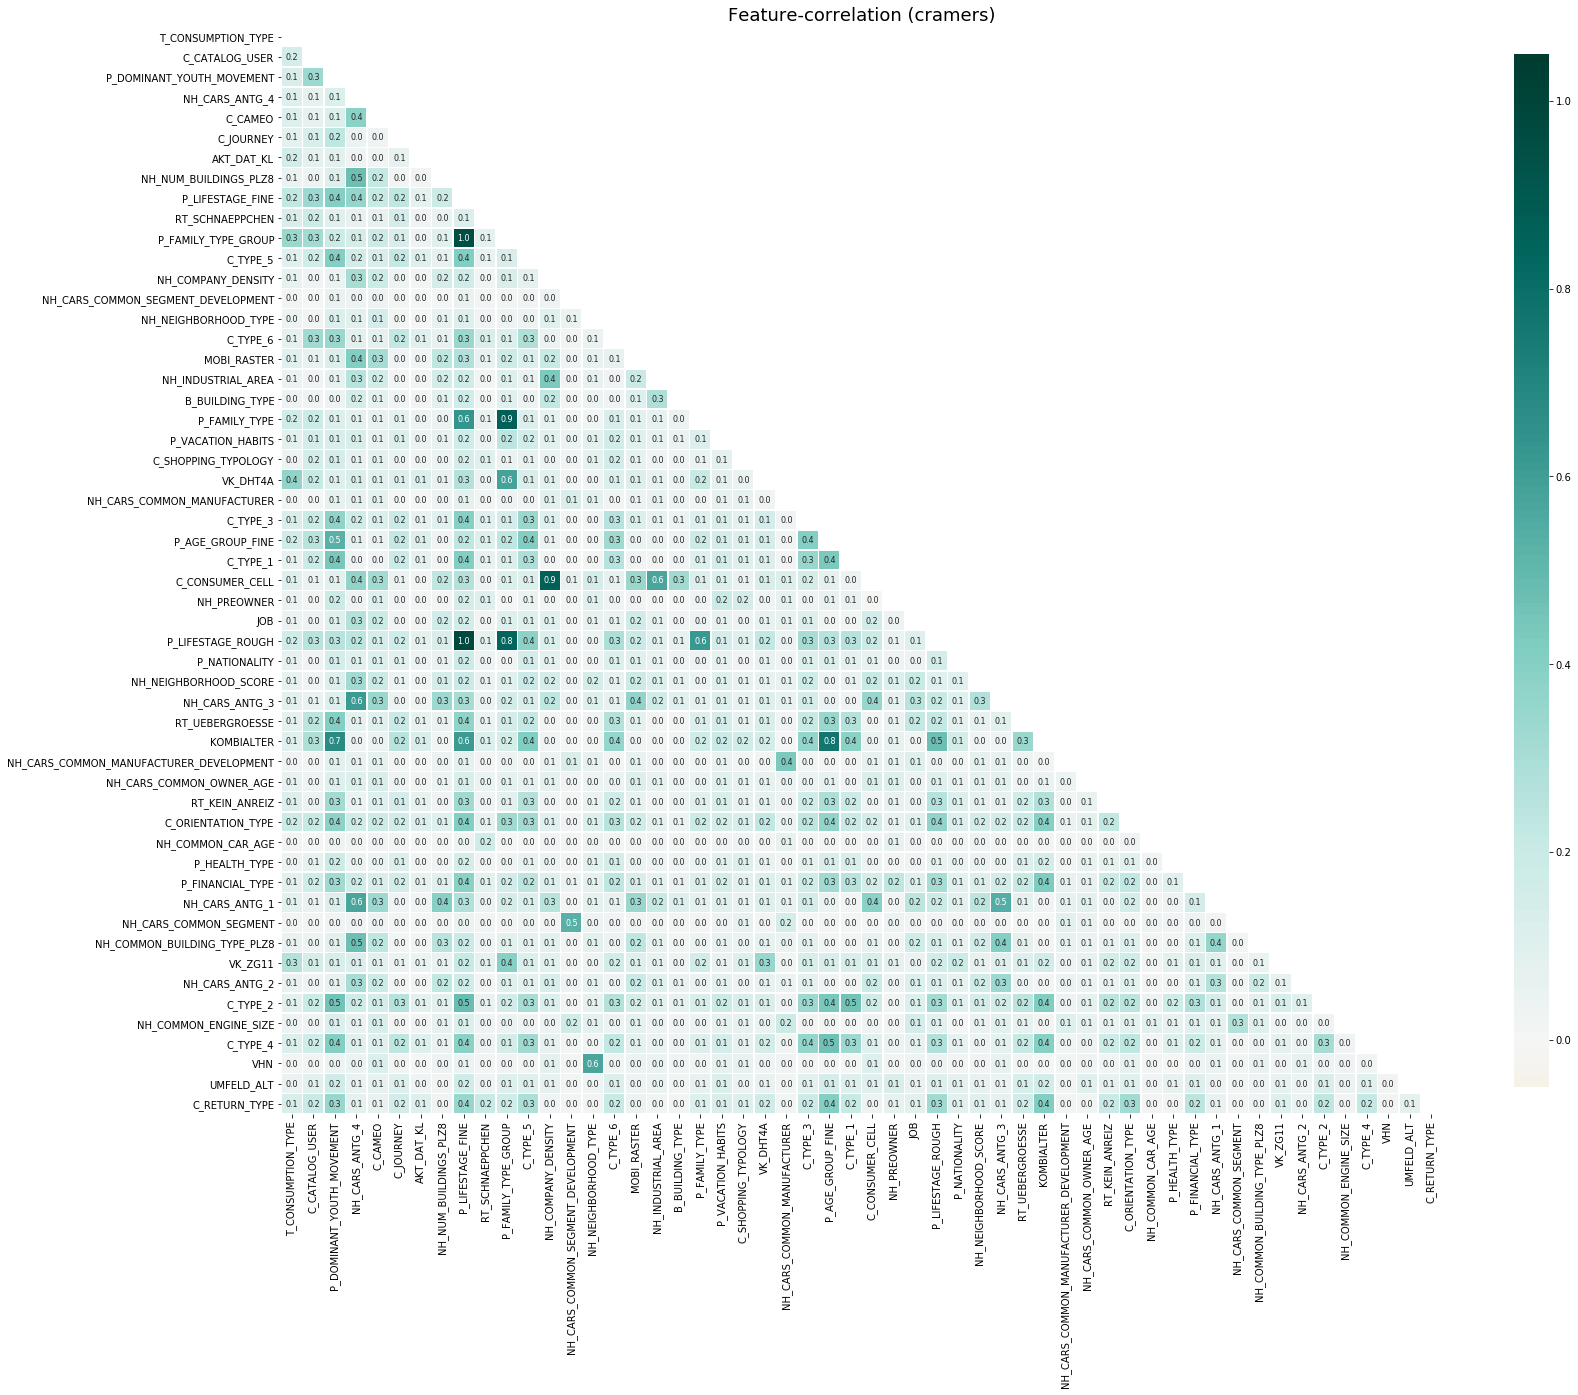

In [67]:
matrix = eda.crammers_correlation_matrix(azdias, cat_df.columns.values)
ax = eda.crammer_corr_plot(matrix, labels=cat_df.columns.values, threshold=0.7, figsize=(26,20))

Given the high cardinality of `P_LIFESTAGE_FINE` and high correlation with `P_LIFESTAGE_ROUGH` and `P_FAMILY_TYPE_GROUP`, this column will also be selected for dropping
<br>
There are another features with high correlation such as: `C_CONSUMER_CELL` and `NH_COMPANY_DENSITY`, and `KOMBIALTER` and `P_DOMINANT_YOUTH_MOVEMENT`, `P_AGE_GROUP_FINE`, `T_ACTUALITY_MAILORDER`. <br>
`C_CONSUMER_CELL` and `KOMBIALTER` will be removed as well

In [68]:
correlated_features = ['P_LIFESTAGE_FINE', 'C_CONSUMER_CELL', 'KOMBIALTER']
azdias.drop(columns=correlated_features)
post_imputation_drop_features.extend(correlated_features)

#### Save list of features to be dropped (after imputation)

In [75]:
utils.pickle_obj(post_imputation_drop_features, 'post_imputation_drop_features')

In [76]:
print(utils.unpickle_obj('post_imputation_drop_features'))

['P_BIRTH_YEAR', 'B_NUM_HOUSEHOLDS_BUILDING', 'T_AMOUNT_ONLINE_TOTAL_12M', 'NH_CARS_UPPER_CLASS', 'HH_DELTA_FLAG', 'NH_GREEN_AVANTGARDE', 'UNGLEICHENN_FLAG', 'SOHO_KZ', 'P_LIFESTAGE_FINE', 'C_CONSUMER_CELL', 'KOMBIALTER']


## Feature Transformation

### Encode Features
Categorical features with more than 5 distinct values will be encoded using binary encoding, while the others will be encoded using OneHot Encoding

In [92]:
azdias = processing.encode_features(azdias, attributes_df, fit=True)
azdias.head()

set()


NUM_CHILDREN  T_AMOUNT_ONLINE_BANK_12M  B_NUM_ACADEMICS_BUILDING  \
0           0.0                       0.0                       0.0   
1           0.0                       0.0                       0.0   
2           0.0                       0.0                       0.0   
3           0.0                      10.0                       0.0   
4           0.0                       0.0                       0.0   

   T_AMOUNT_ONLINE_INSURANCE_12M  HH_RECOVERED_YEAR  URBAN_AGGLOMERATION  \
0                            0.0             2004.0                  0.0   
1                            0.0             2000.0                  1.0   
2                            0.0             1998.0                  0.0   
3                            0.0             2004.0                  1.0   
4                            0.0             1994.0                  0.0   

   HH_NUM_ADULTS  HH_HOUSEHOLD_STATS  NH_NUMBER_CARS_PLZ8  \
0            2.0                12.0                963.0   
1            1.0                 7.0                712.0   
2            0.0                 2.0                596.0   
3            4.0                 3.0                435.0   
4            1.0                 2.0               1300.0   

   T_AMOUNT_ONLINE_MAILORDER_12M  ...  P_LIFESTAGE_ROUGH_2  \
0                            0.0  ...                    0   
1                            0.0  ...                    0   
2                            0.0  ...                    0   
3                           10.0  ...                    1   
4                            0.0  ...                    0   

   P_LIFESTAGE_ROUGH_3  P_LIFESTAGE_ROUGH_4  NH_NEIGHBORHOOD_SCORE_1  \
0                    0                    1                        0   
1                    1                    0                        0   
2                    1                    1                        0   
3                    0                    0                        1   
4                    1                    1                        0   

   NH_NEIGHBORHOOD_SCORE_2  NH_NEIGHBORHOOD_SCORE_3  VK_ZG11_1  VK_ZG11_2  \
0                        0                        1          0          0   
1                        1                        0          0          0   
2                        1                        1          0          0   
3                        0                        0          0          0   
4                        1                        1          0          0   

   VK_ZG11_3  VK_ZG11_4  
0          0          1  
1          1          0  
2          0          1  
3          1          1  
4          1          1  

[5 rows x 418 columns]

In [93]:
bucket.save_parquet(azdias, 'Udacity_AZDIAS_052018_encoded.parquet', compression='gzip')

### Feature Scaling: Normalization / Standardization
We shall produce two versions of the datasets: one using normalization (Min-Max scaling) and the other using standardization (Standard scaling).
<br>
Normalization transforms the feature values, bringing them to a \[0:1\] range.<br>
Standardization, in the other hand, transforms the feature values in such way that they end up with a zero means and unit standard deviation.<br>

Feature scaling is specially important to distance based algorithms such as PCA and K-Means where a single feature could distort the distance metrics.

In [94]:
bucket = utils.BucketUtils(bucket_name = 'arvatos-capstone', prefix = 'data')
azdias = bucket.read_parquet('Udacity_AZDIAS_052018_encoded.parquet')
azdias.sample(7)

NUM_CHILDREN  T_AMOUNT_ONLINE_BANK_12M  B_NUM_ACADEMICS_BUILDING  \
777019           0.0                       0.0                       0.0   
641270           0.0                       0.0                       0.0   
546292           1.0                      10.0                       0.0   
500877           0.0                       0.0                       0.0   
463199           0.0                       0.0                       0.0   
328789           0.0                       0.0                       0.0   
363542           0.0                       0.0                       0.0   

        T_AMOUNT_ONLINE_INSURANCE_12M  HH_RECOVERED_YEAR  URBAN_AGGLOMERATION  \
777019                            0.0             1994.0                  0.0   
641270                            0.0             2014.0                  0.0   
546292                            0.0             2002.0                  6.0   
500877                            0.0             1994.0                  6.0   
463199                            0.0             2001.0                  1.0   
328789                            0.0             1994.0                 18.0   
363542                            0.0             2013.0                  1.0   

        HH_NUM_ADULTS  HH_HOUSEHOLD_STATS  NH_NUMBER_CARS_PLZ8  \
777019            2.0                 1.0                334.0   
641270            1.0                15.0                658.0   
546292            2.0                 1.0                944.0   
500877            2.0                 2.0                362.0   
463199            2.0                 3.0                600.0   
328789            2.0                 7.0                634.0   
363542            4.0                 3.0                488.0   

        T_AMOUNT_ONLINE_MAILORDER_12M  ...  P_LIFESTAGE_ROUGH_2  \
777019                            0.0  ...                    1   
641270                           10.0  ...                    0   
546292                            0.0  ...                    0   
500877                            0.0  ...                    1   
463199                            0.0  ...                    0   
328789                            0.0  ...                    1   
363542                            0.0  ...                    1   

        P_LIFESTAGE_ROUGH_3  P_LIFESTAGE_ROUGH_4  NH_NEIGHBORHOOD_SCORE_1  \
777019                    1                    0                        1   
641270                    1                    1                        0   
546292                    0                    1                        1   
500877                    0                    1                        1   
463199                    0                    1                        0   
328789                    0                    0                        1   
363542                    0                    0                        0   

        NH_NEIGHBORHOOD_SCORE_2  NH_NEIGHBORHOOD_SCORE_3  VK_ZG11_1  \
777019                        0                        0          1   
641270                        1                        1          1   
546292                        0                        0          1   
500877                        0                        0          0   
463199                        1                        1          0   
328789                        0                        0          1   
363542                        1                        0          0   

        VK_ZG11_2  VK_ZG11_3  VK_ZG11_4  
777019          0          1          0  
641270          0          1          0  
546292          0          0          0  
500877          0          1          1  
463199          0          1          1  
328789          0          0          0  
363542          0          1          1  

[7 rows x 418 columns]

In [95]:
mm_azdias = processing.features_normalization(azdias, fit=True)
bucket.save_parquet(mm_azdias, 'Udacity_AZDIAS_052018_mm.parquet', compression='gzip')
del mm_azdias

In [96]:
std_azdias = processing.features_standardization(azdias, fit=True)
bucket.save_parquet(std_azdias, 'Udacity_AZDIAS_052018_std.parquet', compression='gzip')
del std_azdias

## Process additional datasets 
Now that the pre-processing, cleanup, imputation and transformation processes were defined based on General Population Demographic data, it is time to perform the same process to other datasets.<br>
It is important to note that, based on the premise that the General Population Demographic data is representative of Customers and Mailorder data, the same transformation parameters (such as imputation, features min and max, categories etc) defined for General Population Demographic data shall be applied to othe datasets.

In [98]:
bucket = utils.BucketUtils(bucket_name = 'arvatos-capstone', prefix = 'data')
attributes_df = bucket.read_csv('DIAS_attribute_transformations.csv')

In [100]:
def process_data(file_prefix, bucket, attributes_df):
    """
    Load and process a data set:
        Load file
        Drop unused features
        Perform pre-processing and feature renaming
        Perform data imputation
        Drop low-variance and highly correlated features
        Perform feature encoding
        Perform normalization/standardization
        Save data to bucket
    ---
    Arguments
        file_prefix: string
            The file name prefix (without extension)
        bucket: BucketUtils
            Bucket instance where the file is locate
        attributes_df: pd.DataFrame
            Dataframe with attributes renaming and transformation rules
    Returns
        data: pd.DataFrame
            Dataframe with encoded data
    """      
    print('Loading data: %s' % file_prefix)
    data = bucket.read_csv('%s.csv.gz' % file_prefix)

    print('Loading feature set ...')
    features = processing.load_feature_set(label='features_of_interest')
    
    print('Dropping columns of no interest ...')
    data.drop(columns=set(data.columns)-set(features), inplace=True)

    print('Data pre-processing and columns renaming ...')
    data = processing.data_pre_processing(data, attributes_df)

    print('Filling missing data ...')
    data = processing.values_imputation(data, attributes_df, fit=False, nan_value=-1)
    
    print('Loading set of features to be dropped ...')
    features = utils.unpickle_obj('post_imputation_drop_features')

    print('Dropping columns with high correlation or low variance')
    data.drop(columns=features, inplace=True)

    print('Encoding features ...')
    data = processing.encode_features(data, attributes_df, fit=False)

    print('Performing normalization ...')
    mm_data = processing.features_normalization(data, fit=False)
    bucket.save_parquet(mm_data, '%s_mm.parquet' % file_prefix, compression='gzip')
    del mm_data
    
    print('Performing standardization ...')
    mm_std = processing.features_standardization(data, fit=False)
    bucket.save_parquet(mm_std, '%s_std.parquet' % file_prefix, compression='gzip')
    del mm_std
    
    return data

#### MAILOUT

In [102]:
file_prefix = 'Udacity_MAILOUT_052018_TEST'
mailout = process_data(file_prefix, bucket, attributes_df)
del mailout

Loading data: Udacity_MAILOUT_052018_TEST


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading feature set ...
Dropping columns of no interest ...
Data pre-processing and columns renaming ...
Filling missing data ...
Loading set of features to be dropped ...
Dropping columns with high correlation or low variance
Encoding features ...
Performing normalization ...
Performing standardization ...


In [103]:
file_prefix = 'Udacity_MAILOUT_052018_TRAIN'
mailout = process_data(file_prefix, bucket, attributes_df)
del mailout

Loading data: Udacity_MAILOUT_052018_TRAIN


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading feature set ...
Dropping columns of no interest ...
Data pre-processing and columns renaming ...
Filling missing data ...
Loading set of features to be dropped ...
Dropping columns with high correlation or low variance
Encoding features ...
Performing normalization ...
Performing standardization ...


In [104]:
file_prefix = 'Udacity_MAILOUT_052018_TRAIN'
data = bucket.read_csv('%s.csv.gz' % file_prefix)
data.drop(columns=set(data.columns.values)-set(['RESPONSE']), inplace=True)

print('Saving mailout response (ground truth) for %s ' % file_prefix)
bucket.save_parquet(data, '%s_response.parquet' % file_prefix, compression='gzip')

Saving mailout response (ground truth) for Udacity_MAILOUT_052018_TRAIN 


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


#### Customers

In [106]:
file_prefix = 'Udacity_CUSTOMERS_052018'
customers = process_data(file_prefix, bucket, attributes_df)
del customers

Loading data: Udacity_CUSTOMERS_052018


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading feature set ...
Dropping columns of no interest ...
Data pre-processing and columns renaming ...
Filling missing data ...
Loading set of features to be dropped ...
Dropping columns with high correlation or low variance
Encoding features ...
Performing normalization ...
Performing standardization ...


#### The end

Data is now cleaned and transformed, ready to be used on Customer Segmentation and Mailorder Campaign Response Prediction tasks